# Deterministic Goldstein-Taylor equation
---
Consider the equation
$$
\left\{
\begin{aligned}
&\frac{\partial u}{\partial t} + \frac{\partial v}{\partial x} = 0, \\
&\frac{\partial v}{\partial t} + \frac{1}{\epsilon}\frac{\partial u}{\partial x} = - \frac{1}{\epsilon}v, 
\end{aligned}
\right.
$$
where $\epsilon$ is a small number.

The initial data are
$$
\left\{
\begin{aligned}
&u(x, 0) = 2, v(x, 0) = 0, x\in [-1, 0], \\
&u(x, 0) = 1, v(x, 0) = 0, x\in (0, 1],
\end{aligned}
\right.
$$

BC:
$$
u(-1, t) = 2, \ v(-1, t) = 0, \ u(1, t) = 1, \ v(1, t) = 0.
$$

The spatiotemporal domain is 
$$
(x, t) \in [-1, 1]\times [0, 0.25].
$$

In [1]:
NAME = "3_1e-12"

In [2]:
import jax, jax.nn
from jax import random
import jax.numpy as jnp
from jax.experimental import optimizers
from jax.ops import index, index_add, index_update


import sys, os
sys.path.append("../../")
	
from Seismic_wave_inversion_PINN.data_utils import *
from Seismic_wave_inversion_PINN.jax_model import *

from collections import namedtuple
# from jax.config import config; config.update("jax_enable_x64", True)
# dtype = jnp.float64
dtype = jnp.float32

In [3]:
key = random.PRNGKey(1)
key, subkey = random.split(key, 2)

layers = [2] + [32]*4 + [2] # (x, t) -> (u, v)
c0 = 6.0
w0 = jnp.array([[1.0, 1.0]]).T
w1 = jnp.array([[1.0, 1.0]]) # (w_u, w_v)
direct_params = init_siren_params(subkey, layers, c0, w0, w1, dtype)

domain = jnp.array([[-1., 0.], [1., 0.25]])
spatial_width = domain[1, 0]-domain[0, 0]

epsilon = 1e-12

@jax.jit
def model(params, xt): # for predictions
	for w, b in params[:-1]:
		xt = jnp.sin(jnp.dot(xt, w) + b)
	return jnp.dot(xt, params[-1][0]) + params[-1][1]

# @jax.jit
# def model_(params, xt): # for derivatives
# 	for w, b in params[:-1]:
# 		xt = jnp.sin(jnp.dot(xt, w) + b)
# 	return jnp.dot(xt, params[-1][0]) + params[-1][1]

jacobian = jacrev_fn(model)
hessian = hessian_fn(model)

In [4]:
metaloss = mae

# static_jit = lambda i: jax.partial(jax.jit, static_argnums = i)

# jacobian[i] = [[du/dx, du/dt],
#                [dv/dx, dv/dt]]
# i: the i^th input

# hessian[i] = [
#				[[du/dxx, du/dxy],
#                [du/dxy, du/dyy]],
#               [[dv/dxx, dv/dxy],
#                [dv/dxy, dv/dyy]]
#              ]
@jax.jit
def loss_fn_(params, batch):
	collocation, dirichlet = batch["collocation"], batch["dirichlet"]
	direct_params = params
	
	if collocation[0] is not None:
		uv_c = model(direct_params, jnp.hstack([collocation.x, collocation.t]))
		u_c, v_c = uv_c[:, 0:1], uv_c[:, 1:2]
		duv_dxt_c = jacobian(direct_params, jnp.hstack([collocation.x, collocation.t]))
		du_dt_c, dv_dt_c = duv_dxt_c[:, 0:1, 1], duv_dxt_c[:, 1:2, 1]
		du_dx_c, dv_dx_c = duv_dxt_c[:, 0:1, 0], duv_dxt_c[:, 1:2, 0]
		loss_c1 = metaloss(du_dt_c + dv_dx_c, 0)
		loss_c2 = metaloss(dv_dt_c + 1/epsilon*du_dx_c, -1/epsilon*v_c)
# 		loss_c = loss_c1 + loss_c2
	else:
		loss_c1 = loss_c2 = 0
# 		loss_c = 0.0
        
	if dirichlet[0] is not None:
		uv_d = model(direct_params, jnp.hstack([dirichlet.x, dirichlet.t]))
		u_d, v_d = uv_d[:, 0:1], uv_d[:, 1:2]
		loss_d1 = metaloss(u_d, dirichlet.u)
		loss_d2 = metaloss(v_d, dirichlet.v)
		loss_d = loss_d1 + loss_d2
	else:
		loss_d = 0.0

	return loss_c1, loss_c2, loss_d

@jax.jit
def loss_fn(params, batch):
	w = batch["weights"]
	loss_c1, loss_c2, loss_d = loss_fn_(params, batch)
	return w["c1"]*loss_c1 + w["c2"]*loss_c2 + w["d"]*loss_d + l1_regularization(params, w["l1"]) + l2_regularization(params, w["l2"])

@jax.jit
def step(i, opt_state, batch):
	params = get_params(opt_state)
	grad = jax.grad(loss_fn, 0)(params, batch)
	return opt_update(i, grad, opt_state)

@jax.jit
def evaluate(params, batch):
	w = batch["weights"]
	loss_c1, loss_c2, loss_d = loss_fn_(params, batch)
	l1 = l1_regularization(params, 1.0)
	l2 = l2_regularization(params, 1.0)
	return w["c1"]*loss_c1 + w["c2"]*loss_c2 + w["d"]*loss_d, loss_c1, loss_c2, loss_d, l1, l2

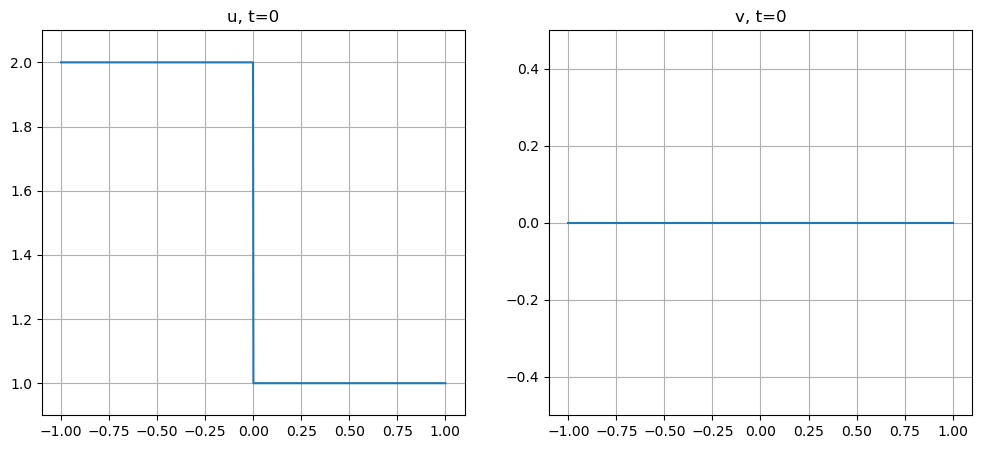

In [5]:
u0_fn = lambda x, t: jnp.select([x <= 0, x > 0], [2.0, 1.0])
v0_fn = lambda x, t: jnp.zeros_like(x)

u0_fn_ = lambda xt: jnp.select([xt[0] < 0, xt[0] > 0], [2.0, 1.0])
v0_fn_ = lambda xt: jnp.zeros_like(xt[0])

du0_dt_fn = lambda xt: jax.vmap(jax.jacfwd(u0_fn_), in_axes = 0)(xt)[:, 1:2]
dv0_dt_fn = lambda xt: jax.vmap(jax.jacfwd(v0_fn_), in_axes = 0)(xt)[:, 1:2]

du0_dx_fn = lambda xt: jax.vmap(jax.jacfwd(u0_fn_), in_axes = 0)(xt)[:, 0:1]
dv0_dx_fn = lambda xt: jax.vmap(jax.jacfwd(v0_fn_), in_axes = 0)(xt)[:, 0:1]

x0 = np.linspace(*domain[:, 0], 1000)
t0 = np.zeros_like(x0)
u0 = u0_fn(x0, t0)
v0 = v0_fn(x0, t0)

import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)

f, ax = plt.subplots(1, 2, figsize = (12, 5))
ax[0].plot(x0, u0)
ax[0].set_title("u, t=0")
ax[0].grid()
ax[0].set_ylim([0.9, 2.1])
ax[1].plot(x0, v0)
ax[1].set_title("v, t=0")
ax[1].grid()
ax[1].set_ylim([-0.5, 0.5])
plt.show()

key, *subkeys = random.split(key, 3)

n_i = 2000
x_i = jnp.linspace(*domain[:, 0], n_i).reshape((-1, 1))
t_i = jnp.zeros_like(x_i)
u_i = u0_fn(x_i, t_i)
v_i = v0_fn(x_i, t_i)

n_b = 2000
x_bl = jnp.ones((n_b, 1))*domain[0, 0]
x_br = jnp.ones((n_b, 1))*domain[1, 0]
t_b = jnp.linspace(*domain[:, 1], n_b).reshape((-1, 1))
x_b = jnp.vstack([x_bl, x_br])
t_b = jnp.vstack([t_b, t_b])
u_b = u0_fn(x_b, t_b)
v_b = v0_fn(x_b, t_b)

n_cx = 1000
n_ct = 1000
x_c = jnp.linspace(*domain[:, 0], n_cx).reshape((-1, 1))
t_c = jnp.linspace(*domain[:, 1], n_ct).reshape((-1, 1))
xt_c = tensor_grid([x_c, t_c])

dataset_Dirichlet = namedtuple("dataset_Dirichlet", ["x", "t", "u", "v"])
dataset_Collocation = namedtuple("dataset_Collocation", ["x", "t"])

dirichlet = dataset_Dirichlet(jnp.vstack([x_i, x_b]), jnp.vstack([t_i, t_b]), jnp.vstack([u_i, u_b]), jnp.vstack([v_i, v_b]))
collocation = dataset_Collocation(xt_c[:, 0:1], xt_c[:, 1:2])

In [6]:
# class Time_Marching_Generator:
# 	def __init__(self, key, spatial_points, temporal_domain, batch_size, iterations, update_every, count1 = 0):
# 		self.key = key
# 		self.spatial_points = spatial_points
# 		self.domain = temporal_domain
# 		self.batch_size = batch_size
# 		self.iterations = iterations
# 		self._count1 = count1
# 		self._count2 = update_every
# 		if count1 < iterations:
# 			self._update(self.domain[0])
# 		else:
# 			self._update(self.domain[1])
# 		self.update_every = update_every
		
# 	def _update(self, tmax):
# 		self.key, subkey = random.split(self.key)
# 		self._t = random.uniform(key, (self.batch_size, 1), jnp.float32, self.domain[0], tmax)
		
# 	def __iter__(self):
# 		return self
	
# 	def __next__(self):
# 		if self._count2 == self.update_every:
# 			self._count1 = max(self.iterations, self._count1 + 1)
# 			tmax = self.domain[0] + (self.domain[1]-self.domain[0])*self._count1/self.iterations
# 			self._update(tmax)
# 			self._count2 = 0
# 		else:
# 			self._count2 += 1
# 		return self.spatial_points, self._t

In [7]:
lr = 1e-3
params = direct_params
opt_init, opt_update, get_params = optimizers.adam(lr)
opt_state = opt_init(params)
hist = {"iter": [], "loss": []}

batch_size = {"dirichlet": 2000, "collocation": 2000}
key, *subkeys = random.split(key, 5)
Dirichlet = Batch_Generator(subkeys[0], dirichlet, batch_size["dirichlet"])
Collocation = Batch_Generator(subkeys[1], collocation, batch_size["collocation"])

start_iteration = 0
iterations = 100000
print_every = 500
save_every = 10000
weights = {"c1": 1.0, "c2": epsilon, "d": 100.0, "l1": 1e-8, "l2": 1e-8}

for iteration in range(start_iteration, start_iteration+iterations+1):
	batch = {
		"dirichlet": dataset_Dirichlet(*next(Dirichlet)),
		"collocation": dataset_Collocation(*next(Collocation)),
		"weights": weights,
	}
	opt_state = step(iteration, opt_state, batch)
	if (iteration-start_iteration) % print_every == 0:
		names = ["Loss", "c1", "c2", "d", "l1_reg", "l2_reg"]
		params_ = get_params(opt_state)
		batch = {
			"dirichlet": dataset_Dirichlet(*Dirichlet.dataset),
			"collocation": dataset_Collocation(*Collocation.dataset),
			"weights": weights
		}
		losses = evaluate(params_, batch)
		print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
		hist["iter"].append(iteration)
		hist["loss"].append(losses)
	if (iteration-start_iteration) % save_every == 0:
		params_ = np.asarray(get_params(opt_state), dtype = object)
		save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
		if not os.path.exists(os.path.dirname(save_path)):
			os.makedirs(os.path.dirname(save_path))
		np.save(save_path, params_)

2020/08/21, 21:41:35, Iteration: 0, Train Loss: 3.3178e+02, c1: 1.8558e+00, c2: 2.2547e+12, d: 3.2767e+00, l1_reg: 7.3178e+02, l2_reg: 2.6641e+02
2020/08/21, 21:41:38, Iteration: 500, Train Loss: 3.2163e+00, c1: 2.7478e-01, c2: 4.4399e+11, d: 2.4975e-02, l1_reg: 7.2970e+02, l2_reg: 2.6461e+02
2020/08/21, 21:41:41, Iteration: 1000, Train Loss: 4.5180e+00, c1: 1.3122e-01, c2: 4.2632e+11, d: 3.9605e-02, l1_reg: 7.2944e+02, l2_reg: 2.6470e+02
2020/08/21, 21:41:44, Iteration: 1500, Train Loss: 4.7283e+00, c1: 9.9940e-02, c2: 4.2007e+11, d: 4.2083e-02, l1_reg: 7.2926e+02, l2_reg: 2.6493e+02
2020/08/21, 21:41:47, Iteration: 2000, Train Loss: 2.6790e+00, c1: 9.7138e-02, c2: 3.9442e+11, d: 2.1874e-02, l1_reg: 7.2918e+02, l2_reg: 2.6530e+02
2020/08/21, 21:41:50, Iteration: 2500, Train Loss: 4.4090e+00, c1: 9.1904e-02, c2: 3.8836e+11, d: 3.9287e-02, l1_reg: 7.2926e+02, l2_reg: 2.6574e+02
2020/08/21, 21:41:53, Iteration: 3000, Train Loss: 3.7061e+00, c1: 8.8376e-02, c2: 3.8171e+11, d: 3.2360e-02, 

2020/08/21, 21:44:23, Iteration: 27500, Train Loss: 8.8281e-01, c1: 4.1883e-02, c2: 2.3072e+11, d: 6.1020e-03, l1_reg: 7.4573e+02, l2_reg: 3.1359e+02
2020/08/21, 21:44:26, Iteration: 28000, Train Loss: 8.2895e-01, c1: 3.5543e-02, c2: 2.3060e+11, d: 5.6281e-03, l1_reg: 7.4584e+02, l2_reg: 3.1463e+02
2020/08/21, 21:44:29, Iteration: 28500, Train Loss: 8.3826e-01, c1: 4.4787e-02, c2: 2.2546e+11, d: 5.6801e-03, l1_reg: 7.4575e+02, l2_reg: 3.1548e+02
2020/08/21, 21:44:32, Iteration: 29000, Train Loss: 9.9040e-01, c1: 4.4629e-02, c2: 2.2685e+11, d: 7.1892e-03, l1_reg: 7.4576e+02, l2_reg: 3.1646e+02
2020/08/21, 21:44:35, Iteration: 29500, Train Loss: 7.0158e-01, c1: 4.8053e-02, c2: 2.1796e+11, d: 4.3557e-03, l1_reg: 7.4571e+02, l2_reg: 3.1741e+02
2020/08/21, 21:44:38, Iteration: 30000, Train Loss: 6.3856e-01, c1: 3.8090e-02, c2: 2.2017e+11, d: 3.8030e-03, l1_reg: 7.4576e+02, l2_reg: 3.1842e+02
2020/08/21, 21:44:41, Iteration: 30500, Train Loss: 9.9406e-01, c1: 4.1040e-02, c2: 2.1832e+11, d: 7

2020/08/21, 21:47:09, Iteration: 55000, Train Loss: 7.5410e-01, c1: 2.9620e-02, c2: 1.6272e+11, d: 5.6176e-03, l1_reg: 7.4320e+02, l2_reg: 3.5774e+02
2020/08/21, 21:47:12, Iteration: 55500, Train Loss: 5.9535e-01, c1: 3.7854e-02, c2: 1.6527e+11, d: 3.9223e-03, l1_reg: 7.4301e+02, l2_reg: 3.5825e+02
2020/08/21, 21:47:16, Iteration: 56000, Train Loss: 6.6680e-01, c1: 4.4718e-02, c2: 1.6293e+11, d: 4.5915e-03, l1_reg: 7.4285e+02, l2_reg: 3.5884e+02
2020/08/21, 21:47:19, Iteration: 56500, Train Loss: 4.9814e-01, c1: 2.8813e-02, c2: 1.5950e+11, d: 3.0983e-03, l1_reg: 7.4272e+02, l2_reg: 3.5930e+02
2020/08/21, 21:47:22, Iteration: 57000, Train Loss: 5.2831e-01, c1: 4.3229e-02, c2: 1.7083e+11, d: 3.1424e-03, l1_reg: 7.4250e+02, l2_reg: 3.5983e+02
2020/08/21, 21:47:25, Iteration: 57500, Train Loss: 7.6209e-01, c1: 4.7801e-02, c2: 1.6499e+11, d: 5.4931e-03, l1_reg: 7.4219e+02, l2_reg: 3.6028e+02
2020/08/21, 21:47:28, Iteration: 58000, Train Loss: 6.9105e-01, c1: 4.3853e-02, c2: 1.6464e+11, d: 4

2020/08/21, 21:49:57, Iteration: 82500, Train Loss: 5.2036e-01, c1: 3.3605e-02, c2: 1.3842e+11, d: 3.4834e-03, l1_reg: 7.3560e+02, l2_reg: 3.9129e+02
2020/08/21, 21:50:00, Iteration: 83000, Train Loss: 4.6881e-01, c1: 2.8762e-02, c2: 1.3462e+11, d: 3.0543e-03, l1_reg: 7.3567e+02, l2_reg: 3.9202e+02
2020/08/21, 21:50:03, Iteration: 83500, Train Loss: 7.4727e-01, c1: 3.9327e-02, c2: 1.3639e+11, d: 5.7155e-03, l1_reg: 7.3495e+02, l2_reg: 3.9224e+02
2020/08/21, 21:50:06, Iteration: 84000, Train Loss: 5.4427e-01, c1: 3.2361e-02, c2: 1.3677e+11, d: 3.7514e-03, l1_reg: 7.3514e+02, l2_reg: 3.9319e+02
2020/08/21, 21:50:09, Iteration: 84500, Train Loss: 7.7692e-01, c1: 3.8666e-02, c2: 1.3902e+11, d: 5.9924e-03, l1_reg: 7.3501e+02, l2_reg: 3.9385e+02
2020/08/21, 21:50:12, Iteration: 85000, Train Loss: 6.8231e-01, c1: 3.1402e-02, c2: 1.3472e+11, d: 5.1620e-03, l1_reg: 7.3478e+02, l2_reg: 3.9440e+02
2020/08/21, 21:50:15, Iteration: 85500, Train Loss: 6.6494e-01, c1: 3.3950e-02, c2: 1.3342e+11, d: 4

In [10]:
start_iteration = 100000
iterations = 100000
print_every = 500
save_every = 10000
weights = {"c1": 1.0, "c2": epsilon, "d": 100.0, "l1": 1e-8, "l2": 1e-8}

for iteration in range(start_iteration, start_iteration+iterations+1):
	batch = {
		"dirichlet": dataset_Dirichlet(*next(Dirichlet)),
		"collocation": dataset_Collocation(*next(Collocation)),
		"weights": weights,
	}
	opt_state = step(iteration, opt_state, batch)
	if (iteration-start_iteration) % print_every == 0:
		names = ["Loss", "c1", "c2", "d", "l1_reg", "l2_reg"]
		params_ = get_params(opt_state)
		batch = {
			"dirichlet": dataset_Dirichlet(*Dirichlet.dataset),
			"collocation": dataset_Collocation(*Collocation.dataset),
			"weights": weights
		}
		losses = evaluate(params_, batch)
		print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
		hist["iter"].append(iteration)
		hist["loss"].append(losses)
	if (iteration-start_iteration) % save_every == 0:
		params_ = np.asarray(get_params(opt_state), dtype = object)
		save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
		if not os.path.exists(os.path.dirname(save_path)):
			os.makedirs(os.path.dirname(save_path))
		np.save(save_path, params_)

2020/08/21, 21:55:04, Iteration: 100000, Train Loss: 4.8466e-01, c1: 2.0385e-02, c2: 1.2496e+11, d: 3.3932e-03, l1_reg: 7.3169e+02, l2_reg: 4.1690e+02
2020/08/21, 21:55:07, Iteration: 100500, Train Loss: 5.1461e-01, c1: 2.8929e-02, c2: 1.2569e+11, d: 3.6000e-03, l1_reg: 7.3143e+02, l2_reg: 4.1754e+02
2020/08/21, 21:55:10, Iteration: 101000, Train Loss: 7.4317e-01, c1: 5.4861e-02, c2: 1.3065e+11, d: 5.5766e-03, l1_reg: 7.3123e+02, l2_reg: 4.1821e+02
2020/08/21, 21:55:13, Iteration: 101500, Train Loss: 4.6080e-01, c1: 2.9791e-02, c2: 1.2707e+11, d: 3.0394e-03, l1_reg: 7.3092e+02, l2_reg: 4.1878e+02
2020/08/21, 21:55:16, Iteration: 102000, Train Loss: 6.5716e-01, c1: 4.6961e-02, c2: 1.3120e+11, d: 4.7900e-03, l1_reg: 7.3061e+02, l2_reg: 4.1942e+02
2020/08/21, 21:55:19, Iteration: 102500, Train Loss: 6.0624e-01, c1: 4.8631e-02, c2: 1.3504e+11, d: 4.2257e-03, l1_reg: 7.3056e+02, l2_reg: 4.2007e+02
2020/08/21, 21:55:22, Iteration: 103000, Train Loss: 6.1086e-01, c1: 2.6295e-02, c2: 1.2314e+1

2020/08/21, 21:57:52, Iteration: 127500, Train Loss: 7.3343e-01, c1: 3.7645e-02, c2: 1.1600e+11, d: 5.7978e-03, l1_reg: 7.2362e+02, l2_reg: 4.4946e+02
2020/08/21, 21:57:55, Iteration: 128000, Train Loss: 4.3527e-01, c1: 2.9776e-02, c2: 1.1497e+11, d: 2.9052e-03, l1_reg: 7.2370e+02, l2_reg: 4.5012e+02
2020/08/21, 21:57:58, Iteration: 128500, Train Loss: 4.3028e-01, c1: 4.0480e-02, c2: 1.2020e+11, d: 2.6961e-03, l1_reg: 7.2355e+02, l2_reg: 4.5042e+02
2020/08/21, 21:58:02, Iteration: 129000, Train Loss: 4.4308e-01, c1: 2.1762e-02, c2: 1.1450e+11, d: 3.0682e-03, l1_reg: 7.2342e+02, l2_reg: 4.5085e+02
2020/08/21, 21:58:05, Iteration: 129500, Train Loss: 4.7703e-01, c1: 2.5422e-02, c2: 1.1500e+11, d: 3.3661e-03, l1_reg: 7.2307e+02, l2_reg: 4.5117e+02
2020/08/21, 21:58:08, Iteration: 130000, Train Loss: 6.1037e-01, c1: 2.3801e-02, c2: 1.1436e+11, d: 4.7221e-03, l1_reg: 7.2295e+02, l2_reg: 4.5164e+02
2020/08/21, 21:58:11, Iteration: 130500, Train Loss: 7.5987e-01, c1: 2.7050e-02, c2: 1.1720e+1

2020/08/21, 22:00:40, Iteration: 155000, Train Loss: 4.8789e-01, c1: 2.0105e-02, c2: 1.0955e+11, d: 3.5823e-03, l1_reg: 7.1718e+02, l2_reg: 4.7456e+02
2020/08/21, 22:00:43, Iteration: 155500, Train Loss: 6.7551e-01, c1: 3.2065e-02, c2: 1.1829e+11, d: 5.2516e-03, l1_reg: 7.1722e+02, l2_reg: 4.7513e+02
2020/08/21, 22:00:46, Iteration: 156000, Train Loss: 4.6941e-01, c1: 1.5365e-02, c2: 1.0644e+11, d: 3.4761e-03, l1_reg: 7.1717e+02, l2_reg: 4.7559e+02
2020/08/21, 22:00:49, Iteration: 156500, Train Loss: 5.5652e-01, c1: 4.9657e-02, c2: 1.2071e+11, d: 3.8615e-03, l1_reg: 7.1714e+02, l2_reg: 4.7595e+02
2020/08/21, 22:00:52, Iteration: 157000, Train Loss: 4.3996e-01, c1: 4.3997e-02, c2: 1.1642e+11, d: 2.7954e-03, l1_reg: 7.1709e+02, l2_reg: 4.7653e+02
2020/08/21, 22:00:55, Iteration: 157500, Train Loss: 4.5954e-01, c1: 2.4913e-02, c2: 1.0920e+11, d: 3.2543e-03, l1_reg: 7.1709e+02, l2_reg: 4.7712e+02
2020/08/21, 22:00:58, Iteration: 158000, Train Loss: 6.6069e-01, c1: 2.2563e-02, c2: 1.0858e+1

2020/08/21, 22:03:28, Iteration: 182500, Train Loss: 6.3911e-01, c1: 2.1125e-02, c2: 1.0783e+11, d: 5.1016e-03, l1_reg: 7.1967e+02, l2_reg: 5.0270e+02
2020/08/21, 22:03:31, Iteration: 183000, Train Loss: 5.0245e-01, c1: 2.8347e-02, c2: 1.0521e+11, d: 3.6889e-03, l1_reg: 7.1976e+02, l2_reg: 5.0329e+02
2020/08/21, 22:03:34, Iteration: 183500, Train Loss: 8.2951e-01, c1: 2.3800e-02, c2: 1.0680e+11, d: 6.9891e-03, l1_reg: 7.1989e+02, l2_reg: 5.0388e+02
2020/08/21, 22:03:37, Iteration: 184000, Train Loss: 5.8592e-01, c1: 1.8443e-02, c2: 1.0789e+11, d: 4.5959e-03, l1_reg: 7.2026e+02, l2_reg: 5.0426e+02
2020/08/21, 22:03:40, Iteration: 184500, Train Loss: 4.8665e-01, c1: 2.6898e-02, c2: 1.0544e+11, d: 3.5430e-03, l1_reg: 7.2006e+02, l2_reg: 5.0473e+02
2020/08/21, 22:03:43, Iteration: 185000, Train Loss: 7.8975e-01, c1: 2.3590e-02, c2: 1.0805e+11, d: 6.5811e-03, l1_reg: 7.2009e+02, l2_reg: 5.0527e+02
2020/08/21, 22:03:46, Iteration: 185500, Train Loss: 5.4154e-01, c1: 2.8819e-02, c2: 1.0871e+1

In [12]:
start_iteration = 100000
iterations = 100000
print_every = 500
save_every = 10000
weights = {"c1": 10.0, "c2": epsilon*10, "d": 1000.0, "l1": 1e-8, "l2": 1e-8}

for iteration in range(start_iteration, start_iteration+iterations+1):
	batch = {
		"dirichlet": dataset_Dirichlet(*next(Dirichlet)),
		"collocation": dataset_Collocation(*next(Collocation)),
		"weights": weights,
	}
	opt_state = step(iteration, opt_state, batch)
	if (iteration-start_iteration) % print_every == 0:
		names = ["Loss", "c1", "c2", "d", "l1_reg", "l2_reg"]
		params_ = get_params(opt_state)
		batch = {
			"dirichlet": dataset_Dirichlet(*Dirichlet.dataset),
			"collocation": dataset_Collocation(*Collocation.dataset),
			"weights": weights
		}
		losses = evaluate(params_, batch)
		print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
		hist["iter"].append(iteration)
		hist["loss"].append(losses)
	if (iteration-start_iteration) % save_every == 0:
		params_ = np.asarray(get_params(opt_state), dtype = object)
		save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
		if not os.path.exists(os.path.dirname(save_path)):
			os.makedirs(os.path.dirname(save_path))
		np.save(save_path, params_)

2020/08/21, 22:10:18, Iteration: 100000, Train Loss: 4.2861e+01, c1: 7.1437e-02, c2: 1.2204e+11, d: 4.0926e-02, l1_reg: 7.2080e+02, l2_reg: 5.1956e+02
2020/08/21, 22:10:21, Iteration: 100500, Train Loss: 8.4464e+00, c1: 4.2805e-02, c2: 1.1578e+11, d: 6.8606e-03, l1_reg: 7.1791e+02, l2_reg: 5.1752e+02
2020/08/21, 22:10:24, Iteration: 101000, Train Loss: 7.2932e+00, c1: 1.7849e-02, c2: 1.0744e+11, d: 6.0403e-03, l1_reg: 7.1801e+02, l2_reg: 5.1828e+02
2020/08/21, 22:10:27, Iteration: 101500, Train Loss: 6.8771e+00, c1: 3.0068e-02, c2: 1.1065e+11, d: 5.4699e-03, l1_reg: 7.1819e+02, l2_reg: 5.1907e+02
2020/08/21, 22:10:30, Iteration: 102000, Train Loss: 5.7216e+00, c1: 1.5554e-02, c2: 1.0550e+11, d: 4.5111e-03, l1_reg: 7.1823e+02, l2_reg: 5.1970e+02
2020/08/21, 22:10:33, Iteration: 102500, Train Loss: 6.5169e+00, c1: 2.8100e-02, c2: 1.1059e+11, d: 5.1300e-03, l1_reg: 7.1818e+02, l2_reg: 5.2033e+02
2020/08/21, 22:10:36, Iteration: 103000, Train Loss: 4.7001e+00, c1: 1.8263e-02, c2: 1.0297e+1

2020/08/21, 22:13:07, Iteration: 127500, Train Loss: 6.5464e+00, c1: 2.7744e-02, c2: 1.0460e+11, d: 5.2229e-03, l1_reg: 7.1464e+02, l2_reg: 5.4380e+02
2020/08/21, 22:13:10, Iteration: 128000, Train Loss: 4.8862e+00, c1: 2.0976e-02, c2: 1.0021e+11, d: 3.6743e-03, l1_reg: 7.1462e+02, l2_reg: 5.4448e+02
2020/08/21, 22:13:13, Iteration: 128500, Train Loss: 6.3450e+00, c1: 2.8091e-02, c2: 1.0269e+11, d: 5.0372e-03, l1_reg: 7.1456e+02, l2_reg: 5.4495e+02
2020/08/21, 22:13:16, Iteration: 129000, Train Loss: 6.4923e+00, c1: 2.5590e-02, c2: 1.0265e+11, d: 5.2099e-03, l1_reg: 7.1397e+02, l2_reg: 5.4527e+02
2020/08/21, 22:13:19, Iteration: 129500, Train Loss: 4.9559e+00, c1: 1.8347e-02, c2: 9.9035e+10, d: 3.7820e-03, l1_reg: 7.1390e+02, l2_reg: 5.4563e+02
2020/08/21, 22:13:22, Iteration: 130000, Train Loss: 5.8005e+00, c1: 2.5181e-02, c2: 1.0386e+11, d: 4.5101e-03, l1_reg: 7.1354e+02, l2_reg: 5.4584e+02
2020/08/21, 22:13:25, Iteration: 130500, Train Loss: 8.4196e+00, c1: 3.2540e-02, c2: 1.0497e+1

2020/08/21, 22:15:55, Iteration: 155000, Train Loss: 6.5156e+00, c1: 2.0882e-02, c2: 1.0029e+11, d: 5.3038e-03, l1_reg: 7.1123e+02, l2_reg: 5.6651e+02
2020/08/21, 22:15:59, Iteration: 155500, Train Loss: 5.1322e+00, c1: 2.1068e-02, c2: 9.9968e+10, d: 3.9218e-03, l1_reg: 7.1113e+02, l2_reg: 5.6680e+02
2020/08/21, 22:16:02, Iteration: 156000, Train Loss: 4.3355e+00, c1: 2.3693e-02, c2: 9.9937e+10, d: 3.0992e-03, l1_reg: 7.1102e+02, l2_reg: 5.6718e+02
2020/08/21, 22:16:05, Iteration: 156500, Train Loss: 4.2782e+00, c1: 2.8434e-02, c2: 1.0304e+11, d: 2.9635e-03, l1_reg: 7.1165e+02, l2_reg: 5.6750e+02
2020/08/21, 22:16:08, Iteration: 157000, Train Loss: 6.0405e+00, c1: 1.4491e-02, c2: 9.6153e+10, d: 4.9340e-03, l1_reg: 7.1107e+02, l2_reg: 5.6799e+02
2020/08/21, 22:16:11, Iteration: 157500, Train Loss: 5.0848e+00, c1: 2.6427e-02, c2: 1.0316e+11, d: 3.7889e-03, l1_reg: 7.1095e+02, l2_reg: 5.6830e+02
2020/08/21, 22:16:14, Iteration: 158000, Train Loss: 7.1681e+00, c1: 2.4768e-02, c2: 1.0022e+1

2020/08/21, 22:18:43, Iteration: 182500, Train Loss: 3.0290e+00, c1: 1.9579e-02, c2: 9.7938e+10, d: 1.8539e-03, l1_reg: 7.1228e+02, l2_reg: 5.9047e+02
2020/08/21, 22:18:46, Iteration: 183000, Train Loss: 5.4503e+00, c1: 1.4889e-02, c2: 9.5223e+10, d: 4.3491e-03, l1_reg: 7.1219e+02, l2_reg: 5.9082e+02
2020/08/21, 22:18:49, Iteration: 183500, Train Loss: 3.4834e+00, c1: 2.8098e-02, c2: 9.7544e+10, d: 2.2270e-03, l1_reg: 7.1191e+02, l2_reg: 5.9131e+02
2020/08/21, 22:18:52, Iteration: 184000, Train Loss: 4.2445e+00, c1: 2.4698e-02, c2: 9.8060e+10, d: 3.0169e-03, l1_reg: 7.1254e+02, l2_reg: 5.9193e+02
2020/08/21, 22:18:55, Iteration: 184500, Train Loss: 4.0184e+00, c1: 1.4917e-02, c2: 9.6075e+10, d: 2.9085e-03, l1_reg: 7.1223e+02, l2_reg: 5.9239e+02
2020/08/21, 22:18:58, Iteration: 185000, Train Loss: 3.9495e+00, c1: 2.8081e-02, c2: 9.9855e+10, d: 2.6701e-03, l1_reg: 7.1453e+02, l2_reg: 5.9275e+02
2020/08/21, 22:19:01, Iteration: 185500, Train Loss: 3.9474e+00, c1: 1.9142e-02, c2: 9.5772e+1

In [14]:
start_iteration = 200000
iterations = 100000
print_every = 500
save_every = 10000
weights = {"c1": 10.0, "c2": epsilon*10, "d": 1000.0, "l1": 1e-9, "l2": 1e-9}

for iteration in range(start_iteration, start_iteration+iterations+1):
	batch = {
		"dirichlet": dataset_Dirichlet(*next(Dirichlet)),
		"collocation": dataset_Collocation(*next(Collocation)),
		"weights": weights,
	}
	opt_state = step(iteration, opt_state, batch)
	if (iteration-start_iteration) % print_every == 0:
		names = ["Loss", "c1", "c2", "d", "l1_reg", "l2_reg"]
		params_ = get_params(opt_state)
		batch = {
			"dirichlet": dataset_Dirichlet(*Dirichlet.dataset),
			"collocation": dataset_Collocation(*Collocation.dataset),
			"weights": weights
		}
		losses = evaluate(params_, batch)
		print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
		hist["iter"].append(iteration)
		hist["loss"].append(losses)
	if (iteration-start_iteration) % save_every == 0:
		params_ = np.asarray(get_params(opt_state), dtype = object)
		save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
		if not os.path.exists(os.path.dirname(save_path)):
			os.makedirs(os.path.dirname(save_path))
		np.save(save_path, params_)

2020/08/21, 22:38:57, Iteration: 200000, Train Loss: 4.9701e+00, c1: 1.6096e-02, c2: 9.3240e+10, d: 3.8768e-03, l1_reg: 7.1336e+02, l2_reg: 6.0517e+02
2020/08/21, 22:39:00, Iteration: 200500, Train Loss: 7.9548e+00, c1: 1.7183e-02, c2: 9.6673e+10, d: 6.8163e-03, l1_reg: 7.1314e+02, l2_reg: 6.0573e+02
2020/08/21, 22:39:03, Iteration: 201000, Train Loss: 3.9240e+00, c1: 2.0926e-02, c2: 9.4977e+10, d: 2.7650e-03, l1_reg: 7.1342e+02, l2_reg: 6.0605e+02
2020/08/21, 22:39:06, Iteration: 201500, Train Loss: 4.8049e+00, c1: 2.1964e-02, c2: 9.5482e+10, d: 3.6304e-03, l1_reg: 7.1332e+02, l2_reg: 6.0646e+02
2020/08/21, 22:39:09, Iteration: 202000, Train Loss: 5.1382e+00, c1: 3.2983e-02, c2: 1.0040e+11, d: 3.8044e-03, l1_reg: 7.1316e+02, l2_reg: 6.0684e+02
2020/08/21, 22:39:13, Iteration: 202500, Train Loss: 4.8508e+00, c1: 1.8605e-02, c2: 9.8679e+10, d: 3.6779e-03, l1_reg: 7.1302e+02, l2_reg: 6.0726e+02
2020/08/21, 22:39:16, Iteration: 203000, Train Loss: 3.3527e+00, c1: 1.7488e-02, c2: 9.5284e+1

2020/08/21, 22:41:47, Iteration: 227500, Train Loss: 4.7205e+00, c1: 4.3295e-02, c2: 1.0293e+11, d: 3.2583e-03, l1_reg: 7.1882e+02, l2_reg: 6.2867e+02
2020/08/21, 22:41:50, Iteration: 228000, Train Loss: 5.1946e+00, c1: 1.5799e-02, c2: 9.3267e+10, d: 4.1039e-03, l1_reg: 7.1828e+02, l2_reg: 6.2917e+02
2020/08/21, 22:41:53, Iteration: 228500, Train Loss: 4.7433e+00, c1: 2.5153e-02, c2: 9.4648e+10, d: 3.5453e-03, l1_reg: 7.1845e+02, l2_reg: 6.2986e+02
2020/08/21, 22:41:56, Iteration: 229000, Train Loss: 3.2108e+00, c1: 1.7379e-02, c2: 9.2323e+10, d: 2.1137e-03, l1_reg: 7.1788e+02, l2_reg: 6.3022e+02
2020/08/21, 22:41:59, Iteration: 229500, Train Loss: 4.8731e+00, c1: 1.3883e-02, c2: 9.3206e+10, d: 3.8022e-03, l1_reg: 7.1892e+02, l2_reg: 6.3044e+02
2020/08/21, 22:42:02, Iteration: 230000, Train Loss: 3.2523e+00, c1: 2.6704e-02, c2: 9.6774e+10, d: 2.0175e-03, l1_reg: 7.1821e+02, l2_reg: 6.3085e+02
2020/08/21, 22:42:05, Iteration: 230500, Train Loss: 7.6348e+00, c1: 2.1291e-02, c2: 9.6377e+1

2020/08/21, 22:44:35, Iteration: 255000, Train Loss: 5.4314e+00, c1: 1.8507e-02, c2: 9.5774e+10, d: 4.2886e-03, l1_reg: 7.2056e+02, l2_reg: 6.5038e+02
2020/08/21, 22:44:38, Iteration: 255500, Train Loss: 5.5311e+00, c1: 2.8643e-02, c2: 9.4211e+10, d: 4.3025e-03, l1_reg: 7.2052e+02, l2_reg: 6.5060e+02
2020/08/21, 22:44:41, Iteration: 256000, Train Loss: 4.1005e+00, c1: 1.9821e-02, c2: 9.4354e+10, d: 2.9587e-03, l1_reg: 7.2062e+02, l2_reg: 6.5104e+02
2020/08/21, 22:44:44, Iteration: 256500, Train Loss: 3.7050e+00, c1: 1.6706e-02, c2: 9.3029e+10, d: 2.6077e-03, l1_reg: 7.2077e+02, l2_reg: 6.5147e+02
2020/08/21, 22:44:47, Iteration: 257000, Train Loss: 5.7577e+00, c1: 3.5240e-02, c2: 9.3377e+10, d: 4.4715e-03, l1_reg: 7.2115e+02, l2_reg: 6.5173e+02
2020/08/21, 22:44:50, Iteration: 257500, Train Loss: 6.2695e+00, c1: 1.3372e-02, c2: 9.3722e+10, d: 5.1985e-03, l1_reg: 7.2149e+02, l2_reg: 6.5220e+02
2020/08/21, 22:44:53, Iteration: 258000, Train Loss: 5.0068e+00, c1: 1.5700e-02, c2: 9.3918e+1

2020/08/21, 22:47:22, Iteration: 282500, Train Loss: 3.9079e+00, c1: 1.4705e-02, c2: 9.3146e+10, d: 2.8294e-03, l1_reg: 7.2667e+02, l2_reg: 6.7381e+02
2020/08/21, 22:47:26, Iteration: 283000, Train Loss: 5.0101e+00, c1: 2.0751e-02, c2: 9.3878e+10, d: 3.8638e-03, l1_reg: 7.2583e+02, l2_reg: 6.7418e+02
2020/08/21, 22:47:29, Iteration: 283500, Train Loss: 3.9908e+00, c1: 2.0671e-02, c2: 9.2492e+10, d: 2.8592e-03, l1_reg: 7.2563e+02, l2_reg: 6.7470e+02
2020/08/21, 22:47:32, Iteration: 284000, Train Loss: 2.0964e+00, c1: 2.0971e-02, c2: 9.2474e+10, d: 9.6193e-04, l1_reg: 7.2568e+02, l2_reg: 6.7498e+02
2020/08/21, 22:47:35, Iteration: 284500, Train Loss: 3.1345e+00, c1: 2.0280e-02, c2: 9.1540e+10, d: 2.0163e-03, l1_reg: 7.2482e+02, l2_reg: 6.7545e+02
2020/08/21, 22:47:38, Iteration: 285000, Train Loss: 5.3092e+00, c1: 1.6359e-02, c2: 9.3284e+10, d: 4.2128e-03, l1_reg: 7.2597e+02, l2_reg: 6.7594e+02
2020/08/21, 22:47:41, Iteration: 285500, Train Loss: 3.7419e+00, c1: 2.1101e-02, c2: 9.2508e+1

In [15]:
start_iteration = 300000
iterations = 100000
print_every = 500
save_every = 10000
weights = {"c1": 20.0, "c2": epsilon*20, "d": 1000.0, "l1": 1e-9, "l2": 1e-9}

for iteration in range(start_iteration, start_iteration+iterations+1):
	batch = {
		"dirichlet": dataset_Dirichlet(*next(Dirichlet)),
		"collocation": dataset_Collocation(*next(Collocation)),
		"weights": weights,
	}
	opt_state = step(iteration, opt_state, batch)
	if (iteration-start_iteration) % print_every == 0:
		names = ["Loss", "c1", "c2", "d", "l1_reg", "l2_reg"]
		params_ = get_params(opt_state)
		batch = {
			"dirichlet": dataset_Dirichlet(*Dirichlet.dataset),
			"collocation": dataset_Collocation(*Collocation.dataset),
			"weights": weights
		}
		losses = evaluate(params_, batch)
		print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
		hist["iter"].append(iteration)
		hist["loss"].append(losses)
	if (iteration-start_iteration) % save_every == 0:
		params_ = np.asarray(get_params(opt_state), dtype = object)
		save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
		if not os.path.exists(os.path.dirname(save_path)):
			os.makedirs(os.path.dirname(save_path))
		np.save(save_path, params_)

2020/08/21, 22:58:41, Iteration: 300000, Train Loss: 3.8173e+00, c1: 1.3234e-02, c2: 9.1285e+10, d: 1.7270e-03, l1_reg: 7.2788e+02, l2_reg: 6.8761e+02
2020/08/21, 22:58:44, Iteration: 300500, Train Loss: 6.1366e+00, c1: 2.0032e-02, c2: 9.1645e+10, d: 3.9031e-03, l1_reg: 7.2749e+02, l2_reg: 6.8741e+02
2020/08/21, 22:58:47, Iteration: 301000, Train Loss: 1.1823e+01, c1: 2.1573e-02, c2: 9.3933e+10, d: 9.5126e-03, l1_reg: 7.2722e+02, l2_reg: 6.8764e+02
2020/08/21, 22:58:50, Iteration: 301500, Train Loss: 6.4613e+00, c1: 1.5895e-02, c2: 9.0353e+10, d: 4.3363e-03, l1_reg: 7.2758e+02, l2_reg: 6.8789e+02
2020/08/21, 22:58:53, Iteration: 302000, Train Loss: 5.8520e+00, c1: 1.5917e-02, c2: 8.8387e+10, d: 3.7659e-03, l1_reg: 7.2718e+02, l2_reg: 6.8837e+02
2020/08/21, 22:58:56, Iteration: 302500, Train Loss: 4.5400e+00, c1: 2.4715e-02, c2: 9.0727e+10, d: 2.2312e-03, l1_reg: 7.2733e+02, l2_reg: 6.8872e+02
2020/08/21, 22:58:59, Iteration: 303000, Train Loss: 9.1582e+00, c1: 2.1093e-02, c2: 8.8003e+1

2020/08/21, 23:01:30, Iteration: 327500, Train Loss: 5.6870e+00, c1: 1.6437e-02, c2: 8.5752e+10, d: 3.6432e-03, l1_reg: 7.3349e+02, l2_reg: 7.0946e+02
2020/08/21, 23:01:33, Iteration: 328000, Train Loss: 7.3911e+00, c1: 2.3292e-02, c2: 8.8100e+10, d: 5.1632e-03, l1_reg: 7.3291e+02, l2_reg: 7.0983e+02
2020/08/21, 23:01:36, Iteration: 328500, Train Loss: 6.0794e+00, c1: 1.6433e-02, c2: 8.8162e+10, d: 3.9875e-03, l1_reg: 7.3307e+02, l2_reg: 7.1013e+02
2020/08/21, 23:01:39, Iteration: 329000, Train Loss: 4.9613e+00, c1: 1.8947e-02, c2: 8.8872e+10, d: 2.8050e-03, l1_reg: 7.3297e+02, l2_reg: 7.1063e+02
2020/08/21, 23:01:42, Iteration: 329500, Train Loss: 3.6484e+00, c1: 1.7963e-02, c2: 8.7908e+10, d: 1.5309e-03, l1_reg: 7.3332e+02, l2_reg: 7.1099e+02
2020/08/21, 23:01:45, Iteration: 330000, Train Loss: 8.5784e+00, c1: 1.7790e-02, c2: 8.7555e+10, d: 6.4715e-03, l1_reg: 7.3384e+02, l2_reg: 7.1131e+02
2020/08/21, 23:01:48, Iteration: 330500, Train Loss: 4.1922e+00, c1: 1.1777e-02, c2: 8.6779e+1

2020/08/21, 23:04:17, Iteration: 355000, Train Loss: 6.7898e+00, c1: 1.5709e-02, c2: 8.4845e+10, d: 4.7787e-03, l1_reg: 7.3558e+02, l2_reg: 7.3043e+02
2020/08/21, 23:04:20, Iteration: 355500, Train Loss: 6.9015e+00, c1: 1.4445e-02, c2: 8.5235e+10, d: 4.9079e-03, l1_reg: 7.3780e+02, l2_reg: 7.3068e+02
2020/08/21, 23:04:23, Iteration: 356000, Train Loss: 5.4322e+00, c1: 1.7897e-02, c2: 8.5106e+10, d: 3.3722e-03, l1_reg: 7.3684e+02, l2_reg: 7.3102e+02
2020/08/21, 23:04:26, Iteration: 356500, Train Loss: 4.5654e+00, c1: 2.1717e-02, c2: 8.5457e+10, d: 2.4220e-03, l1_reg: 7.3654e+02, l2_reg: 7.3145e+02
2020/08/21, 23:04:29, Iteration: 357000, Train Loss: 6.8358e+00, c1: 1.6851e-02, c2: 8.9276e+10, d: 4.7132e-03, l1_reg: 7.3649e+02, l2_reg: 7.3175e+02
2020/08/21, 23:04:32, Iteration: 357500, Train Loss: 7.0380e+00, c1: 1.7903e-02, c2: 8.7343e+10, d: 4.9330e-03, l1_reg: 7.3581e+02, l2_reg: 7.3199e+02
2020/08/21, 23:04:35, Iteration: 358000, Train Loss: 5.3832e+00, c1: 1.7078e-02, c2: 8.5829e+1

2020/08/21, 23:07:05, Iteration: 382500, Train Loss: 5.3523e+00, c1: 1.3639e-02, c2: 8.3570e+10, d: 3.4081e-03, l1_reg: 7.4154e+02, l2_reg: 7.4994e+02
2020/08/21, 23:07:08, Iteration: 383000, Train Loss: 6.2674e+00, c1: 1.7763e-02, c2: 8.3796e+10, d: 4.2363e-03, l1_reg: 7.4226e+02, l2_reg: 7.5035e+02
2020/08/21, 23:07:11, Iteration: 383500, Train Loss: 7.0505e+00, c1: 1.8996e-02, c2: 8.4116e+10, d: 4.9883e-03, l1_reg: 7.4295e+02, l2_reg: 7.5068e+02
2020/08/21, 23:07:14, Iteration: 384000, Train Loss: 3.2432e+00, c1: 1.5146e-02, c2: 8.4086e+10, d: 1.2586e-03, l1_reg: 7.4276e+02, l2_reg: 7.5095e+02
2020/08/21, 23:07:17, Iteration: 384500, Train Loss: 6.9421e+00, c1: 1.9678e-02, c2: 8.8480e+10, d: 4.7789e-03, l1_reg: 7.4243e+02, l2_reg: 7.5120e+02
2020/08/21, 23:07:20, Iteration: 385000, Train Loss: 4.3477e+00, c1: 1.6823e-02, c2: 8.4973e+10, d: 2.3118e-03, l1_reg: 7.4228e+02, l2_reg: 7.5171e+02
2020/08/21, 23:07:23, Iteration: 385500, Train Loss: 4.2430e+00, c1: 1.3794e-02, c2: 8.4193e+1

In [16]:
start_iteration = 400000
iterations = 100000
print_every = 500
save_every = 10000
weights = {"c1": 30.0, "c2": epsilon*30, "d": 1000.0, "l1": 1e-9, "l2": 1e-9}

for iteration in range(start_iteration, start_iteration+iterations+1):
	batch = {
		"dirichlet": dataset_Dirichlet(*next(Dirichlet)),
		"collocation": dataset_Collocation(*next(Collocation)),
		"weights": weights,
	}
	opt_state = step(iteration, opt_state, batch)
	if (iteration-start_iteration) % print_every == 0:
		names = ["Loss", "c1", "c2", "d", "l1_reg", "l2_reg"]
		params_ = get_params(opt_state)
		batch = {
			"dirichlet": dataset_Dirichlet(*Dirichlet.dataset),
			"collocation": dataset_Collocation(*Collocation.dataset),
			"weights": weights
		}
		losses = evaluate(params_, batch)
		print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
		hist["iter"].append(iteration)
		hist["loss"].append(losses)
	if (iteration-start_iteration) % save_every == 0:
		params_ = np.asarray(get_params(opt_state), dtype = object)
		save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
		if not os.path.exists(os.path.dirname(save_path)):
			os.makedirs(os.path.dirname(save_path))
		np.save(save_path, params_)

2020/08/21, 23:30:51, Iteration: 400000, Train Loss: 4.5110e+00, c1: 1.4037e-02, c2: 8.4587e+10, d: 1.5523e-03, l1_reg: 7.4579e+02, l2_reg: 7.6212e+02
2020/08/21, 23:30:54, Iteration: 400500, Train Loss: 7.5616e+00, c1: 1.5882e-02, c2: 8.2747e+10, d: 4.6028e-03, l1_reg: 7.4524e+02, l2_reg: 7.6212e+02
2020/08/21, 23:30:57, Iteration: 401000, Train Loss: 6.8999e+00, c1: 1.7412e-02, c2: 8.6162e+10, d: 3.7927e-03, l1_reg: 7.4517e+02, l2_reg: 7.6212e+02
2020/08/21, 23:31:00, Iteration: 401500, Train Loss: 6.5900e+00, c1: 1.5919e-02, c2: 8.3795e+10, d: 3.5985e-03, l1_reg: 7.4565e+02, l2_reg: 7.6254e+02
2020/08/21, 23:31:03, Iteration: 402000, Train Loss: 7.2421e+00, c1: 1.9560e-02, c2: 8.2528e+10, d: 4.1795e-03, l1_reg: 7.4604e+02, l2_reg: 7.6279e+02
2020/08/21, 23:31:06, Iteration: 402500, Train Loss: 5.8616e+00, c1: 1.6607e-02, c2: 8.4303e+10, d: 2.8343e-03, l1_reg: 7.4625e+02, l2_reg: 7.6297e+02
2020/08/21, 23:31:09, Iteration: 403000, Train Loss: 7.1405e+00, c1: 1.9389e-02, c2: 8.2597e+1

2020/08/21, 23:33:39, Iteration: 427500, Train Loss: 7.9846e+00, c1: 1.9522e-02, c2: 8.1663e+10, d: 4.9490e-03, l1_reg: 7.5118e+02, l2_reg: 7.7906e+02
2020/08/21, 23:33:42, Iteration: 428000, Train Loss: 8.2658e+00, c1: 1.5298e-02, c2: 8.2866e+10, d: 5.3209e-03, l1_reg: 7.5104e+02, l2_reg: 7.7946e+02
2020/08/21, 23:33:45, Iteration: 428500, Train Loss: 5.7496e+00, c1: 1.3863e-02, c2: 8.2403e+10, d: 2.8616e-03, l1_reg: 7.5130e+02, l2_reg: 7.7964e+02
2020/08/21, 23:33:48, Iteration: 429000, Train Loss: 7.2560e+00, c1: 1.3964e-02, c2: 8.1552e+10, d: 4.3905e-03, l1_reg: 7.5171e+02, l2_reg: 7.8014e+02
2020/08/21, 23:33:51, Iteration: 429500, Train Loss: 4.9869e+00, c1: 2.1914e-02, c2: 8.3377e+10, d: 1.8282e-03, l1_reg: 7.5341e+02, l2_reg: 7.8040e+02
2020/08/21, 23:33:54, Iteration: 430000, Train Loss: 5.4731e+00, c1: 1.1742e-02, c2: 8.2186e+10, d: 2.6552e-03, l1_reg: 7.5308e+02, l2_reg: 7.8076e+02
2020/08/21, 23:33:57, Iteration: 430500, Train Loss: 8.2853e+00, c1: 1.4889e-02, c2: 8.3761e+1

2020/08/21, 23:36:27, Iteration: 455000, Train Loss: 5.6542e+00, c1: 1.4525e-02, c2: 8.1983e+10, d: 2.7590e-03, l1_reg: 7.5336e+02, l2_reg: 7.9428e+02
2020/08/21, 23:36:30, Iteration: 455500, Train Loss: 6.6117e+00, c1: 1.4931e-02, c2: 8.0835e+10, d: 3.7387e-03, l1_reg: 7.5284e+02, l2_reg: 7.9455e+02
2020/08/21, 23:36:33, Iteration: 456000, Train Loss: 6.7529e+00, c1: 1.7555e-02, c2: 8.2484e+10, d: 3.7518e-03, l1_reg: 7.5346e+02, l2_reg: 7.9484e+02
2020/08/21, 23:36:36, Iteration: 456500, Train Loss: 9.3286e+00, c1: 1.7930e-02, c2: 8.1810e+10, d: 6.3365e-03, l1_reg: 7.5368e+02, l2_reg: 7.9508e+02
2020/08/21, 23:36:40, Iteration: 457000, Train Loss: 8.1115e+00, c1: 1.5375e-02, c2: 8.3116e+10, d: 5.1567e-03, l1_reg: 7.5320e+02, l2_reg: 7.9541e+02
2020/08/21, 23:36:43, Iteration: 457500, Train Loss: 8.0377e+00, c1: 2.0221e-02, c2: 8.0831e+10, d: 5.0062e-03, l1_reg: 7.5309e+02, l2_reg: 7.9569e+02
2020/08/21, 23:36:46, Iteration: 458000, Train Loss: 4.8642e+00, c1: 1.1160e-02, c2: 8.1211e+1

2020/08/21, 23:39:14, Iteration: 482500, Train Loss: 6.5130e+00, c1: 1.5148e-02, c2: 7.9832e+10, d: 3.6636e-03, l1_reg: 7.5246e+02, l2_reg: 8.0791e+02
2020/08/21, 23:39:17, Iteration: 483000, Train Loss: 7.6350e+00, c1: 1.6550e-02, c2: 8.0170e+10, d: 4.7334e-03, l1_reg: 7.5302e+02, l2_reg: 8.0792e+02
2020/08/21, 23:39:20, Iteration: 483500, Train Loss: 7.3225e+00, c1: 2.1186e-02, c2: 8.0314e+10, d: 4.2775e-03, l1_reg: 7.5218e+02, l2_reg: 8.0810e+02
2020/08/21, 23:39:24, Iteration: 484000, Train Loss: 5.3855e+00, c1: 1.9382e-02, c2: 8.2467e+10, d: 2.3300e-03, l1_reg: 7.5181e+02, l2_reg: 8.0841e+02
2020/08/21, 23:39:27, Iteration: 484500, Train Loss: 5.3888e+00, c1: 1.4653e-02, c2: 8.0373e+10, d: 2.5380e-03, l1_reg: 7.5148e+02, l2_reg: 8.0859e+02
2020/08/21, 23:39:30, Iteration: 485000, Train Loss: 6.6116e+00, c1: 1.7105e-02, c2: 8.2880e+10, d: 3.6120e-03, l1_reg: 7.5452e+02, l2_reg: 8.0890e+02
2020/08/21, 23:39:33, Iteration: 485500, Train Loss: 8.4014e+00, c1: 1.2788e-02, c2: 8.1388e+1

<IPython.core.display.Javascript object>


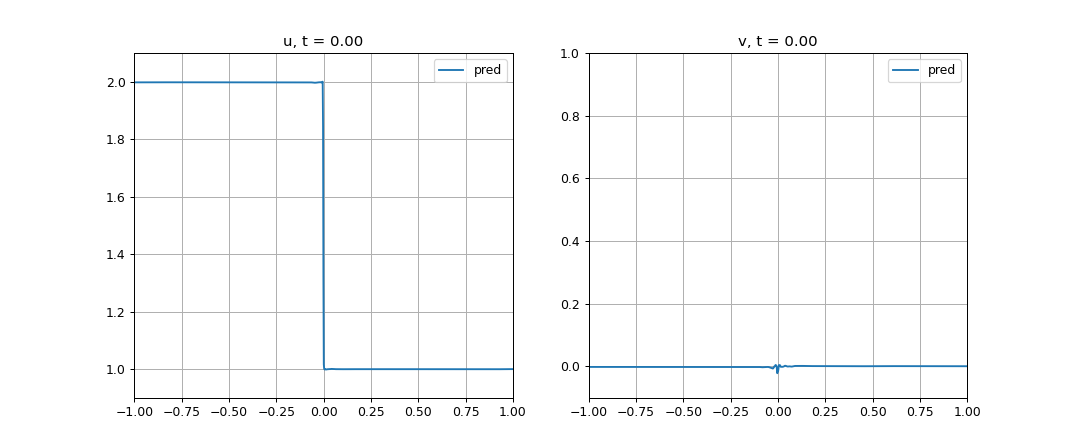

In [19]:
from matplotlib import animation
%matplotlib notebook

fig, ax = plt.subplots(1, 2, figsize = (12, 5))
lines = []
for i in range(2):
    line, = ax[i].plot([], [], lw = 1.5, label = "pred")
    lines.append(line)
    ax[i].set_xlim([-1, 1])
    ax[i].legend()
    ax[i].grid()
ax[0].set_ylim([0.9, 2.1])
ax[1].set_ylim([-0.1, 1.0])
    
def init():
	for line in lines:
		line.set_data([], [])
	return lines

params_ = get_params(opt_state)

x_test = jnp.linspace(*domain[:, 0], 1024)
t_test = jnp.linspace(*domain[:, 1], 501)
xt_tests = [tensor_grid([x_test, ti]) for ti in t_test]
uv_preds = [model(params_, xt_test) for xt_test in xt_tests]
u_preds, v_preds = [uv_pred[:, 0:1] for uv_pred in uv_preds], [uv_pred[:, 1:2] for uv_pred in uv_preds]

def animate(i):
	u_pred, v_pred = u_preds[i], v_preds[i]
# 	u_true, v_true = np.real(uv_true[i, :]), np.imag(uv_true[i, :])
	
	lines[0].set_data(x_test, u_pred)
	ax[0].set_title("u, t = {:.2f}".format(t_test[i]))
    
	lines[1].set_data(x_test, v_pred)
	ax[1].set_title("v, t = {:.2f}".format(t_test[i]))

	return lines

anim = animation.FuncAnimation(fig, animate, frames = len(t_test), interval = 20, blit = True)
plt.show()

In [18]:
start_iteration = 400000
iterations = 3000000
print_every = 500
save_every = 10000
weights = {"c1": 30.0, "c2": epsilon*50, "d": 1000.0, "l1": 1e-9, "l2": 1e-9}

for iteration in range(start_iteration, start_iteration+iterations+1):
	batch = {
		"dirichlet": dataset_Dirichlet(*next(Dirichlet)),
		"collocation": dataset_Collocation(*next(Collocation)),
		"weights": weights,
	}
	opt_state = step(iteration, opt_state, batch)
	if (iteration-start_iteration) % print_every == 0:
		names = ["Loss", "c1", "c2", "d", "l1_reg", "l2_reg"]
		params_ = get_params(opt_state)
		batch = {
			"dirichlet": dataset_Dirichlet(*Dirichlet.dataset),
			"collocation": dataset_Collocation(*Collocation.dataset),
			"weights": weights
		}
		losses = evaluate(params_, batch)
		print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
		hist["iter"].append(iteration)
		hist["loss"].append(losses)
	if (iteration-start_iteration) % save_every == 0:
		params_ = np.asarray(get_params(opt_state), dtype = object)
		save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
		if not os.path.exists(os.path.dirname(save_path)):
			os.makedirs(os.path.dirname(save_path))
		np.save(save_path, params_)

2020/08/22, 01:27:38, Iteration: 400000, Train Loss: 7.3944e+00, c1: 1.6286e-02, c2: 8.0492e+10, d: 2.8813e-03, l1_reg: 7.5404e+02, l2_reg: 8.1647e+02
2020/08/22, 01:27:41, Iteration: 400500, Train Loss: 1.0384e+01, c1: 1.8068e-02, c2: 8.0461e+10, d: 5.8186e-03, l1_reg: 7.5360e+02, l2_reg: 8.1701e+02
2020/08/22, 01:27:45, Iteration: 401000, Train Loss: 7.2979e+00, c1: 1.8818e-02, c2: 7.8607e+10, d: 2.8030e-03, l1_reg: 7.5323e+02, l2_reg: 8.1732e+02
2020/08/22, 01:27:48, Iteration: 401500, Train Loss: 9.9651e+00, c1: 2.0274e-02, c2: 8.0814e+10, d: 5.3162e-03, l1_reg: 7.5334e+02, l2_reg: 8.1779e+02
2020/08/22, 01:27:51, Iteration: 402000, Train Loss: 7.4042e+00, c1: 1.2065e-02, c2: 7.8449e+10, d: 3.1198e-03, l1_reg: 7.5343e+02, l2_reg: 8.1821e+02
2020/08/22, 01:27:54, Iteration: 402500, Train Loss: 9.8635e+00, c1: 1.7773e-02, c2: 8.1072e+10, d: 5.2767e-03, l1_reg: 7.5393e+02, l2_reg: 8.1877e+02
2020/08/22, 01:27:57, Iteration: 403000, Train Loss: 7.1744e+00, c1: 1.4151e-02, c2: 8.0081e+1

2020/08/22, 01:30:27, Iteration: 427500, Train Loss: 8.8953e+00, c1: 1.9361e-02, c2: 7.9096e+10, d: 4.3596e-03, l1_reg: 7.5959e+02, l2_reg: 8.3508e+02
2020/08/22, 01:30:30, Iteration: 428000, Train Loss: 1.0497e+01, c1: 1.9334e-02, c2: 7.7808e+10, d: 6.0263e-03, l1_reg: 7.5950e+02, l2_reg: 8.3542e+02
2020/08/22, 01:30:33, Iteration: 428500, Train Loss: 8.5058e+00, c1: 1.5167e-02, c2: 7.9311e+10, d: 4.0852e-03, l1_reg: 7.5939e+02, l2_reg: 8.3569e+02
2020/08/22, 01:30:36, Iteration: 429000, Train Loss: 9.9553e+00, c1: 1.9400e-02, c2: 7.8137e+10, d: 5.4665e-03, l1_reg: 7.5939e+02, l2_reg: 8.3594e+02
2020/08/22, 01:30:39, Iteration: 429500, Train Loss: 6.5946e+00, c1: 1.3219e-02, c2: 7.7180e+10, d: 2.3391e-03, l1_reg: 7.5919e+02, l2_reg: 8.3628e+02
2020/08/22, 01:30:42, Iteration: 430000, Train Loss: 7.9231e+00, c1: 1.4694e-02, c2: 7.6655e+10, d: 3.6495e-03, l1_reg: 7.6056e+02, l2_reg: 8.3654e+02
2020/08/22, 01:30:45, Iteration: 430500, Train Loss: 6.5742e+00, c1: 1.6866e-02, c2: 7.5058e+1

2020/08/22, 01:33:15, Iteration: 455000, Train Loss: 7.8860e+00, c1: 1.3373e-02, c2: 7.5656e+10, d: 3.7021e-03, l1_reg: 7.6160e+02, l2_reg: 8.4940e+02
2020/08/22, 01:33:18, Iteration: 455500, Train Loss: 8.8838e+00, c1: 2.5469e-02, c2: 7.9985e+10, d: 4.1205e-03, l1_reg: 7.6153e+02, l2_reg: 8.4968e+02
2020/08/22, 01:33:21, Iteration: 456000, Train Loss: 9.9323e+00, c1: 1.7157e-02, c2: 7.6481e+10, d: 5.5935e-03, l1_reg: 7.6161e+02, l2_reg: 8.5011e+02
2020/08/22, 01:33:24, Iteration: 456500, Train Loss: 6.2723e+00, c1: 1.2208e-02, c2: 7.5486e+10, d: 2.1318e-03, l1_reg: 7.6224e+02, l2_reg: 8.5031e+02
2020/08/22, 01:33:27, Iteration: 457000, Train Loss: 6.9366e+00, c1: 2.1256e-02, c2: 7.8347e+10, d: 2.3815e-03, l1_reg: 7.6174e+02, l2_reg: 8.5055e+02
2020/08/22, 01:33:30, Iteration: 457500, Train Loss: 9.4878e+00, c1: 1.5852e-02, c2: 7.9457e+10, d: 5.0394e-03, l1_reg: 7.6190e+02, l2_reg: 8.5096e+02
2020/08/22, 01:33:33, Iteration: 458000, Train Loss: 6.4093e+00, c1: 1.4170e-02, c2: 7.6808e+1

2020/08/22, 01:36:03, Iteration: 482500, Train Loss: 7.1375e+00, c1: 1.5348e-02, c2: 7.5966e+10, d: 2.8788e-03, l1_reg: 7.6677e+02, l2_reg: 8.6353e+02
2020/08/22, 01:36:06, Iteration: 483000, Train Loss: 1.3678e+01, c1: 2.1061e-02, c2: 7.7888e+10, d: 9.1516e-03, l1_reg: 7.6713e+02, l2_reg: 8.6381e+02
2020/08/22, 01:36:09, Iteration: 483500, Train Loss: 9.1679e+00, c1: 2.4143e-02, c2: 7.6190e+10, d: 4.6342e-03, l1_reg: 7.6767e+02, l2_reg: 8.6414e+02
2020/08/22, 01:36:12, Iteration: 484000, Train Loss: 1.0922e+01, c1: 2.6842e-02, c2: 7.6892e+10, d: 6.2721e-03, l1_reg: 7.6715e+02, l2_reg: 8.6418e+02
2020/08/22, 01:36:15, Iteration: 484500, Train Loss: 6.7611e+00, c1: 1.8160e-02, c2: 7.6822e+10, d: 2.3752e-03, l1_reg: 7.6696e+02, l2_reg: 8.6450e+02
2020/08/22, 01:36:18, Iteration: 485000, Train Loss: 8.3594e+00, c1: 1.5453e-02, c2: 7.4495e+10, d: 4.1710e-03, l1_reg: 7.6656e+02, l2_reg: 8.6455e+02
2020/08/22, 01:36:22, Iteration: 485500, Train Loss: 5.8071e+00, c1: 1.5298e-02, c2: 7.5256e+1

2020/08/22, 01:38:51, Iteration: 510000, Train Loss: 8.6446e+00, c1: 2.4241e-02, c2: 7.7382e+10, d: 4.0482e-03, l1_reg: 7.7050e+02, l2_reg: 8.7575e+02
2020/08/22, 01:38:54, Iteration: 510500, Train Loss: 7.8052e+00, c1: 1.2166e-02, c2: 7.4599e+10, d: 3.7103e-03, l1_reg: 7.6965e+02, l2_reg: 8.7601e+02
2020/08/22, 01:38:57, Iteration: 511000, Train Loss: 1.0435e+01, c1: 2.2288e-02, c2: 7.9676e+10, d: 5.7826e-03, l1_reg: 7.7042e+02, l2_reg: 8.7628e+02
2020/08/22, 01:39:00, Iteration: 511500, Train Loss: 6.3129e+00, c1: 1.7559e-02, c2: 7.6933e+10, d: 1.9395e-03, l1_reg: 7.6994e+02, l2_reg: 8.7644e+02
2020/08/22, 01:39:03, Iteration: 512000, Train Loss: 9.1109e+00, c1: 1.9818e-02, c2: 7.6787e+10, d: 4.6770e-03, l1_reg: 7.6971e+02, l2_reg: 8.7668e+02
2020/08/22, 01:39:06, Iteration: 512500, Train Loss: 6.7353e+00, c1: 1.8301e-02, c2: 7.6199e+10, d: 2.3763e-03, l1_reg: 7.6942e+02, l2_reg: 8.7685e+02
2020/08/22, 01:39:09, Iteration: 513000, Train Loss: 9.7545e+00, c1: 2.0129e-02, c2: 7.6396e+1

2020/08/22, 01:41:38, Iteration: 537500, Train Loss: 9.8758e+00, c1: 2.1365e-02, c2: 7.5318e+10, d: 5.4690e-03, l1_reg: 7.7166e+02, l2_reg: 8.8796e+02
2020/08/22, 01:41:42, Iteration: 538000, Train Loss: 9.0712e+00, c1: 1.6674e-02, c2: 7.8368e+10, d: 4.6526e-03, l1_reg: 7.7193e+02, l2_reg: 8.8805e+02
2020/08/22, 01:41:45, Iteration: 538500, Train Loss: 8.9988e+00, c1: 2.1395e-02, c2: 7.6118e+10, d: 4.5511e-03, l1_reg: 7.7198e+02, l2_reg: 8.8807e+02
2020/08/22, 01:41:48, Iteration: 539000, Train Loss: 7.0158e+00, c1: 1.5510e-02, c2: 7.5108e+10, d: 2.7951e-03, l1_reg: 7.7148e+02, l2_reg: 8.8822e+02
2020/08/22, 01:41:51, Iteration: 539500, Train Loss: 7.6939e+00, c1: 1.6939e-02, c2: 7.5156e+10, d: 3.4279e-03, l1_reg: 7.7193e+02, l2_reg: 8.8841e+02
2020/08/22, 01:41:54, Iteration: 540000, Train Loss: 7.0796e+00, c1: 1.6983e-02, c2: 7.4729e+10, d: 2.8337e-03, l1_reg: 7.7199e+02, l2_reg: 8.8846e+02
2020/08/22, 01:41:57, Iteration: 540500, Train Loss: 6.2087e+00, c1: 1.3321e-02, c2: 7.4732e+1

2020/08/22, 01:44:27, Iteration: 565000, Train Loss: 8.7854e+00, c1: 1.5848e-02, c2: 7.6224e+10, d: 4.4987e-03, l1_reg: 7.7274e+02, l2_reg: 8.9833e+02
2020/08/22, 01:44:30, Iteration: 565500, Train Loss: 7.1776e+00, c1: 1.8561e-02, c2: 7.4881e+10, d: 2.8767e-03, l1_reg: 7.7229e+02, l2_reg: 8.9846e+02
2020/08/22, 01:44:33, Iteration: 566000, Train Loss: 1.1785e+01, c1: 1.7877e-02, c2: 8.2522e+10, d: 7.1226e-03, l1_reg: 7.7232e+02, l2_reg: 8.9867e+02
2020/08/22, 01:44:36, Iteration: 566500, Train Loss: 5.3724e+00, c1: 1.3299e-02, c2: 7.5201e+10, d: 1.2134e-03, l1_reg: 7.7248e+02, l2_reg: 8.9903e+02
2020/08/22, 01:44:39, Iteration: 567000, Train Loss: 6.9234e+00, c1: 1.6552e-02, c2: 7.4478e+10, d: 2.7030e-03, l1_reg: 7.7253e+02, l2_reg: 8.9931e+02
2020/08/22, 01:44:42, Iteration: 567500, Train Loss: 7.9920e+00, c1: 1.4531e-02, c2: 7.4974e+10, d: 3.8074e-03, l1_reg: 7.7256e+02, l2_reg: 8.9944e+02
2020/08/22, 01:44:45, Iteration: 568000, Train Loss: 9.0232e+00, c1: 1.8745e-02, c2: 7.4905e+1

2020/08/22, 01:47:14, Iteration: 592500, Train Loss: 7.5106e+00, c1: 1.9464e-02, c2: 7.4467e+10, d: 3.2034e-03, l1_reg: 7.6862e+02, l2_reg: 9.0708e+02
2020/08/22, 01:47:17, Iteration: 593000, Train Loss: 7.6616e+00, c1: 1.8330e-02, c2: 7.5362e+10, d: 3.3436e-03, l1_reg: 7.6931e+02, l2_reg: 9.0715e+02
2020/08/22, 01:47:20, Iteration: 593500, Train Loss: 8.2653e+00, c1: 2.0000e-02, c2: 7.5707e+10, d: 3.8799e-03, l1_reg: 7.6862e+02, l2_reg: 9.0752e+02
2020/08/22, 01:47:23, Iteration: 594000, Train Loss: 9.5570e+00, c1: 1.9535e-02, c2: 7.4827e+10, d: 5.2296e-03, l1_reg: 7.6875e+02, l2_reg: 9.0764e+02
2020/08/22, 01:47:26, Iteration: 594500, Train Loss: 6.6126e+00, c1: 1.9765e-02, c2: 7.3639e+10, d: 2.3377e-03, l1_reg: 7.7033e+02, l2_reg: 9.0817e+02
2020/08/22, 01:47:29, Iteration: 595000, Train Loss: 8.7966e+00, c1: 1.4924e-02, c2: 7.5927e+10, d: 4.5525e-03, l1_reg: 7.6943e+02, l2_reg: 9.0830e+02
2020/08/22, 01:47:33, Iteration: 595500, Train Loss: 1.0382e+01, c1: 1.3389e-02, c2: 7.8022e+1

2020/08/22, 01:50:02, Iteration: 620000, Train Loss: 8.6594e+00, c1: 1.7480e-02, c2: 7.4863e+10, d: 4.3918e-03, l1_reg: 7.7017e+02, l2_reg: 9.1715e+02
2020/08/22, 01:50:05, Iteration: 620500, Train Loss: 6.7351e+00, c1: 1.9792e-02, c2: 7.3623e+10, d: 2.4602e-03, l1_reg: 7.7058e+02, l2_reg: 9.1736e+02
2020/08/22, 01:50:09, Iteration: 621000, Train Loss: 1.0008e+01, c1: 2.1178e-02, c2: 7.4247e+10, d: 5.6600e-03, l1_reg: 7.7018e+02, l2_reg: 9.1748e+02
2020/08/22, 01:50:12, Iteration: 621500, Train Loss: 9.2795e+00, c1: 1.4196e-02, c2: 7.3899e+10, d: 5.1587e-03, l1_reg: 7.6981e+02, l2_reg: 9.1782e+02
2020/08/22, 01:50:15, Iteration: 622000, Train Loss: 6.4736e+00, c1: 1.2001e-02, c2: 7.3003e+10, d: 2.4634e-03, l1_reg: 7.7090e+02, l2_reg: 9.1798e+02
2020/08/22, 01:50:18, Iteration: 622500, Train Loss: 7.7927e+00, c1: 1.7355e-02, c2: 7.4195e+10, d: 3.5623e-03, l1_reg: 7.7004e+02, l2_reg: 9.1812e+02
2020/08/22, 01:50:21, Iteration: 623000, Train Loss: 7.8280e+00, c1: 1.4741e-02, c2: 7.3803e+1

2020/08/22, 01:52:50, Iteration: 647500, Train Loss: 9.0183e+00, c1: 2.0465e-02, c2: 7.4582e+10, d: 4.6752e-03, l1_reg: 7.6847e+02, l2_reg: 9.2540e+02
2020/08/22, 01:52:54, Iteration: 648000, Train Loss: 1.0646e+01, c1: 1.8138e-02, c2: 7.4639e+10, d: 6.3696e-03, l1_reg: 7.6963e+02, l2_reg: 9.2553e+02
2020/08/22, 01:52:56, Iteration: 648500, Train Loss: 6.4446e+00, c1: 2.0468e-02, c2: 7.3409e+10, d: 2.1601e-03, l1_reg: 7.6858e+02, l2_reg: 9.2550e+02
2020/08/22, 01:53:00, Iteration: 649000, Train Loss: 1.0384e+01, c1: 2.1021e-02, c2: 7.7555e+10, d: 5.8758e-03, l1_reg: 7.6811e+02, l2_reg: 9.2588e+02
2020/08/22, 01:53:03, Iteration: 649500, Train Loss: 8.3358e+00, c1: 1.5472e-02, c2: 7.4382e+10, d: 4.1525e-03, l1_reg: 7.6833e+02, l2_reg: 9.2586e+02
2020/08/22, 01:53:06, Iteration: 650000, Train Loss: 8.2261e+00, c1: 1.7108e-02, c2: 7.7309e+10, d: 3.8474e-03, l1_reg: 7.6943e+02, l2_reg: 9.2606e+02
2020/08/22, 01:53:09, Iteration: 650500, Train Loss: 8.1934e+00, c1: 1.5184e-02, c2: 7.4698e+1

2020/08/22, 01:55:38, Iteration: 675000, Train Loss: 9.1898e+00, c1: 1.7534e-02, c2: 7.4122e+10, d: 4.9577e-03, l1_reg: 7.6995e+02, l2_reg: 9.3448e+02
2020/08/22, 01:55:41, Iteration: 675500, Train Loss: 9.5888e+00, c1: 1.3168e-02, c2: 7.3509e+10, d: 5.5183e-03, l1_reg: 7.6889e+02, l2_reg: 9.3466e+02
2020/08/22, 01:55:45, Iteration: 676000, Train Loss: 8.6995e+00, c1: 2.2202e-02, c2: 7.2976e+10, d: 4.3846e-03, l1_reg: 7.6873e+02, l2_reg: 9.3469e+02
2020/08/22, 01:55:48, Iteration: 676500, Train Loss: 7.0134e+00, c1: 1.9616e-02, c2: 7.3718e+10, d: 2.7390e-03, l1_reg: 7.6904e+02, l2_reg: 9.3486e+02
2020/08/22, 01:55:51, Iteration: 677000, Train Loss: 9.0213e+00, c1: 2.2209e-02, c2: 7.3795e+10, d: 4.6653e-03, l1_reg: 7.6864e+02, l2_reg: 9.3512e+02
2020/08/22, 01:55:54, Iteration: 677500, Train Loss: 8.2989e+00, c1: 1.7951e-02, c2: 7.3233e+10, d: 4.0987e-03, l1_reg: 7.6996e+02, l2_reg: 9.3546e+02
2020/08/22, 01:55:57, Iteration: 678000, Train Loss: 8.2109e+00, c1: 1.7003e-02, c2: 7.3084e+1

2020/08/22, 01:58:26, Iteration: 702500, Train Loss: 7.3477e+00, c1: 1.1910e-02, c2: 7.3418e+10, d: 3.3195e-03, l1_reg: 7.7144e+02, l2_reg: 9.4345e+02
2020/08/22, 01:58:29, Iteration: 703000, Train Loss: 8.9204e+00, c1: 1.8945e-02, c2: 7.4270e+10, d: 4.6385e-03, l1_reg: 7.7069e+02, l2_reg: 9.4347e+02
2020/08/22, 01:58:32, Iteration: 703500, Train Loss: 6.7690e+00, c1: 2.0176e-02, c2: 7.3226e+10, d: 2.5024e-03, l1_reg: 7.7121e+02, l2_reg: 9.4352e+02
2020/08/22, 01:58:35, Iteration: 704000, Train Loss: 5.4786e+00, c1: 1.5899e-02, c2: 7.2875e+10, d: 1.3578e-03, l1_reg: 7.7090e+02, l2_reg: 9.4365e+02
2020/08/22, 01:58:38, Iteration: 704500, Train Loss: 8.9133e+00, c1: 1.9576e-02, c2: 7.5840e+10, d: 4.5340e-03, l1_reg: 7.7036e+02, l2_reg: 9.4398e+02
2020/08/22, 01:58:41, Iteration: 705000, Train Loss: 7.2485e+00, c1: 1.1861e-02, c2: 7.3565e+10, d: 3.2144e-03, l1_reg: 7.7054e+02, l2_reg: 9.4431e+02
2020/08/22, 01:58:43, Iteration: 705500, Train Loss: 1.3632e+01, c1: 2.6299e-02, c2: 7.8128e+1

2020/08/22, 02:01:12, Iteration: 730000, Train Loss: 9.1726e+00, c1: 2.7019e-02, c2: 7.5006e+10, d: 4.6118e-03, l1_reg: 7.7186e+02, l2_reg: 9.5195e+02
2020/08/22, 02:01:16, Iteration: 730500, Train Loss: 1.2093e+01, c1: 3.0052e-02, c2: 8.0167e+10, d: 7.1827e-03, l1_reg: 7.7229e+02, l2_reg: 9.5241e+02
2020/08/22, 02:01:19, Iteration: 731000, Train Loss: 1.1017e+01, c1: 2.8795e-02, c2: 7.6595e+10, d: 6.3233e-03, l1_reg: 7.7212e+02, l2_reg: 9.5245e+02
2020/08/22, 02:01:22, Iteration: 731500, Train Loss: 9.8772e+00, c1: 1.8574e-02, c2: 7.6572e+10, d: 5.4913e-03, l1_reg: 7.7214e+02, l2_reg: 9.5258e+02
2020/08/22, 02:01:25, Iteration: 732000, Train Loss: 8.2672e+00, c1: 1.6410e-02, c2: 7.5705e+10, d: 3.9896e-03, l1_reg: 7.7445e+02, l2_reg: 9.5290e+02
2020/08/22, 02:01:28, Iteration: 732500, Train Loss: 7.8740e+00, c1: 1.4477e-02, c2: 7.3721e+10, d: 3.7537e-03, l1_reg: 7.7369e+02, l2_reg: 9.5308e+02
2020/08/22, 02:01:31, Iteration: 733000, Train Loss: 8.0009e+00, c1: 1.6694e-02, c2: 7.5225e+1

2020/08/22, 02:04:01, Iteration: 757500, Train Loss: 6.3911e+00, c1: 1.7318e-02, c2: 7.4498e+10, d: 2.1467e-03, l1_reg: 7.7176e+02, l2_reg: 9.5922e+02
2020/08/22, 02:04:04, Iteration: 758000, Train Loss: 1.2566e+01, c1: 1.8059e-02, c2: 7.3829e+10, d: 8.3326e-03, l1_reg: 7.7213e+02, l2_reg: 9.5905e+02
2020/08/22, 02:04:07, Iteration: 758500, Train Loss: 1.2863e+01, c1: 2.4486e-02, c2: 7.3772e+10, d: 8.4393e-03, l1_reg: 7.7246e+02, l2_reg: 9.5935e+02
2020/08/22, 02:04:10, Iteration: 759000, Train Loss: 6.8612e+00, c1: 1.6004e-02, c2: 7.3154e+10, d: 2.7234e-03, l1_reg: 7.7329e+02, l2_reg: 9.5948e+02
2020/08/22, 02:04:13, Iteration: 759500, Train Loss: 9.3418e+00, c1: 1.8795e-02, c2: 7.4688e+10, d: 5.0435e-03, l1_reg: 7.7177e+02, l2_reg: 9.5961e+02
2020/08/22, 02:04:16, Iteration: 760000, Train Loss: 1.1807e+01, c1: 2.2747e-02, c2: 7.6377e+10, d: 7.3062e-03, l1_reg: 7.7118e+02, l2_reg: 9.5950e+02
2020/08/22, 02:04:19, Iteration: 760500, Train Loss: 6.5503e+00, c1: 2.0816e-02, c2: 7.3328e+1

2020/08/22, 02:06:49, Iteration: 785000, Train Loss: 7.6243e+00, c1: 1.8451e-02, c2: 7.3386e+10, d: 3.4015e-03, l1_reg: 7.7164e+02, l2_reg: 9.6672e+02
2020/08/22, 02:06:52, Iteration: 785500, Train Loss: 6.8454e+00, c1: 2.0631e-02, c2: 7.1067e+10, d: 2.6732e-03, l1_reg: 7.7273e+02, l2_reg: 9.6665e+02
2020/08/22, 02:06:55, Iteration: 786000, Train Loss: 6.1027e+00, c1: 1.6911e-02, c2: 7.2035e+10, d: 1.9937e-03, l1_reg: 7.7175e+02, l2_reg: 9.6669e+02
2020/08/22, 02:06:58, Iteration: 786500, Train Loss: 7.3535e+00, c1: 1.8401e-02, c2: 7.4234e+10, d: 3.0898e-03, l1_reg: 7.7130e+02, l2_reg: 9.6672e+02
2020/08/22, 02:07:01, Iteration: 787000, Train Loss: 9.6550e+00, c1: 1.7881e-02, c2: 7.2619e+10, d: 5.4876e-03, l1_reg: 7.7145e+02, l2_reg: 9.6687e+02
2020/08/22, 02:07:04, Iteration: 787500, Train Loss: 1.0770e+01, c1: 2.0218e-02, c2: 7.4758e+10, d: 6.4255e-03, l1_reg: 7.7199e+02, l2_reg: 9.6714e+02
2020/08/22, 02:07:07, Iteration: 788000, Train Loss: 7.1601e+00, c1: 1.5728e-02, c2: 7.2789e+1

2020/08/22, 02:09:38, Iteration: 812500, Train Loss: 1.1757e+01, c1: 1.4277e-02, c2: 7.4834e+10, d: 7.5866e-03, l1_reg: 7.7472e+02, l2_reg: 9.7393e+02
2020/08/22, 02:09:42, Iteration: 813000, Train Loss: 8.7731e+00, c1: 1.6363e-02, c2: 7.5394e+10, d: 4.5125e-03, l1_reg: 7.7449e+02, l2_reg: 9.7393e+02
2020/08/22, 02:09:45, Iteration: 813500, Train Loss: 7.2351e+00, c1: 2.0424e-02, c2: 7.1896e+10, d: 3.0276e-03, l1_reg: 7.7380e+02, l2_reg: 9.7417e+02
2020/08/22, 02:09:48, Iteration: 814000, Train Loss: 1.0461e+01, c1: 1.6824e-02, c2: 7.4806e+10, d: 6.2162e-03, l1_reg: 7.7503e+02, l2_reg: 9.7425e+02
2020/08/22, 02:09:51, Iteration: 814500, Train Loss: 6.2628e+00, c1: 1.4328e-02, c2: 7.3029e+10, d: 2.1815e-03, l1_reg: 7.7463e+02, l2_reg: 9.7448e+02
2020/08/22, 02:09:54, Iteration: 815000, Train Loss: 7.4637e+00, c1: 2.0190e-02, c2: 7.3412e+10, d: 3.1874e-03, l1_reg: 7.7403e+02, l2_reg: 9.7471e+02
2020/08/22, 02:09:57, Iteration: 815500, Train Loss: 8.1166e+00, c1: 1.5006e-02, c2: 7.2275e+1

2020/08/22, 02:12:26, Iteration: 840000, Train Loss: 6.2020e+00, c1: 1.8183e-02, c2: 7.1906e+10, d: 2.0612e-03, l1_reg: 7.7678e+02, l2_reg: 9.8124e+02
2020/08/22, 02:12:29, Iteration: 840500, Train Loss: 6.2711e+00, c1: 1.6119e-02, c2: 7.2805e+10, d: 2.1473e-03, l1_reg: 7.7624e+02, l2_reg: 9.8152e+02
2020/08/22, 02:12:33, Iteration: 841000, Train Loss: 6.8208e+00, c1: 1.3638e-02, c2: 7.3600e+10, d: 2.7317e-03, l1_reg: 7.7653e+02, l2_reg: 9.8148e+02
2020/08/22, 02:12:36, Iteration: 841500, Train Loss: 1.2382e+01, c1: 1.5320e-02, c2: 7.6569e+10, d: 8.0937e-03, l1_reg: 7.7589e+02, l2_reg: 9.8155e+02
2020/08/22, 02:12:39, Iteration: 842000, Train Loss: 7.5313e+00, c1: 1.5664e-02, c2: 7.2987e+10, d: 3.4120e-03, l1_reg: 7.7644e+02, l2_reg: 9.8183e+02
2020/08/22, 02:12:42, Iteration: 842500, Train Loss: 8.8622e+00, c1: 1.4871e-02, c2: 7.3126e+10, d: 4.7598e-03, l1_reg: 7.7736e+02, l2_reg: 9.8199e+02
2020/08/22, 02:12:45, Iteration: 843000, Train Loss: 8.0886e+00, c1: 2.0736e-02, c2: 7.3259e+1

2020/08/22, 02:15:15, Iteration: 867500, Train Loss: 6.9333e+00, c1: 1.5422e-02, c2: 7.3498e+10, d: 2.7957e-03, l1_reg: 7.7919e+02, l2_reg: 9.8860e+02
2020/08/22, 02:15:18, Iteration: 868000, Train Loss: 5.7819e+00, c1: 1.6396e-02, c2: 7.3604e+10, d: 1.6098e-03, l1_reg: 7.7903e+02, l2_reg: 9.8883e+02
2020/08/22, 02:15:21, Iteration: 868500, Train Loss: 6.7436e+00, c1: 1.5875e-02, c2: 7.4133e+10, d: 2.5607e-03, l1_reg: 7.7986e+02, l2_reg: 9.8891e+02
2020/08/22, 02:15:24, Iteration: 869000, Train Loss: 1.0303e+01, c1: 2.1349e-02, c2: 7.3611e+10, d: 5.9818e-03, l1_reg: 7.7965e+02, l2_reg: 9.8901e+02
2020/08/22, 02:15:27, Iteration: 869500, Train Loss: 7.1451e+00, c1: 1.3475e-02, c2: 7.3037e+10, d: 3.0890e-03, l1_reg: 7.7912e+02, l2_reg: 9.8905e+02
2020/08/22, 02:15:30, Iteration: 870000, Train Loss: 1.1060e+01, c1: 2.4522e-02, c2: 7.3155e+10, d: 6.6666e-03, l1_reg: 7.7875e+02, l2_reg: 9.8918e+02
2020/08/22, 02:15:33, Iteration: 870500, Train Loss: 8.1083e+00, c1: 1.9369e-02, c2: 7.3394e+1

2020/08/22, 02:18:03, Iteration: 895000, Train Loss: 7.9971e+00, c1: 1.4375e-02, c2: 7.2898e+10, d: 3.9209e-03, l1_reg: 7.8217e+02, l2_reg: 9.9547e+02
2020/08/22, 02:18:06, Iteration: 895500, Train Loss: 5.8828e+00, c1: 1.6210e-02, c2: 7.1683e+10, d: 1.8123e-03, l1_reg: 7.8120e+02, l2_reg: 9.9553e+02
2020/08/22, 02:18:10, Iteration: 896000, Train Loss: 7.6091e+00, c1: 1.6770e-02, c2: 7.4952e+10, d: 3.3584e-03, l1_reg: 7.8104e+02, l2_reg: 9.9576e+02
2020/08/22, 02:18:13, Iteration: 896500, Train Loss: 9.8430e+00, c1: 1.5485e-02, c2: 7.2175e+10, d: 5.7697e-03, l1_reg: 7.8127e+02, l2_reg: 9.9581e+02
2020/08/22, 02:18:16, Iteration: 897000, Train Loss: 7.3646e+00, c1: 1.3828e-02, c2: 7.4607e+10, d: 3.2194e-03, l1_reg: 7.8244e+02, l2_reg: 9.9587e+02
2020/08/22, 02:18:19, Iteration: 897500, Train Loss: 8.8965e+00, c1: 2.1883e-02, c2: 7.5071e+10, d: 4.4864e-03, l1_reg: 7.8243e+02, l2_reg: 9.9590e+02
2020/08/22, 02:18:22, Iteration: 898000, Train Loss: 6.6923e+00, c1: 1.4810e-02, c2: 7.1631e+1

2020/08/22, 02:20:52, Iteration: 922500, Train Loss: 9.3003e+00, c1: 2.0923e-02, c2: 7.2152e+10, d: 5.0650e-03, l1_reg: 7.8314e+02, l2_reg: 1.0012e+03
2020/08/22, 02:20:55, Iteration: 923000, Train Loss: 7.0309e+00, c1: 1.3711e-02, c2: 7.2474e+10, d: 2.9958e-03, l1_reg: 7.8263e+02, l2_reg: 1.0013e+03
2020/08/22, 02:20:58, Iteration: 923500, Train Loss: 7.1184e+00, c1: 1.3981e-02, c2: 7.2086e+10, d: 3.0946e-03, l1_reg: 7.8190e+02, l2_reg: 1.0014e+03
2020/08/22, 02:21:01, Iteration: 924000, Train Loss: 8.8163e+00, c1: 1.6553e-02, c2: 7.4411e+10, d: 4.5992e-03, l1_reg: 7.8128e+02, l2_reg: 1.0013e+03
2020/08/22, 02:21:04, Iteration: 924500, Train Loss: 8.7169e+00, c1: 1.7694e-02, c2: 7.1807e+10, d: 4.5957e-03, l1_reg: 7.8222e+02, l2_reg: 1.0012e+03
2020/08/22, 02:21:07, Iteration: 925000, Train Loss: 9.4371e+00, c1: 2.4810e-02, c2: 7.1900e+10, d: 5.0978e-03, l1_reg: 7.8150e+02, l2_reg: 1.0013e+03
2020/08/22, 02:21:10, Iteration: 925500, Train Loss: 8.4725e+00, c1: 1.3992e-02, c2: 7.2911e+1

2020/08/22, 02:23:42, Iteration: 950000, Train Loss: 7.7184e+00, c1: 1.5993e-02, c2: 7.4628e+10, d: 3.5072e-03, l1_reg: 7.7743e+02, l2_reg: 1.0057e+03
2020/08/22, 02:23:45, Iteration: 950500, Train Loss: 9.4937e+00, c1: 1.7912e-02, c2: 7.4347e+10, d: 5.2390e-03, l1_reg: 7.7738e+02, l2_reg: 1.0056e+03
2020/08/22, 02:23:48, Iteration: 951000, Train Loss: 1.0457e+01, c1: 1.9135e-02, c2: 7.6881e+10, d: 6.0387e-03, l1_reg: 7.7907e+02, l2_reg: 1.0057e+03
2020/08/22, 02:23:51, Iteration: 951500, Train Loss: 6.8421e+00, c1: 1.6248e-02, c2: 7.2559e+10, d: 2.7268e-03, l1_reg: 7.7828e+02, l2_reg: 1.0059e+03
2020/08/22, 02:23:54, Iteration: 952000, Train Loss: 6.5333e+00, c1: 1.5940e-02, c2: 7.2395e+10, d: 2.4354e-03, l1_reg: 7.7775e+02, l2_reg: 1.0060e+03
2020/08/22, 02:23:57, Iteration: 952500, Train Loss: 7.1583e+00, c1: 1.5865e-02, c2: 7.1077e+10, d: 3.1285e-03, l1_reg: 7.7781e+02, l2_reg: 1.0063e+03
2020/08/22, 02:24:00, Iteration: 953000, Train Loss: 6.9811e+00, c1: 1.3792e-02, c2: 7.2715e+1

2020/08/22, 02:26:31, Iteration: 977500, Train Loss: 9.1098e+00, c1: 1.7132e-02, c2: 7.3702e+10, d: 4.9108e-03, l1_reg: 7.8132e+02, l2_reg: 1.0135e+03
2020/08/22, 02:26:34, Iteration: 978000, Train Loss: 7.6121e+00, c1: 1.4191e-02, c2: 7.1909e+10, d: 3.5910e-03, l1_reg: 7.8031e+02, l2_reg: 1.0136e+03
2020/08/22, 02:26:37, Iteration: 978500, Train Loss: 9.3020e+00, c1: 1.8548e-02, c2: 7.4343e+10, d: 5.0284e-03, l1_reg: 7.8397e+02, l2_reg: 1.0140e+03
2020/08/22, 02:26:40, Iteration: 979000, Train Loss: 1.1341e+01, c1: 1.6314e-02, c2: 7.3982e+10, d: 7.1530e-03, l1_reg: 7.8233e+02, l2_reg: 1.0143e+03
2020/08/22, 02:26:43, Iteration: 979500, Train Loss: 8.4989e+00, c1: 1.2224e-02, c2: 7.3479e+10, d: 4.4583e-03, l1_reg: 7.8181e+02, l2_reg: 1.0143e+03
2020/08/22, 02:26:46, Iteration: 980000, Train Loss: 8.8895e+00, c1: 1.8317e-02, c2: 7.2013e+10, d: 4.7393e-03, l1_reg: 7.8207e+02, l2_reg: 1.0143e+03
2020/08/22, 02:26:49, Iteration: 980500, Train Loss: 6.6329e+00, c1: 1.5394e-02, c2: 7.2036e+1

2020/08/22, 02:29:19, Iteration: 1005000, Train Loss: 8.9497e+00, c1: 1.8125e-02, c2: 7.3523e+10, d: 4.7298e-03, l1_reg: 7.8293e+02, l2_reg: 1.0208e+03
2020/08/22, 02:29:22, Iteration: 1005500, Train Loss: 5.9842e+00, c1: 1.4941e-02, c2: 7.2152e+10, d: 1.9284e-03, l1_reg: 7.8274e+02, l2_reg: 1.0210e+03
2020/08/22, 02:29:25, Iteration: 1006000, Train Loss: 7.5792e+00, c1: 1.5841e-02, c2: 7.1888e+10, d: 3.5096e-03, l1_reg: 7.8321e+02, l2_reg: 1.0212e+03
2020/08/22, 02:29:28, Iteration: 1006500, Train Loss: 7.7900e+00, c1: 1.8443e-02, c2: 7.2206e+10, d: 3.6264e-03, l1_reg: 7.8321e+02, l2_reg: 1.0211e+03
2020/08/22, 02:29:31, Iteration: 1007000, Train Loss: 1.2138e+01, c1: 1.9834e-02, c2: 7.4272e+10, d: 7.8297e-03, l1_reg: 7.8244e+02, l2_reg: 1.0213e+03
2020/08/22, 02:29:34, Iteration: 1007500, Train Loss: 8.9050e+00, c1: 1.4974e-02, c2: 7.5566e+10, d: 4.6775e-03, l1_reg: 7.8276e+02, l2_reg: 1.0214e+03
2020/08/22, 02:29:37, Iteration: 1008000, Train Loss: 6.8565e+00, c1: 1.3212e-02, c2: 7.

2020/08/22, 02:32:03, Iteration: 1032000, Train Loss: 7.8890e+00, c1: 1.3080e-02, c2: 7.1788e+10, d: 3.9072e-03, l1_reg: 7.8362e+02, l2_reg: 1.0276e+03
2020/08/22, 02:32:06, Iteration: 1032500, Train Loss: 9.7448e+00, c1: 1.7852e-02, c2: 7.3125e+10, d: 5.5530e-03, l1_reg: 7.8499e+02, l2_reg: 1.0277e+03
2020/08/22, 02:32:09, Iteration: 1033000, Train Loss: 7.1202e+00, c1: 1.8098e-02, c2: 7.1878e+10, d: 2.9834e-03, l1_reg: 7.8366e+02, l2_reg: 1.0278e+03
2020/08/22, 02:32:12, Iteration: 1033500, Train Loss: 8.0000e+00, c1: 1.7029e-02, c2: 7.2619e+10, d: 3.8582e-03, l1_reg: 7.8375e+02, l2_reg: 1.0279e+03
2020/08/22, 02:32:16, Iteration: 1034000, Train Loss: 7.1561e+00, c1: 1.7954e-02, c2: 7.2022e+10, d: 3.0164e-03, l1_reg: 7.8340e+02, l2_reg: 1.0280e+03
2020/08/22, 02:32:19, Iteration: 1034500, Train Loss: 5.8137e+00, c1: 1.6965e-02, c2: 7.1252e+10, d: 1.7421e-03, l1_reg: 7.8340e+02, l2_reg: 1.0282e+03
2020/08/22, 02:32:22, Iteration: 1035000, Train Loss: 7.9906e+00, c1: 1.6651e-02, c2: 7.

2020/08/22, 02:34:48, Iteration: 1059000, Train Loss: 1.2174e+01, c1: 2.1682e-02, c2: 7.5400e+10, d: 7.7536e-03, l1_reg: 7.8774e+02, l2_reg: 1.0348e+03
2020/08/22, 02:34:51, Iteration: 1059500, Train Loss: 7.7752e+00, c1: 1.4622e-02, c2: 7.1040e+10, d: 3.7845e-03, l1_reg: 7.8571e+02, l2_reg: 1.0350e+03
2020/08/22, 02:34:54, Iteration: 1060000, Train Loss: 5.3409e+00, c1: 1.3282e-02, c2: 7.0884e+10, d: 1.3983e-03, l1_reg: 7.8632e+02, l2_reg: 1.0352e+03
2020/08/22, 02:34:57, Iteration: 1060500, Train Loss: 7.5125e+00, c1: 1.5253e-02, c2: 7.3849e+10, d: 3.3624e-03, l1_reg: 7.8452e+02, l2_reg: 1.0352e+03
2020/08/22, 02:35:00, Iteration: 1061000, Train Loss: 9.2729e+00, c1: 1.8684e-02, c2: 7.2086e+10, d: 5.1082e-03, l1_reg: 7.8660e+02, l2_reg: 1.0353e+03
2020/08/22, 02:35:03, Iteration: 1061500, Train Loss: 1.3448e+01, c1: 1.9313e-02, c2: 7.4517e+10, d: 9.1429e-03, l1_reg: 7.8380e+02, l2_reg: 1.0353e+03
2020/08/22, 02:35:06, Iteration: 1062000, Train Loss: 1.1337e+01, c1: 1.4856e-02, c2: 7.

2020/08/22, 02:37:33, Iteration: 1086000, Train Loss: 1.0178e+01, c1: 2.4168e-02, c2: 7.8436e+10, d: 5.5312e-03, l1_reg: 7.8791e+02, l2_reg: 1.0428e+03
2020/08/22, 02:37:36, Iteration: 1086500, Train Loss: 6.7423e+00, c1: 1.7302e-02, c2: 7.2119e+10, d: 2.6173e-03, l1_reg: 7.8643e+02, l2_reg: 1.0429e+03
2020/08/22, 02:37:39, Iteration: 1087000, Train Loss: 7.4920e+00, c1: 2.2047e-02, c2: 7.1912e+10, d: 3.2350e-03, l1_reg: 7.8702e+02, l2_reg: 1.0428e+03
2020/08/22, 02:37:42, Iteration: 1087500, Train Loss: 1.0630e+01, c1: 2.1206e-02, c2: 7.1924e+10, d: 6.3981e-03, l1_reg: 7.8766e+02, l2_reg: 1.0432e+03
2020/08/22, 02:37:45, Iteration: 1088000, Train Loss: 9.2185e+00, c1: 1.5262e-02, c2: 7.3059e+10, d: 5.1076e-03, l1_reg: 7.8728e+02, l2_reg: 1.0434e+03
2020/08/22, 02:37:48, Iteration: 1088500, Train Loss: 8.6067e+00, c1: 2.7675e-02, c2: 7.2994e+10, d: 4.1268e-03, l1_reg: 7.8673e+02, l2_reg: 1.0434e+03
2020/08/22, 02:37:51, Iteration: 1089000, Train Loss: 1.3449e+01, c1: 2.8485e-02, c2: 7.

2020/08/22, 02:40:17, Iteration: 1113000, Train Loss: 6.3444e+00, c1: 1.1637e-02, c2: 7.1562e+10, d: 2.4172e-03, l1_reg: 7.9021e+02, l2_reg: 1.0504e+03
2020/08/22, 02:40:20, Iteration: 1113500, Train Loss: 9.6634e+00, c1: 2.1767e-02, c2: 7.5839e+10, d: 5.2184e-03, l1_reg: 7.9171e+02, l2_reg: 1.0509e+03
2020/08/22, 02:40:23, Iteration: 1114000, Train Loss: 7.3850e+00, c1: 1.3538e-02, c2: 7.3081e+10, d: 3.3248e-03, l1_reg: 7.9028e+02, l2_reg: 1.0511e+03
2020/08/22, 02:40:26, Iteration: 1114500, Train Loss: 8.3875e+00, c1: 1.9120e-02, c2: 7.6301e+10, d: 3.9989e-03, l1_reg: 7.8977e+02, l2_reg: 1.0511e+03
2020/08/22, 02:40:29, Iteration: 1115000, Train Loss: 7.1219e+00, c1: 1.4553e-02, c2: 7.1041e+10, d: 3.1333e-03, l1_reg: 7.9060e+02, l2_reg: 1.0513e+03
2020/08/22, 02:40:32, Iteration: 1115500, Train Loss: 7.6797e+00, c1: 2.1448e-02, c2: 7.3664e+10, d: 3.3530e-03, l1_reg: 7.9010e+02, l2_reg: 1.0512e+03
2020/08/22, 02:40:35, Iteration: 1116000, Train Loss: 1.0848e+01, c1: 1.3272e-02, c2: 7.

2020/08/22, 02:43:02, Iteration: 1140000, Train Loss: 8.7191e+00, c1: 2.0193e-02, c2: 7.1893e+10, d: 4.5187e-03, l1_reg: 7.9341e+02, l2_reg: 1.0577e+03
2020/08/22, 02:43:05, Iteration: 1140500, Train Loss: 1.0484e+01, c1: 2.4059e-02, c2: 7.2663e+10, d: 6.1293e-03, l1_reg: 7.9322e+02, l2_reg: 1.0578e+03
2020/08/22, 02:43:08, Iteration: 1141000, Train Loss: 9.2812e+00, c1: 1.5227e-02, c2: 7.4816e+10, d: 5.0836e-03, l1_reg: 7.9268e+02, l2_reg: 1.0579e+03
2020/08/22, 02:43:11, Iteration: 1141500, Train Loss: 9.5460e+00, c1: 2.3016e-02, c2: 7.3407e+10, d: 5.1853e-03, l1_reg: 7.9298e+02, l2_reg: 1.0579e+03
2020/08/22, 02:43:14, Iteration: 1142000, Train Loss: 6.5416e+00, c1: 1.5459e-02, c2: 7.0405e+10, d: 2.5576e-03, l1_reg: 7.9289e+02, l2_reg: 1.0581e+03
2020/08/22, 02:43:17, Iteration: 1142500, Train Loss: 8.4821e+00, c1: 1.5230e-02, c2: 7.1460e+10, d: 4.4521e-03, l1_reg: 7.9876e+02, l2_reg: 1.0583e+03
2020/08/22, 02:43:20, Iteration: 1143000, Train Loss: 7.8499e+00, c1: 1.6548e-02, c2: 7.

2020/08/22, 02:45:47, Iteration: 1167000, Train Loss: 8.3734e+00, c1: 1.3711e-02, c2: 7.2379e+10, d: 4.3431e-03, l1_reg: 7.9665e+02, l2_reg: 1.0648e+03
2020/08/22, 02:45:50, Iteration: 1167500, Train Loss: 9.2988e+00, c1: 2.8193e-02, c2: 7.4100e+10, d: 4.7480e-03, l1_reg: 7.9626e+02, l2_reg: 1.0648e+03
2020/08/22, 02:45:53, Iteration: 1168000, Train Loss: 8.7402e+00, c1: 1.8322e-02, c2: 6.9987e+10, d: 4.6912e-03, l1_reg: 7.9668e+02, l2_reg: 1.0652e+03
2020/08/22, 02:45:56, Iteration: 1168500, Train Loss: 9.0450e+00, c1: 1.7416e-02, c2: 7.2460e+10, d: 4.8996e-03, l1_reg: 7.9668e+02, l2_reg: 1.0652e+03
2020/08/22, 02:45:59, Iteration: 1169000, Train Loss: 6.0974e+00, c1: 1.4623e-02, c2: 7.2832e+10, d: 2.0171e-03, l1_reg: 7.9653e+02, l2_reg: 1.0654e+03
2020/08/22, 02:46:02, Iteration: 1169500, Train Loss: 8.9107e+00, c1: 1.2810e-02, c2: 7.2260e+10, d: 4.9134e-03, l1_reg: 7.9858e+02, l2_reg: 1.0655e+03
2020/08/22, 02:46:05, Iteration: 1170000, Train Loss: 6.7461e+00, c1: 1.3826e-02, c2: 7.

2020/08/22, 02:48:32, Iteration: 1194000, Train Loss: 1.0702e+01, c1: 2.3908e-02, c2: 7.3420e+10, d: 6.3140e-03, l1_reg: 7.9911e+02, l2_reg: 1.0716e+03
2020/08/22, 02:48:35, Iteration: 1194500, Train Loss: 7.1751e+00, c1: 1.6774e-02, c2: 7.1549e+10, d: 3.0944e-03, l1_reg: 7.9973e+02, l2_reg: 1.0718e+03
2020/08/22, 02:48:38, Iteration: 1195000, Train Loss: 1.2003e+01, c1: 2.1466e-02, c2: 7.2340e+10, d: 7.7416e-03, l1_reg: 7.9906e+02, l2_reg: 1.0720e+03
2020/08/22, 02:48:41, Iteration: 1195500, Train Loss: 8.6789e+00, c1: 1.5653e-02, c2: 7.2920e+10, d: 4.5633e-03, l1_reg: 7.9951e+02, l2_reg: 1.0722e+03
2020/08/22, 02:48:44, Iteration: 1196000, Train Loss: 8.5429e+00, c1: 1.9794e-02, c2: 7.0918e+10, d: 4.4032e-03, l1_reg: 7.9905e+02, l2_reg: 1.0723e+03
2020/08/22, 02:48:47, Iteration: 1196500, Train Loss: 7.1714e+00, c1: 1.7122e-02, c2: 7.0084e+10, d: 3.1536e-03, l1_reg: 8.0043e+02, l2_reg: 1.0726e+03
2020/08/22, 02:48:50, Iteration: 1197000, Train Loss: 7.0301e+00, c1: 1.3925e-02, c2: 7.

2020/08/22, 02:51:17, Iteration: 1221000, Train Loss: 7.5132e+00, c1: 1.9542e-02, c2: 7.2772e+10, d: 3.2884e-03, l1_reg: 8.0292e+02, l2_reg: 1.0783e+03
2020/08/22, 02:51:20, Iteration: 1221500, Train Loss: 8.4686e+00, c1: 1.7875e-02, c2: 7.2919e+10, d: 4.2864e-03, l1_reg: 8.0223e+02, l2_reg: 1.0784e+03
2020/08/22, 02:51:23, Iteration: 1222000, Train Loss: 5.5618e+00, c1: 1.9150e-02, c2: 6.9682e+10, d: 1.5032e-03, l1_reg: 8.0459e+02, l2_reg: 1.0784e+03
2020/08/22, 02:51:26, Iteration: 1222500, Train Loss: 7.6308e+00, c1: 1.7586e-02, c2: 7.3475e+10, d: 3.4295e-03, l1_reg: 8.0207e+02, l2_reg: 1.0785e+03
2020/08/22, 02:51:29, Iteration: 1223000, Train Loss: 7.4058e+00, c1: 2.6759e-02, c2: 7.2836e+10, d: 2.9612e-03, l1_reg: 8.0192e+02, l2_reg: 1.0785e+03
2020/08/22, 02:51:32, Iteration: 1223500, Train Loss: 9.1116e+00, c1: 1.4832e-02, c2: 7.1993e+10, d: 5.0670e-03, l1_reg: 8.0148e+02, l2_reg: 1.0788e+03
2020/08/22, 02:51:35, Iteration: 1224000, Train Loss: 8.1019e+00, c1: 2.0184e-02, c2: 7.

2020/08/22, 02:54:02, Iteration: 1248000, Train Loss: 1.0471e+01, c1: 2.0222e-02, c2: 7.2476e+10, d: 6.2401e-03, l1_reg: 8.0402e+02, l2_reg: 1.0843e+03
2020/08/22, 02:54:05, Iteration: 1248500, Train Loss: 7.3166e+00, c1: 1.4752e-02, c2: 7.1122e+10, d: 3.3179e-03, l1_reg: 8.0416e+02, l2_reg: 1.0846e+03
2020/08/22, 02:54:08, Iteration: 1249000, Train Loss: 8.7801e+00, c1: 2.1168e-02, c2: 7.3060e+10, d: 4.4921e-03, l1_reg: 8.0487e+02, l2_reg: 1.0845e+03
2020/08/22, 02:54:11, Iteration: 1249500, Train Loss: 7.4037e+00, c1: 1.6244e-02, c2: 7.2221e+10, d: 3.3054e-03, l1_reg: 8.0386e+02, l2_reg: 1.0848e+03
2020/08/22, 02:54:14, Iteration: 1250000, Train Loss: 7.9755e+00, c1: 1.3379e-02, c2: 6.9897e+10, d: 4.0793e-03, l1_reg: 8.0660e+02, l2_reg: 1.0851e+03
2020/08/22, 02:54:17, Iteration: 1250500, Train Loss: 6.6425e+00, c1: 1.6009e-02, c2: 7.0730e+10, d: 2.6258e-03, l1_reg: 8.0675e+02, l2_reg: 1.0854e+03
2020/08/22, 02:54:20, Iteration: 1251000, Train Loss: 8.6644e+00, c1: 1.5384e-02, c2: 7.

2020/08/22, 02:56:47, Iteration: 1275000, Train Loss: 8.8950e+00, c1: 1.7766e-02, c2: 7.3958e+10, d: 4.6641e-03, l1_reg: 8.0748e+02, l2_reg: 1.0911e+03
2020/08/22, 02:56:50, Iteration: 1275500, Train Loss: 8.0985e+00, c1: 1.4195e-02, c2: 6.9141e+10, d: 4.2156e-03, l1_reg: 8.0646e+02, l2_reg: 1.0910e+03
2020/08/22, 02:56:53, Iteration: 1276000, Train Loss: 8.9751e+00, c1: 1.8590e-02, c2: 7.2361e+10, d: 4.7994e-03, l1_reg: 8.0684e+02, l2_reg: 1.0910e+03
2020/08/22, 02:56:56, Iteration: 1276500, Train Loss: 7.1401e+00, c1: 1.4522e-02, c2: 7.2016e+10, d: 3.1036e-03, l1_reg: 8.0699e+02, l2_reg: 1.0909e+03
2020/08/22, 02:56:59, Iteration: 1277000, Train Loss: 5.8384e+00, c1: 1.4816e-02, c2: 7.1206e+10, d: 1.8336e-03, l1_reg: 8.0665e+02, l2_reg: 1.0911e+03
2020/08/22, 02:57:02, Iteration: 1277500, Train Loss: 9.4002e+00, c1: 1.6023e-02, c2: 7.0432e+10, d: 5.3980e-03, l1_reg: 8.0947e+02, l2_reg: 1.0914e+03
2020/08/22, 02:57:05, Iteration: 1278000, Train Loss: 1.0165e+01, c1: 1.4419e-02, c2: 7.

2020/08/22, 02:59:34, Iteration: 1302000, Train Loss: 8.5861e+00, c1: 1.6719e-02, c2: 7.1339e+10, d: 4.5176e-03, l1_reg: 8.0887e+02, l2_reg: 1.0965e+03
2020/08/22, 02:59:37, Iteration: 1302500, Train Loss: 6.3423e+00, c1: 1.8482e-02, c2: 7.1211e+10, d: 2.2273e-03, l1_reg: 8.1086e+02, l2_reg: 1.0965e+03
2020/08/22, 02:59:40, Iteration: 1303000, Train Loss: 5.9233e+00, c1: 1.3046e-02, c2: 7.1272e+10, d: 1.9683e-03, l1_reg: 8.0933e+02, l2_reg: 1.0965e+03
2020/08/22, 02:59:43, Iteration: 1303500, Train Loss: 7.6425e+00, c1: 1.6580e-02, c2: 7.0668e+10, d: 3.6117e-03, l1_reg: 8.0930e+02, l2_reg: 1.0968e+03
2020/08/22, 02:59:47, Iteration: 1304000, Train Loss: 6.4113e+00, c1: 1.1699e-02, c2: 7.0044e+10, d: 2.5582e-03, l1_reg: 8.0904e+02, l2_reg: 1.0970e+03
2020/08/22, 02:59:50, Iteration: 1304500, Train Loss: 6.8812e+00, c1: 1.5999e-02, c2: 7.0596e+10, d: 2.8715e-03, l1_reg: 8.0888e+02, l2_reg: 1.0971e+03
2020/08/22, 02:59:53, Iteration: 1305000, Train Loss: 5.0357e+00, c1: 1.3891e-02, c2: 7.

2020/08/22, 03:02:20, Iteration: 1329000, Train Loss: 7.4028e+00, c1: 1.3871e-02, c2: 7.2174e+10, d: 3.3780e-03, l1_reg: 8.1203e+02, l2_reg: 1.1026e+03
2020/08/22, 03:02:23, Iteration: 1329500, Train Loss: 9.1018e+00, c1: 1.3656e-02, c2: 7.0501e+10, d: 5.1671e-03, l1_reg: 8.1173e+02, l2_reg: 1.1027e+03
2020/08/22, 03:02:26, Iteration: 1330000, Train Loss: 8.3259e+00, c1: 2.2652e-02, c2: 7.0438e+10, d: 4.1244e-03, l1_reg: 8.1102e+02, l2_reg: 1.1026e+03
2020/08/22, 03:02:29, Iteration: 1330500, Train Loss: 7.1760e+00, c1: 1.2766e-02, c2: 7.1053e+10, d: 3.2404e-03, l1_reg: 8.1088e+02, l2_reg: 1.1028e+03
2020/08/22, 03:02:32, Iteration: 1331000, Train Loss: 9.2412e+00, c1: 2.5330e-02, c2: 7.1310e+10, d: 4.9157e-03, l1_reg: 8.1231e+02, l2_reg: 1.1028e+03
2020/08/22, 03:02:35, Iteration: 1331500, Train Loss: 7.0447e+00, c1: 1.6125e-02, c2: 7.1184e+10, d: 3.0017e-03, l1_reg: 8.1205e+02, l2_reg: 1.1030e+03
2020/08/22, 03:02:38, Iteration: 1332000, Train Loss: 8.6185e+00, c1: 1.9407e-02, c2: 6.

2020/08/22, 03:05:06, Iteration: 1356000, Train Loss: 8.9102e+00, c1: 1.4464e-02, c2: 7.1251e+10, d: 4.9138e-03, l1_reg: 8.1457e+02, l2_reg: 1.1085e+03
2020/08/22, 03:05:09, Iteration: 1356500, Train Loss: 8.4015e+00, c1: 1.8596e-02, c2: 7.3086e+10, d: 4.1893e-03, l1_reg: 8.1416e+02, l2_reg: 1.1087e+03
2020/08/22, 03:05:12, Iteration: 1357000, Train Loss: 8.1247e+00, c1: 1.3612e-02, c2: 7.0630e+10, d: 4.1849e-03, l1_reg: 8.1435e+02, l2_reg: 1.1086e+03
2020/08/22, 03:05:15, Iteration: 1357500, Train Loss: 7.1304e+00, c1: 1.5814e-02, c2: 7.1771e+10, d: 3.0674e-03, l1_reg: 8.1504e+02, l2_reg: 1.1086e+03
2020/08/22, 03:05:18, Iteration: 1358000, Train Loss: 8.8761e+00, c1: 1.6254e-02, c2: 7.0941e+10, d: 4.8415e-03, l1_reg: 8.1454e+02, l2_reg: 1.1088e+03
2020/08/22, 03:05:21, Iteration: 1358500, Train Loss: 7.2583e+00, c1: 1.5017e-02, c2: 7.0720e+10, d: 3.2718e-03, l1_reg: 8.1418e+02, l2_reg: 1.1091e+03
2020/08/22, 03:05:24, Iteration: 1359000, Train Loss: 6.8344e+00, c1: 1.4348e-02, c2: 7.

2020/08/22, 03:07:50, Iteration: 1383000, Train Loss: 6.3588e+00, c1: 2.2614e-02, c2: 6.9952e+10, d: 2.1828e-03, l1_reg: 8.1661e+02, l2_reg: 1.1145e+03
2020/08/22, 03:07:53, Iteration: 1383500, Train Loss: 7.1353e+00, c1: 2.1193e-02, c2: 7.3371e+10, d: 2.8309e-03, l1_reg: 8.1634e+02, l2_reg: 1.1145e+03
2020/08/22, 03:07:56, Iteration: 1384000, Train Loss: 6.4197e+00, c1: 1.1683e-02, c2: 7.1497e+10, d: 2.4944e-03, l1_reg: 8.1619e+02, l2_reg: 1.1146e+03
2020/08/22, 03:08:00, Iteration: 1384500, Train Loss: 7.4176e+00, c1: 1.6800e-02, c2: 7.0950e+10, d: 3.3661e-03, l1_reg: 8.1925e+02, l2_reg: 1.1148e+03
2020/08/22, 03:08:03, Iteration: 1385000, Train Loss: 6.4535e+00, c1: 1.5803e-02, c2: 6.9265e+10, d: 2.5162e-03, l1_reg: 8.1779e+02, l2_reg: 1.1151e+03
2020/08/22, 03:08:06, Iteration: 1385500, Train Loss: 8.3452e+00, c1: 2.2894e-02, c2: 7.2809e+10, d: 4.0179e-03, l1_reg: 8.1780e+02, l2_reg: 1.1153e+03
2020/08/22, 03:08:09, Iteration: 1386000, Train Loss: 8.5467e+00, c1: 1.3872e-02, c2: 7.

2020/08/22, 03:10:35, Iteration: 1410000, Train Loss: 7.7042e+00, c1: 2.3335e-02, c2: 7.3152e+10, d: 3.3465e-03, l1_reg: 8.1882e+02, l2_reg: 1.1205e+03
2020/08/22, 03:10:38, Iteration: 1410500, Train Loss: 1.0586e+01, c1: 1.9191e-02, c2: 7.1863e+10, d: 6.4176e-03, l1_reg: 8.1923e+02, l2_reg: 1.1206e+03
2020/08/22, 03:10:41, Iteration: 1411000, Train Loss: 6.0566e+00, c1: 1.3953e-02, c2: 7.0552e+10, d: 2.1104e-03, l1_reg: 8.1880e+02, l2_reg: 1.1207e+03
2020/08/22, 03:10:44, Iteration: 1411500, Train Loss: 7.6166e+00, c1: 1.7063e-02, c2: 7.2766e+10, d: 3.4665e-03, l1_reg: 8.1910e+02, l2_reg: 1.1209e+03
2020/08/22, 03:10:47, Iteration: 1412000, Train Loss: 7.3011e+00, c1: 1.3245e-02, c2: 7.1487e+10, d: 3.3293e-03, l1_reg: 8.1854e+02, l2_reg: 1.1211e+03
2020/08/22, 03:10:50, Iteration: 1412500, Train Loss: 9.0155e+00, c1: 2.4477e-02, c2: 7.0918e+10, d: 4.7352e-03, l1_reg: 8.2031e+02, l2_reg: 1.1211e+03
2020/08/22, 03:10:53, Iteration: 1413000, Train Loss: 7.7988e+00, c1: 1.6400e-02, c2: 7.

2020/08/22, 03:13:20, Iteration: 1437000, Train Loss: 8.1356e+00, c1: 1.6361e-02, c2: 7.1343e+10, d: 4.0776e-03, l1_reg: 8.2290e+02, l2_reg: 1.1269e+03
2020/08/22, 03:13:23, Iteration: 1437500, Train Loss: 9.8522e+00, c1: 1.3133e-02, c2: 7.3400e+10, d: 5.7882e-03, l1_reg: 8.2173e+02, l2_reg: 1.1270e+03
2020/08/22, 03:13:26, Iteration: 1438000, Train Loss: 6.4368e+00, c1: 1.3697e-02, c2: 6.9862e+10, d: 2.5328e-03, l1_reg: 8.2178e+02, l2_reg: 1.1270e+03
2020/08/22, 03:13:29, Iteration: 1438500, Train Loss: 9.2833e+00, c1: 1.3618e-02, c2: 7.4506e+10, d: 5.1495e-03, l1_reg: 8.2223e+02, l2_reg: 1.1271e+03
2020/08/22, 03:13:32, Iteration: 1439000, Train Loss: 6.8368e+00, c1: 1.4314e-02, c2: 7.1665e+10, d: 2.8242e-03, l1_reg: 8.2192e+02, l2_reg: 1.1271e+03
2020/08/22, 03:13:36, Iteration: 1439500, Train Loss: 1.0465e+01, c1: 1.9943e-02, c2: 7.0890e+10, d: 6.3222e-03, l1_reg: 8.2107e+02, l2_reg: 1.1273e+03
2020/08/22, 03:13:39, Iteration: 1440000, Train Loss: 6.9282e+00, c1: 1.7548e-02, c2: 7.

2020/08/22, 03:16:04, Iteration: 1464000, Train Loss: 7.7490e+00, c1: 1.6417e-02, c2: 7.0914e+10, d: 3.7108e-03, l1_reg: 8.2369e+02, l2_reg: 1.1329e+03
2020/08/22, 03:16:07, Iteration: 1464500, Train Loss: 7.4528e+00, c1: 1.9327e-02, c2: 7.1124e+10, d: 3.3167e-03, l1_reg: 8.2480e+02, l2_reg: 1.1331e+03
2020/08/22, 03:16:10, Iteration: 1465000, Train Loss: 9.8174e+00, c1: 2.2562e-02, c2: 6.8793e+10, d: 5.7009e-03, l1_reg: 8.2419e+02, l2_reg: 1.1330e+03
2020/08/22, 03:16:13, Iteration: 1465500, Train Loss: 9.0280e+00, c1: 1.8814e-02, c2: 7.1211e+10, d: 4.9030e-03, l1_reg: 8.2374e+02, l2_reg: 1.1329e+03
2020/08/22, 03:16:16, Iteration: 1466000, Train Loss: 7.9112e+00, c1: 1.5344e-02, c2: 7.0750e+10, d: 3.9134e-03, l1_reg: 8.2389e+02, l2_reg: 1.1330e+03
2020/08/22, 03:16:19, Iteration: 1466500, Train Loss: 6.4758e+00, c1: 1.4611e-02, c2: 7.0866e+10, d: 2.4942e-03, l1_reg: 8.2341e+02, l2_reg: 1.1332e+03
2020/08/22, 03:16:22, Iteration: 1467000, Train Loss: 6.3253e+00, c1: 1.5315e-02, c2: 7.

2020/08/22, 03:18:49, Iteration: 1491000, Train Loss: 7.0597e+00, c1: 1.6805e-02, c2: 6.8818e+10, d: 3.1147e-03, l1_reg: 8.2687e+02, l2_reg: 1.1393e+03
2020/08/22, 03:18:53, Iteration: 1491500, Train Loss: 9.6205e+00, c1: 1.4938e-02, c2: 7.0578e+10, d: 5.6434e-03, l1_reg: 8.2597e+02, l2_reg: 1.1392e+03
2020/08/22, 03:18:56, Iteration: 1492000, Train Loss: 7.2395e+00, c1: 1.1918e-02, c2: 7.1405e+10, d: 3.3117e-03, l1_reg: 8.2615e+02, l2_reg: 1.1394e+03
2020/08/22, 03:18:59, Iteration: 1492500, Train Loss: 7.6299e+00, c1: 1.5980e-02, c2: 6.9300e+10, d: 3.6855e-03, l1_reg: 8.2610e+02, l2_reg: 1.1395e+03
2020/08/22, 03:19:02, Iteration: 1493000, Train Loss: 9.6712e+00, c1: 1.7133e-02, c2: 7.1576e+10, d: 5.5783e-03, l1_reg: 8.2663e+02, l2_reg: 1.1398e+03
2020/08/22, 03:19:05, Iteration: 1493500, Train Loss: 8.2426e+00, c1: 1.9142e-02, c2: 7.0174e+10, d: 4.1597e-03, l1_reg: 8.2669e+02, l2_reg: 1.1397e+03
2020/08/22, 03:19:08, Iteration: 1494000, Train Loss: 7.7122e+00, c1: 1.5736e-02, c2: 7.

2020/08/22, 03:21:35, Iteration: 1518000, Train Loss: 5.7731e+00, c1: 1.5155e-02, c2: 7.0409e+10, d: 1.7980e-03, l1_reg: 8.3012e+02, l2_reg: 1.1456e+03
2020/08/22, 03:21:38, Iteration: 1518500, Train Loss: 7.0548e+00, c1: 1.2082e-02, c2: 7.1478e+10, d: 3.1185e-03, l1_reg: 8.2908e+02, l2_reg: 1.1455e+03
2020/08/22, 03:21:41, Iteration: 1519000, Train Loss: 7.7867e+00, c1: 1.5099e-02, c2: 7.2029e+10, d: 3.7323e-03, l1_reg: 8.2932e+02, l2_reg: 1.1458e+03
2020/08/22, 03:21:44, Iteration: 1519500, Train Loss: 8.3299e+00, c1: 2.2623e-02, c2: 7.2279e+10, d: 4.0373e-03, l1_reg: 8.2923e+02, l2_reg: 1.1460e+03
2020/08/22, 03:21:47, Iteration: 1520000, Train Loss: 8.7334e+00, c1: 1.3633e-02, c2: 7.0900e+10, d: 4.7794e-03, l1_reg: 8.3037e+02, l2_reg: 1.1461e+03
2020/08/22, 03:21:50, Iteration: 1520500, Train Loss: 8.3990e+00, c1: 1.3422e-02, c2: 7.2659e+10, d: 4.3634e-03, l1_reg: 8.2986e+02, l2_reg: 1.1461e+03
2020/08/22, 03:21:54, Iteration: 1521000, Train Loss: 5.6046e+00, c1: 1.6417e-02, c2: 7.

2020/08/22, 03:24:20, Iteration: 1545000, Train Loss: 7.2730e+00, c1: 1.5420e-02, c2: 6.9713e+10, d: 3.3247e-03, l1_reg: 8.3427e+02, l2_reg: 1.1515e+03
2020/08/22, 03:24:23, Iteration: 1545500, Train Loss: 1.0195e+01, c1: 2.0349e-02, c2: 7.0616e+10, d: 6.0542e-03, l1_reg: 8.3309e+02, l2_reg: 1.1516e+03
2020/08/22, 03:24:26, Iteration: 1546000, Train Loss: 7.1960e+00, c1: 2.0289e-02, c2: 7.0444e+10, d: 3.0652e-03, l1_reg: 8.3260e+02, l2_reg: 1.1517e+03
2020/08/22, 03:24:30, Iteration: 1546500, Train Loss: 7.4301e+00, c1: 1.8947e-02, c2: 7.1786e+10, d: 3.2723e-03, l1_reg: 8.3345e+02, l2_reg: 1.1520e+03
2020/08/22, 03:24:33, Iteration: 1547000, Train Loss: 8.0795e+00, c1: 1.7699e-02, c2: 6.9063e+10, d: 4.0954e-03, l1_reg: 8.3381e+02, l2_reg: 1.1522e+03
2020/08/22, 03:24:36, Iteration: 1547500, Train Loss: 7.9173e+00, c1: 2.1742e-02, c2: 7.1011e+10, d: 3.7144e-03, l1_reg: 8.3292e+02, l2_reg: 1.1524e+03
2020/08/22, 03:24:39, Iteration: 1548000, Train Loss: 8.8006e+00, c1: 1.8587e-02, c2: 7.

2020/08/22, 03:27:04, Iteration: 1572000, Train Loss: 7.9235e+00, c1: 1.5856e-02, c2: 6.9922e+10, d: 3.9518e-03, l1_reg: 8.3603e+02, l2_reg: 1.1577e+03
2020/08/22, 03:27:07, Iteration: 1572500, Train Loss: 1.2873e+01, c1: 2.0910e-02, c2: 7.1317e+10, d: 8.6798e-03, l1_reg: 8.3506e+02, l2_reg: 1.1578e+03
2020/08/22, 03:27:10, Iteration: 1573000, Train Loss: 6.1402e+00, c1: 1.6814e-02, c2: 6.9822e+10, d: 2.1446e-03, l1_reg: 8.3432e+02, l2_reg: 1.1580e+03
2020/08/22, 03:27:13, Iteration: 1573500, Train Loss: 6.6552e+00, c1: 1.7155e-02, c2: 7.0392e+10, d: 2.6210e-03, l1_reg: 8.3615e+02, l2_reg: 1.1580e+03
2020/08/22, 03:27:16, Iteration: 1574000, Train Loss: 5.3695e+00, c1: 1.6177e-02, c2: 7.0635e+10, d: 1.3524e-03, l1_reg: 8.3952e+02, l2_reg: 1.1582e+03
2020/08/22, 03:27:20, Iteration: 1574500, Train Loss: 6.7883e+00, c1: 1.5860e-02, c2: 7.1003e+10, d: 2.7624e-03, l1_reg: 8.3608e+02, l2_reg: 1.1582e+03
2020/08/22, 03:27:23, Iteration: 1575000, Train Loss: 6.7762e+00, c1: 1.7585e-02, c2: 7.

2020/08/22, 03:29:49, Iteration: 1599000, Train Loss: 7.4055e+00, c1: 1.3946e-02, c2: 7.1463e+10, d: 3.4139e-03, l1_reg: 8.3700e+02, l2_reg: 1.1635e+03
2020/08/22, 03:29:52, Iteration: 1599500, Train Loss: 6.0005e+00, c1: 1.5210e-02, c2: 7.2379e+10, d: 1.9252e-03, l1_reg: 8.3730e+02, l2_reg: 1.1637e+03
2020/08/22, 03:29:55, Iteration: 1600000, Train Loss: 1.1434e+01, c1: 1.8914e-02, c2: 7.3683e+10, d: 7.1825e-03, l1_reg: 8.3667e+02, l2_reg: 1.1638e+03
2020/08/22, 03:29:58, Iteration: 1600500, Train Loss: 9.0561e+00, c1: 2.2096e-02, c2: 7.4489e+10, d: 4.6688e-03, l1_reg: 8.3687e+02, l2_reg: 1.1638e+03
2020/08/22, 03:30:01, Iteration: 1601000, Train Loss: 8.0325e+00, c1: 1.3816e-02, c2: 7.0323e+10, d: 4.1019e-03, l1_reg: 8.3662e+02, l2_reg: 1.1641e+03
2020/08/22, 03:30:04, Iteration: 1601500, Train Loss: 6.1971e+00, c1: 1.4729e-02, c2: 7.1727e+10, d: 2.1689e-03, l1_reg: 8.3981e+02, l2_reg: 1.1641e+03
2020/08/22, 03:30:07, Iteration: 1602000, Train Loss: 8.5275e+00, c1: 1.7809e-02, c2: 7.

2020/08/22, 03:32:33, Iteration: 1626000, Train Loss: 8.9193e+00, c1: 1.4048e-02, c2: 7.2415e+10, d: 4.8771e-03, l1_reg: 8.3995e+02, l2_reg: 1.1690e+03
2020/08/22, 03:32:36, Iteration: 1626500, Train Loss: 7.0511e+00, c1: 1.6002e-02, c2: 7.1516e+10, d: 2.9952e-03, l1_reg: 8.4023e+02, l2_reg: 1.1692e+03
2020/08/22, 03:32:39, Iteration: 1627000, Train Loss: 9.4423e+00, c1: 1.8949e-02, c2: 7.2639e+10, d: 5.2418e-03, l1_reg: 8.3926e+02, l2_reg: 1.1691e+03
2020/08/22, 03:32:42, Iteration: 1627500, Train Loss: 9.1117e+00, c1: 1.5266e-02, c2: 7.1016e+10, d: 5.1029e-03, l1_reg: 8.3956e+02, l2_reg: 1.1693e+03
2020/08/22, 03:32:45, Iteration: 1628000, Train Loss: 6.3768e+00, c1: 1.5955e-02, c2: 6.9170e+10, d: 2.4396e-03, l1_reg: 8.3962e+02, l2_reg: 1.1696e+03
2020/08/22, 03:32:48, Iteration: 1628500, Train Loss: 5.9918e+00, c1: 1.6023e-02, c2: 7.0562e+10, d: 1.9830e-03, l1_reg: 8.4121e+02, l2_reg: 1.1695e+03
2020/08/22, 03:32:52, Iteration: 1629000, Train Loss: 8.3437e+00, c1: 1.9163e-02, c2: 6.

2020/08/22, 03:35:19, Iteration: 1653000, Train Loss: 9.3895e+00, c1: 1.5680e-02, c2: 7.2214e+10, d: 5.3084e-03, l1_reg: 8.4434e+02, l2_reg: 1.1755e+03
2020/08/22, 03:35:22, Iteration: 1653500, Train Loss: 7.3440e+00, c1: 1.7406e-02, c2: 7.1671e+10, d: 3.2383e-03, l1_reg: 8.4396e+02, l2_reg: 1.1757e+03
2020/08/22, 03:35:25, Iteration: 1654000, Train Loss: 7.0029e+00, c1: 1.4058e-02, c2: 6.9206e+10, d: 3.1208e-03, l1_reg: 8.4372e+02, l2_reg: 1.1758e+03
2020/08/22, 03:35:28, Iteration: 1654500, Train Loss: 6.9127e+00, c1: 1.4550e-02, c2: 6.9496e+10, d: 3.0014e-03, l1_reg: 8.4278e+02, l2_reg: 1.1758e+03
2020/08/22, 03:35:31, Iteration: 1655000, Train Loss: 8.9280e+00, c1: 1.6477e-02, c2: 6.9933e+10, d: 4.9371e-03, l1_reg: 8.4278e+02, l2_reg: 1.1759e+03
2020/08/22, 03:35:34, Iteration: 1655500, Train Loss: 6.2893e+00, c1: 1.4537e-02, c2: 7.0528e+10, d: 2.3268e-03, l1_reg: 8.4370e+02, l2_reg: 1.1760e+03
2020/08/22, 03:35:37, Iteration: 1656000, Train Loss: 7.9331e+00, c1: 1.7591e-02, c2: 6.

2020/08/22, 03:38:04, Iteration: 1680000, Train Loss: 5.1095e+00, c1: 1.3223e-02, c2: 6.9896e+10, d: 1.2180e-03, l1_reg: 8.4670e+02, l2_reg: 1.1814e+03
2020/08/22, 03:38:07, Iteration: 1680500, Train Loss: 7.9205e+00, c1: 1.4800e-02, c2: 7.1436e+10, d: 3.9047e-03, l1_reg: 8.4613e+02, l2_reg: 1.1815e+03
2020/08/22, 03:38:10, Iteration: 1681000, Train Loss: 7.9690e+00, c1: 1.7046e-02, c2: 7.0048e+10, d: 3.9552e-03, l1_reg: 8.4616e+02, l2_reg: 1.1815e+03
2020/08/22, 03:38:13, Iteration: 1681500, Train Loss: 7.4398e+00, c1: 1.5313e-02, c2: 6.9831e+10, d: 3.4889e-03, l1_reg: 8.4683e+02, l2_reg: 1.1818e+03
2020/08/22, 03:38:16, Iteration: 1682000, Train Loss: 8.4472e+00, c1: 1.6013e-02, c2: 7.0855e+10, d: 4.4240e-03, l1_reg: 8.4721e+02, l2_reg: 1.1818e+03
2020/08/22, 03:38:19, Iteration: 1682500, Train Loss: 7.3045e+00, c1: 1.1312e-02, c2: 6.9224e+10, d: 3.5039e-03, l1_reg: 8.4664e+02, l2_reg: 1.1819e+03
2020/08/22, 03:38:22, Iteration: 1683000, Train Loss: 7.6861e+00, c1: 1.9945e-02, c2: 6.

2020/08/22, 03:40:48, Iteration: 1707000, Train Loss: 7.2285e+00, c1: 1.7667e-02, c2: 7.0362e+10, d: 3.1804e-03, l1_reg: 8.4945e+02, l2_reg: 1.1873e+03
2020/08/22, 03:40:51, Iteration: 1707500, Train Loss: 7.9862e+00, c1: 1.6615e-02, c2: 7.1699e+10, d: 3.9028e-03, l1_reg: 8.4889e+02, l2_reg: 1.1875e+03
2020/08/22, 03:40:54, Iteration: 1708000, Train Loss: 6.9429e+00, c1: 1.5158e-02, c2: 6.8663e+10, d: 3.0551e-03, l1_reg: 8.4861e+02, l2_reg: 1.1876e+03
2020/08/22, 03:40:57, Iteration: 1708500, Train Loss: 6.5764e+00, c1: 1.5776e-02, c2: 7.1758e+10, d: 2.5152e-03, l1_reg: 8.4929e+02, l2_reg: 1.1878e+03
2020/08/22, 03:41:00, Iteration: 1709000, Train Loss: 7.5257e+00, c1: 1.6552e-02, c2: 7.0199e+10, d: 3.5192e-03, l1_reg: 8.5041e+02, l2_reg: 1.1877e+03
2020/08/22, 03:41:03, Iteration: 1709500, Train Loss: 6.1718e+00, c1: 1.4428e-02, c2: 7.0501e+10, d: 2.2138e-03, l1_reg: 8.4886e+02, l2_reg: 1.1879e+03
2020/08/22, 03:41:06, Iteration: 1710000, Train Loss: 6.8337e+00, c1: 1.3386e-02, c2: 6.

2020/08/22, 03:43:32, Iteration: 1734000, Train Loss: 7.6817e+00, c1: 1.4770e-02, c2: 6.9651e+10, d: 3.7560e-03, l1_reg: 8.5066e+02, l2_reg: 1.1935e+03
2020/08/22, 03:43:35, Iteration: 1734500, Train Loss: 8.8325e+00, c1: 1.5995e-02, c2: 7.1321e+10, d: 4.7866e-03, l1_reg: 8.5100e+02, l2_reg: 1.1936e+03
2020/08/22, 03:43:38, Iteration: 1735000, Train Loss: 9.3738e+00, c1: 1.8109e-02, c2: 7.3169e+10, d: 5.1721e-03, l1_reg: 8.5064e+02, l2_reg: 1.1939e+03
2020/08/22, 03:43:41, Iteration: 1735500, Train Loss: 8.5516e+00, c1: 1.9815e-02, c2: 6.9671e+10, d: 4.4736e-03, l1_reg: 8.5123e+02, l2_reg: 1.1940e+03
2020/08/22, 03:43:45, Iteration: 1736000, Train Loss: 7.5615e+00, c1: 1.5863e-02, c2: 7.3179e+10, d: 3.4267e-03, l1_reg: 8.5122e+02, l2_reg: 1.1941e+03
2020/08/22, 03:43:47, Iteration: 1736500, Train Loss: 6.4455e+00, c1: 1.7200e-02, c2: 6.9772e+10, d: 2.4409e-03, l1_reg: 8.5028e+02, l2_reg: 1.1942e+03
2020/08/22, 03:43:50, Iteration: 1737000, Train Loss: 7.5602e+00, c1: 2.0344e-02, c2: 7.

2020/08/22, 03:46:18, Iteration: 1761000, Train Loss: 6.0688e+00, c1: 1.4300e-02, c2: 6.9058e+10, d: 2.1869e-03, l1_reg: 8.5374e+02, l2_reg: 1.1997e+03
2020/08/22, 03:46:21, Iteration: 1761500, Train Loss: 7.8933e+00, c1: 1.6787e-02, c2: 7.2578e+10, d: 3.7607e-03, l1_reg: 8.5580e+02, l2_reg: 1.1998e+03
2020/08/22, 03:46:24, Iteration: 1762000, Train Loss: 7.6905e+00, c1: 1.6407e-02, c2: 6.9421e+10, d: 3.7273e-03, l1_reg: 8.5354e+02, l2_reg: 1.1998e+03
2020/08/22, 03:46:27, Iteration: 1762500, Train Loss: 5.4380e+00, c1: 1.5612e-02, c2: 6.9591e+10, d: 1.4901e-03, l1_reg: 8.5347e+02, l2_reg: 1.2001e+03
2020/08/22, 03:46:30, Iteration: 1763000, Train Loss: 7.3685e+00, c1: 1.6565e-02, c2: 7.2243e+10, d: 3.2595e-03, l1_reg: 8.5440e+02, l2_reg: 1.2002e+03
2020/08/22, 03:46:33, Iteration: 1763500, Train Loss: 7.6534e+00, c1: 1.5651e-02, c2: 7.1962e+10, d: 3.5858e-03, l1_reg: 8.5431e+02, l2_reg: 1.2004e+03
2020/08/22, 03:46:36, Iteration: 1764000, Train Loss: 1.0094e+01, c1: 1.4827e-02, c2: 7.

2020/08/22, 03:49:02, Iteration: 1788000, Train Loss: 6.0255e+00, c1: 1.7272e-02, c2: 6.8199e+10, d: 2.0974e-03, l1_reg: 8.5870e+02, l2_reg: 1.2064e+03
2020/08/22, 03:49:05, Iteration: 1788500, Train Loss: 1.3642e+01, c1: 2.1546e-02, c2: 7.1436e+10, d: 9.4240e-03, l1_reg: 8.5661e+02, l2_reg: 1.2067e+03
2020/08/22, 03:49:08, Iteration: 1789000, Train Loss: 9.2694e+00, c1: 1.9627e-02, c2: 7.0586e+10, d: 5.1513e-03, l1_reg: 8.5632e+02, l2_reg: 1.2071e+03
2020/08/22, 03:49:11, Iteration: 1789500, Train Loss: 6.7246e+00, c1: 1.6855e-02, c2: 6.8897e+10, d: 2.7741e-03, l1_reg: 8.5714e+02, l2_reg: 1.2075e+03
2020/08/22, 03:49:14, Iteration: 1790000, Train Loss: 9.6352e+00, c1: 2.0017e-02, c2: 7.0532e+10, d: 5.5081e-03, l1_reg: 8.5649e+02, l2_reg: 1.2075e+03
2020/08/22, 03:49:17, Iteration: 1790500, Train Loss: 7.8171e+00, c1: 1.5803e-02, c2: 7.0596e+10, d: 3.8132e-03, l1_reg: 8.5733e+02, l2_reg: 1.2077e+03
2020/08/22, 03:49:20, Iteration: 1791000, Train Loss: 9.3379e+00, c1: 1.5948e-02, c2: 7.

2020/08/22, 03:51:46, Iteration: 1815000, Train Loss: 5.9024e+00, c1: 1.4684e-02, c2: 6.9865e+10, d: 1.9687e-03, l1_reg: 8.5941e+02, l2_reg: 1.2138e+03
2020/08/22, 03:51:49, Iteration: 1815500, Train Loss: 8.3255e+00, c1: 2.4377e-02, c2: 6.9428e+10, d: 4.1227e-03, l1_reg: 8.5883e+02, l2_reg: 1.2140e+03
2020/08/22, 03:51:52, Iteration: 1816000, Train Loss: 8.7827e+00, c1: 2.3246e-02, c2: 7.1244e+10, d: 4.5232e-03, l1_reg: 8.5818e+02, l2_reg: 1.2140e+03
2020/08/22, 03:51:55, Iteration: 1816500, Train Loss: 7.3085e+00, c1: 1.6815e-02, c2: 6.9979e+10, d: 3.3051e-03, l1_reg: 8.5993e+02, l2_reg: 1.2143e+03
2020/08/22, 03:51:58, Iteration: 1817000, Train Loss: 8.0309e+00, c1: 1.8260e-02, c2: 6.8925e+10, d: 4.0368e-03, l1_reg: 8.6037e+02, l2_reg: 1.2145e+03
2020/08/22, 03:52:01, Iteration: 1817500, Train Loss: 7.0422e+00, c1: 1.3404e-02, c2: 6.8905e+10, d: 3.1948e-03, l1_reg: 8.6035e+02, l2_reg: 1.2147e+03
2020/08/22, 03:52:04, Iteration: 1818000, Train Loss: 6.9578e+00, c1: 2.0325e-02, c2: 7.

2020/08/22, 03:54:30, Iteration: 1842000, Train Loss: 7.3894e+00, c1: 1.7705e-02, c2: 6.8666e+10, d: 3.4249e-03, l1_reg: 8.6231e+02, l2_reg: 1.2206e+03
2020/08/22, 03:54:33, Iteration: 1842500, Train Loss: 7.6932e+00, c1: 1.7795e-02, c2: 7.1058e+10, d: 3.6064e-03, l1_reg: 8.6186e+02, l2_reg: 1.2207e+03
2020/08/22, 03:54:36, Iteration: 1843000, Train Loss: 7.4537e+00, c1: 1.7002e-02, c2: 7.0656e+10, d: 3.4108e-03, l1_reg: 8.6239e+02, l2_reg: 1.2208e+03
2020/08/22, 03:54:39, Iteration: 1843500, Train Loss: 7.7011e+00, c1: 1.7668e-02, c2: 7.3141e+10, d: 3.5140e-03, l1_reg: 8.6397e+02, l2_reg: 1.2208e+03
2020/08/22, 03:54:42, Iteration: 1844000, Train Loss: 6.7381e+00, c1: 1.4959e-02, c2: 6.8864e+10, d: 2.8461e-03, l1_reg: 8.6249e+02, l2_reg: 1.2209e+03
2020/08/22, 03:54:45, Iteration: 1844500, Train Loss: 7.3451e+00, c1: 1.6202e-02, c2: 6.9493e+10, d: 3.3844e-03, l1_reg: 8.6250e+02, l2_reg: 1.2210e+03
2020/08/22, 03:54:48, Iteration: 1845000, Train Loss: 7.3211e+00, c1: 2.1011e-02, c2: 7.

2020/08/22, 03:57:14, Iteration: 1869000, Train Loss: 7.0676e+00, c1: 1.5842e-02, c2: 6.9224e+10, d: 3.1311e-03, l1_reg: 8.6541e+02, l2_reg: 1.2272e+03
2020/08/22, 03:57:17, Iteration: 1869500, Train Loss: 6.1900e+00, c1: 1.4640e-02, c2: 6.9202e+10, d: 2.2907e-03, l1_reg: 8.6536e+02, l2_reg: 1.2275e+03
2020/08/22, 03:57:21, Iteration: 1870000, Train Loss: 8.0260e+00, c1: 1.2994e-02, c2: 7.1156e+10, d: 4.0784e-03, l1_reg: 8.6616e+02, l2_reg: 1.2276e+03
2020/08/22, 03:57:24, Iteration: 1870500, Train Loss: 8.2552e+00, c1: 2.0519e-02, c2: 6.9458e+10, d: 4.1667e-03, l1_reg: 8.6528e+02, l2_reg: 1.2276e+03
2020/08/22, 03:57:27, Iteration: 1871000, Train Loss: 7.1126e+00, c1: 1.1890e-02, c2: 6.9413e+10, d: 3.2853e-03, l1_reg: 8.6497e+02, l2_reg: 1.2277e+03
2020/08/22, 03:57:30, Iteration: 1871500, Train Loss: 7.2304e+00, c1: 1.5597e-02, c2: 7.2348e+10, d: 3.1451e-03, l1_reg: 8.6458e+02, l2_reg: 1.2278e+03
2020/08/22, 03:57:33, Iteration: 1872000, Train Loss: 5.7122e+00, c1: 1.7147e-02, c2: 6.

2020/08/22, 03:59:59, Iteration: 1896000, Train Loss: 9.5819e+00, c1: 1.6093e-02, c2: 7.0446e+10, d: 5.5769e-03, l1_reg: 8.6834e+02, l2_reg: 1.2339e+03
2020/08/22, 04:00:02, Iteration: 1896500, Train Loss: 6.6137e+00, c1: 1.5286e-02, c2: 6.8701e+10, d: 2.7201e-03, l1_reg: 8.6745e+02, l2_reg: 1.2337e+03
2020/08/22, 04:00:05, Iteration: 1897000, Train Loss: 1.1335e+01, c1: 2.0162e-02, c2: 7.0511e+10, d: 7.2045e-03, l1_reg: 8.6682e+02, l2_reg: 1.2341e+03
2020/08/22, 04:00:08, Iteration: 1897500, Train Loss: 7.8561e+00, c1: 1.6821e-02, c2: 7.0105e+10, d: 3.8462e-03, l1_reg: 8.6746e+02, l2_reg: 1.2341e+03
2020/08/22, 04:00:11, Iteration: 1898000, Train Loss: 6.6130e+00, c1: 1.5372e-02, c2: 6.7821e+10, d: 2.7608e-03, l1_reg: 8.6928e+02, l2_reg: 1.2340e+03
2020/08/22, 04:00:14, Iteration: 1898500, Train Loss: 8.7447e+00, c1: 1.9028e-02, c2: 7.3887e+10, d: 4.4795e-03, l1_reg: 8.6783e+02, l2_reg: 1.2342e+03
2020/08/22, 04:00:17, Iteration: 1899000, Train Loss: 8.6931e+00, c1: 1.6759e-02, c2: 7.

2020/08/22, 04:02:43, Iteration: 1923000, Train Loss: 8.4816e+00, c1: 1.8141e-02, c2: 7.1011e+10, d: 4.3868e-03, l1_reg: 8.7281e+02, l2_reg: 1.2405e+03
2020/08/22, 04:02:46, Iteration: 1923500, Train Loss: 7.6588e+00, c1: 2.2006e-02, c2: 7.1969e+10, d: 3.4002e-03, l1_reg: 8.7080e+02, l2_reg: 1.2405e+03
2020/08/22, 04:02:49, Iteration: 1924000, Train Loss: 7.1015e+00, c1: 1.7702e-02, c2: 6.9481e+10, d: 3.0965e-03, l1_reg: 8.7123e+02, l2_reg: 1.2404e+03
2020/08/22, 04:02:52, Iteration: 1924500, Train Loss: 1.4697e+01, c1: 2.6861e-02, c2: 7.2145e+10, d: 1.0284e-02, l1_reg: 8.7176e+02, l2_reg: 1.2406e+03
2020/08/22, 04:02:55, Iteration: 1925000, Train Loss: 6.3256e+00, c1: 1.7374e-02, c2: 6.9787e+10, d: 2.3151e-03, l1_reg: 8.7207e+02, l2_reg: 1.2408e+03
2020/08/22, 04:02:58, Iteration: 1925500, Train Loss: 9.1717e+00, c1: 1.7130e-02, c2: 7.1587e+10, d: 5.0784e-03, l1_reg: 8.7165e+02, l2_reg: 1.2408e+03
2020/08/22, 04:03:01, Iteration: 1926000, Train Loss: 7.3365e+00, c1: 1.2654e-02, c2: 6.

2020/08/22, 04:05:26, Iteration: 1950000, Train Loss: 8.7210e+00, c1: 1.6659e-02, c2: 6.9736e+10, d: 4.7345e-03, l1_reg: 8.7354e+02, l2_reg: 1.2465e+03
2020/08/22, 04:05:29, Iteration: 1950500, Train Loss: 7.2473e+00, c1: 1.9140e-02, c2: 7.2370e+10, d: 3.0546e-03, l1_reg: 8.7443e+02, l2_reg: 1.2465e+03
2020/08/22, 04:05:32, Iteration: 1951000, Train Loss: 8.1110e+00, c1: 1.9398e-02, c2: 7.0523e+10, d: 4.0029e-03, l1_reg: 8.7443e+02, l2_reg: 1.2467e+03
2020/08/22, 04:05:35, Iteration: 1951500, Train Loss: 9.3332e+00, c1: 1.6977e-02, c2: 6.9145e+10, d: 5.3666e-03, l1_reg: 8.7364e+02, l2_reg: 1.2473e+03
2020/08/22, 04:05:38, Iteration: 1952000, Train Loss: 7.1693e+00, c1: 1.9977e-02, c2: 6.8616e+10, d: 3.1392e-03, l1_reg: 8.7752e+02, l2_reg: 1.2474e+03
2020/08/22, 04:05:41, Iteration: 1952500, Train Loss: 8.4804e+00, c1: 2.0535e-02, c2: 7.2166e+10, d: 4.2560e-03, l1_reg: 8.7572e+02, l2_reg: 1.2478e+03
2020/08/22, 04:05:44, Iteration: 1953000, Train Loss: 1.0719e+01, c1: 1.6085e-02, c2: 7.

2020/08/22, 04:08:10, Iteration: 1977000, Train Loss: 7.1741e+00, c1: 1.4725e-02, c2: 6.9953e+10, d: 3.2347e-03, l1_reg: 8.7516e+02, l2_reg: 1.2524e+03
2020/08/22, 04:08:13, Iteration: 1977500, Train Loss: 8.6011e+00, c1: 1.4159e-02, c2: 7.0543e+10, d: 4.6492e-03, l1_reg: 8.7734e+02, l2_reg: 1.2524e+03
2020/08/22, 04:08:16, Iteration: 1978000, Train Loss: 7.9923e+00, c1: 1.9830e-02, c2: 6.9592e+10, d: 3.9178e-03, l1_reg: 8.7733e+02, l2_reg: 1.2524e+03
2020/08/22, 04:08:19, Iteration: 1978500, Train Loss: 5.1866e+00, c1: 1.4111e-02, c2: 6.9554e+10, d: 1.2855e-03, l1_reg: 8.7634e+02, l2_reg: 1.2526e+03
2020/08/22, 04:08:22, Iteration: 1979000, Train Loss: 6.7564e+00, c1: 1.7893e-02, c2: 7.0938e+10, d: 2.6727e-03, l1_reg: 8.7620e+02, l2_reg: 1.2529e+03
2020/08/22, 04:08:25, Iteration: 1979500, Train Loss: 6.8437e+00, c1: 1.6834e-02, c2: 6.8731e+10, d: 2.9021e-03, l1_reg: 8.7745e+02, l2_reg: 1.2532e+03
2020/08/22, 04:08:28, Iteration: 1980000, Train Loss: 6.2501e+00, c1: 1.4639e-02, c2: 6.

2020/08/22, 04:10:54, Iteration: 2004000, Train Loss: 7.7149e+00, c1: 1.3804e-02, c2: 6.8704e+10, d: 3.8655e-03, l1_reg: 8.7842e+02, l2_reg: 1.2582e+03
2020/08/22, 04:10:57, Iteration: 2004500, Train Loss: 7.4676e+00, c1: 1.5513e-02, c2: 6.9455e+10, d: 3.5295e-03, l1_reg: 8.7886e+02, l2_reg: 1.2584e+03
2020/08/22, 04:11:00, Iteration: 2005000, Train Loss: 8.9400e+00, c1: 1.4993e-02, c2: 7.2942e+10, d: 4.8431e-03, l1_reg: 8.7785e+02, l2_reg: 1.2584e+03
2020/08/22, 04:11:03, Iteration: 2005500, Train Loss: 7.7928e+00, c1: 2.1194e-02, c2: 6.8239e+10, d: 3.7450e-03, l1_reg: 8.7948e+02, l2_reg: 1.2586e+03
2020/08/22, 04:11:06, Iteration: 2006000, Train Loss: 1.0712e+01, c1: 1.8384e-02, c2: 7.1970e+10, d: 6.5615e-03, l1_reg: 8.7832e+02, l2_reg: 1.2587e+03
2020/08/22, 04:11:09, Iteration: 2006500, Train Loss: 7.6752e+00, c1: 1.5593e-02, c2: 6.9610e+10, d: 3.7269e-03, l1_reg: 8.7911e+02, l2_reg: 1.2590e+03
2020/08/22, 04:11:12, Iteration: 2007000, Train Loss: 5.8218e+00, c1: 1.4826e-02, c2: 6.

2020/08/22, 04:13:39, Iteration: 2031000, Train Loss: 7.7171e+00, c1: 1.7845e-02, c2: 6.9819e+10, d: 3.6909e-03, l1_reg: 8.7890e+02, l2_reg: 1.2626e+03
2020/08/22, 04:13:42, Iteration: 2031500, Train Loss: 7.3155e+00, c1: 1.9288e-02, c2: 7.0703e+10, d: 3.2017e-03, l1_reg: 8.7852e+02, l2_reg: 1.2627e+03
2020/08/22, 04:13:45, Iteration: 2032000, Train Loss: 7.2301e+00, c1: 1.3869e-02, c2: 6.8853e+10, d: 3.3714e-03, l1_reg: 8.7801e+02, l2_reg: 1.2626e+03
2020/08/22, 04:13:48, Iteration: 2032500, Train Loss: 6.8794e+00, c1: 1.6940e-02, c2: 6.8503e+10, d: 2.9461e-03, l1_reg: 8.7768e+02, l2_reg: 1.2626e+03
2020/08/22, 04:13:51, Iteration: 2033000, Train Loss: 7.7671e+00, c1: 2.0540e-02, c2: 6.9790e+10, d: 3.6614e-03, l1_reg: 8.7844e+02, l2_reg: 1.2627e+03
2020/08/22, 04:13:54, Iteration: 2033500, Train Loss: 7.2716e+00, c1: 1.7431e-02, c2: 6.9381e+10, d: 3.2796e-03, l1_reg: 8.7870e+02, l2_reg: 1.2629e+03
2020/08/22, 04:13:57, Iteration: 2034000, Train Loss: 6.4500e+00, c1: 1.4849e-02, c2: 6.

2020/08/22, 04:16:24, Iteration: 2058000, Train Loss: 8.8779e+00, c1: 1.4890e-02, c2: 7.3949e+10, d: 4.7338e-03, l1_reg: 8.7550e+02, l2_reg: 1.2672e+03
2020/08/22, 04:16:27, Iteration: 2058500, Train Loss: 6.9413e+00, c1: 1.7805e-02, c2: 6.7991e+10, d: 3.0076e-03, l1_reg: 8.7622e+02, l2_reg: 1.2672e+03
2020/08/22, 04:16:30, Iteration: 2059000, Train Loss: 1.0627e+01, c1: 2.6730e-02, c2: 7.1359e+10, d: 6.2571e-03, l1_reg: 8.7737e+02, l2_reg: 1.2673e+03
2020/08/22, 04:16:33, Iteration: 2059500, Train Loss: 7.3091e+00, c1: 1.4494e-02, c2: 6.9743e+10, d: 3.3872e-03, l1_reg: 8.7634e+02, l2_reg: 1.2673e+03
2020/08/22, 04:16:36, Iteration: 2060000, Train Loss: 8.9919e+00, c1: 1.8794e-02, c2: 7.1002e+10, d: 4.8780e-03, l1_reg: 8.7509e+02, l2_reg: 1.2676e+03
2020/08/22, 04:16:39, Iteration: 2060500, Train Loss: 8.7537e+00, c1: 1.8671e-02, c2: 7.0480e+10, d: 4.6696e-03, l1_reg: 8.7480e+02, l2_reg: 1.2674e+03
2020/08/22, 04:16:42, Iteration: 2061000, Train Loss: 7.6668e+00, c1: 1.2582e-02, c2: 7.

2020/08/22, 04:19:09, Iteration: 2085000, Train Loss: 8.0274e+00, c1: 2.0731e-02, c2: 6.9597e+10, d: 3.9256e-03, l1_reg: 8.7484e+02, l2_reg: 1.2691e+03
2020/08/22, 04:19:12, Iteration: 2085500, Train Loss: 6.2007e+00, c1: 1.8515e-02, c2: 6.8528e+10, d: 2.2188e-03, l1_reg: 8.7347e+02, l2_reg: 1.2690e+03
2020/08/22, 04:19:15, Iteration: 2086000, Train Loss: 8.5518e+00, c1: 1.5578e-02, c2: 7.2003e+10, d: 4.4843e-03, l1_reg: 8.7317e+02, l2_reg: 1.2688e+03
2020/08/22, 04:19:18, Iteration: 2086500, Train Loss: 8.9269e+00, c1: 1.7642e-02, c2: 6.9523e+10, d: 4.9215e-03, l1_reg: 8.7399e+02, l2_reg: 1.2691e+03
2020/08/22, 04:19:21, Iteration: 2087000, Train Loss: 8.9268e+00, c1: 2.3755e-02, c2: 6.8724e+10, d: 4.7780e-03, l1_reg: 8.7270e+02, l2_reg: 1.2690e+03
2020/08/22, 04:19:24, Iteration: 2087500, Train Loss: 7.3412e+00, c1: 1.8198e-02, c2: 6.9536e+10, d: 3.3184e-03, l1_reg: 8.7479e+02, l2_reg: 1.2692e+03
2020/08/22, 04:19:27, Iteration: 2088000, Train Loss: 5.9672e+00, c1: 1.6222e-02, c2: 7.

2020/08/22, 04:21:54, Iteration: 2112000, Train Loss: 7.7632e+00, c1: 1.9227e-02, c2: 6.8872e+10, d: 3.7428e-03, l1_reg: 8.7215e+02, l2_reg: 1.2722e+03
2020/08/22, 04:21:57, Iteration: 2112500, Train Loss: 7.0464e+00, c1: 2.0150e-02, c2: 6.9920e+10, d: 2.9459e-03, l1_reg: 8.7129e+02, l2_reg: 1.2722e+03
2020/08/22, 04:22:00, Iteration: 2113000, Train Loss: 7.3846e+00, c1: 1.5125e-02, c2: 6.9183e+10, d: 3.4717e-03, l1_reg: 8.7213e+02, l2_reg: 1.2721e+03
2020/08/22, 04:22:03, Iteration: 2113500, Train Loss: 6.2742e+00, c1: 1.5808e-02, c2: 6.8951e+10, d: 2.3524e-03, l1_reg: 8.7063e+02, l2_reg: 1.2722e+03
2020/08/22, 04:22:06, Iteration: 2114000, Train Loss: 7.1792e+00, c1: 1.5071e-02, c2: 7.0675e+10, d: 3.1933e-03, l1_reg: 8.7079e+02, l2_reg: 1.2724e+03
2020/08/22, 04:22:09, Iteration: 2114500, Train Loss: 8.1342e+00, c1: 1.3250e-02, c2: 6.9506e+10, d: 4.2614e-03, l1_reg: 8.7162e+02, l2_reg: 1.2724e+03
2020/08/22, 04:22:12, Iteration: 2115000, Train Loss: 9.3007e+00, c1: 2.3661e-02, c2: 6.

2020/08/22, 04:24:38, Iteration: 2139000, Train Loss: 9.2809e+00, c1: 1.8646e-02, c2: 7.1994e+10, d: 5.1218e-03, l1_reg: 8.7517e+02, l2_reg: 1.2774e+03
2020/08/22, 04:24:41, Iteration: 2139500, Train Loss: 7.3969e+00, c1: 2.0952e-02, c2: 6.7697e+10, d: 3.3835e-03, l1_reg: 8.7355e+02, l2_reg: 1.2774e+03
2020/08/22, 04:24:44, Iteration: 2140000, Train Loss: 1.0310e+01, c1: 1.9143e-02, c2: 7.0887e+10, d: 6.1916e-03, l1_reg: 8.7273e+02, l2_reg: 1.2775e+03
2020/08/22, 04:24:48, Iteration: 2140500, Train Loss: 7.9868e+00, c1: 1.9430e-02, c2: 7.0623e+10, d: 3.8727e-03, l1_reg: 8.7358e+02, l2_reg: 1.2775e+03
2020/08/22, 04:24:51, Iteration: 2141000, Train Loss: 9.9085e+00, c1: 1.6370e-02, c2: 7.0594e+10, d: 5.8877e-03, l1_reg: 8.7321e+02, l2_reg: 1.2778e+03
2020/08/22, 04:24:54, Iteration: 2141500, Train Loss: 9.3436e+00, c1: 1.8129e-02, c2: 7.1141e+10, d: 5.2426e-03, l1_reg: 8.7346e+02, l2_reg: 1.2777e+03
2020/08/22, 04:24:57, Iteration: 2142000, Train Loss: 7.2432e+00, c1: 1.5654e-02, c2: 6.

2020/08/22, 04:27:23, Iteration: 2166000, Train Loss: 7.7920e+00, c1: 1.7930e-02, c2: 6.8880e+10, d: 3.8101e-03, l1_reg: 8.7601e+02, l2_reg: 1.2828e+03
2020/08/22, 04:27:26, Iteration: 2166500, Train Loss: 8.0672e+00, c1: 1.7840e-02, c2: 7.1464e+10, d: 3.9588e-03, l1_reg: 8.7593e+02, l2_reg: 1.2831e+03
2020/08/22, 04:27:29, Iteration: 2167000, Train Loss: 1.0361e+01, c1: 1.8538e-02, c2: 6.9510e+10, d: 6.3293e-03, l1_reg: 8.7670e+02, l2_reg: 1.2834e+03
2020/08/22, 04:27:32, Iteration: 2167500, Train Loss: 9.5609e+00, c1: 1.9516e-02, c2: 6.9926e+10, d: 5.4791e-03, l1_reg: 8.7587e+02, l2_reg: 1.2831e+03
2020/08/22, 04:27:35, Iteration: 2168000, Train Loss: 8.5704e+00, c1: 1.9027e-02, c2: 6.9547e+10, d: 4.5223e-03, l1_reg: 8.7590e+02, l2_reg: 1.2831e+03
2020/08/22, 04:27:38, Iteration: 2168500, Train Loss: 9.1530e+00, c1: 1.2775e-02, c2: 6.9541e+10, d: 5.2927e-03, l1_reg: 8.7636e+02, l2_reg: 1.2834e+03
2020/08/22, 04:27:41, Iteration: 2169000, Train Loss: 7.9942e+00, c1: 1.6399e-02, c2: 7.

2020/08/22, 04:30:08, Iteration: 2193000, Train Loss: 8.0359e+00, c1: 1.5953e-02, c2: 6.9373e+10, d: 4.0887e-03, l1_reg: 8.7739e+02, l2_reg: 1.2873e+03
2020/08/22, 04:30:11, Iteration: 2193500, Train Loss: 7.0512e+00, c1: 1.6045e-02, c2: 6.9412e+10, d: 3.0992e-03, l1_reg: 8.7717e+02, l2_reg: 1.2872e+03
2020/08/22, 04:30:14, Iteration: 2194000, Train Loss: 8.5392e+00, c1: 1.8323e-02, c2: 6.8886e+10, d: 4.5452e-03, l1_reg: 8.8058e+02, l2_reg: 1.2874e+03
2020/08/22, 04:30:17, Iteration: 2194500, Train Loss: 5.7433e+00, c1: 1.6248e-02, c2: 7.0338e+10, d: 1.7389e-03, l1_reg: 8.7831e+02, l2_reg: 1.2878e+03
2020/08/22, 04:30:20, Iteration: 2195000, Train Loss: 7.8601e+00, c1: 1.5969e-02, c2: 6.8787e+10, d: 3.9417e-03, l1_reg: 8.7844e+02, l2_reg: 1.2879e+03
2020/08/22, 04:30:23, Iteration: 2195500, Train Loss: 7.9608e+00, c1: 1.9195e-02, c2: 7.0132e+10, d: 3.8783e-03, l1_reg: 8.7749e+02, l2_reg: 1.2881e+03
2020/08/22, 04:30:26, Iteration: 2196000, Train Loss: 6.0837e+00, c1: 1.8025e-02, c2: 6.

2020/08/22, 04:32:53, Iteration: 2220000, Train Loss: 5.8322e+00, c1: 1.3476e-02, c2: 6.8879e+10, d: 1.9840e-03, l1_reg: 8.8043e+02, l2_reg: 1.2931e+03
2020/08/22, 04:32:56, Iteration: 2220500, Train Loss: 1.0629e+01, c1: 2.8967e-02, c2: 6.9399e+10, d: 6.2903e-03, l1_reg: 8.8019e+02, l2_reg: 1.2932e+03
2020/08/22, 04:32:59, Iteration: 2221000, Train Loss: 7.2934e+00, c1: 1.3882e-02, c2: 6.7380e+10, d: 3.5079e-03, l1_reg: 8.8102e+02, l2_reg: 1.2933e+03
2020/08/22, 04:33:02, Iteration: 2221500, Train Loss: 8.1018e+00, c1: 1.7555e-02, c2: 6.9457e+10, d: 4.1023e-03, l1_reg: 8.8119e+02, l2_reg: 1.2935e+03
2020/08/22, 04:33:05, Iteration: 2222000, Train Loss: 6.6021e+00, c1: 1.3068e-02, c2: 6.8681e+10, d: 2.7760e-03, l1_reg: 8.8112e+02, l2_reg: 1.2934e+03
2020/08/22, 04:33:08, Iteration: 2222500, Train Loss: 8.4186e+00, c1: 1.6362e-02, c2: 6.9169e+10, d: 4.4693e-03, l1_reg: 8.8121e+02, l2_reg: 1.2935e+03
2020/08/22, 04:33:11, Iteration: 2223000, Train Loss: 1.0334e+01, c1: 2.3685e-02, c2: 7.

2020/08/22, 04:35:36, Iteration: 2247000, Train Loss: 8.0965e+00, c1: 1.5801e-02, c2: 6.8770e+10, d: 4.1840e-03, l1_reg: 8.8356e+02, l2_reg: 1.2982e+03
2020/08/22, 04:35:39, Iteration: 2247500, Train Loss: 7.6618e+00, c1: 1.1548e-02, c2: 7.0919e+10, d: 3.7694e-03, l1_reg: 8.8321e+02, l2_reg: 1.2982e+03
2020/08/22, 04:35:42, Iteration: 2248000, Train Loss: 6.1457e+00, c1: 1.2251e-02, c2: 6.8115e+10, d: 2.3725e-03, l1_reg: 8.8288e+02, l2_reg: 1.2979e+03
2020/08/22, 04:35:45, Iteration: 2248500, Train Loss: 6.7400e+00, c1: 1.3255e-02, c2: 6.9836e+10, d: 2.8505e-03, l1_reg: 8.8276e+02, l2_reg: 1.2981e+03
2020/08/22, 04:35:48, Iteration: 2249000, Train Loss: 9.1454e+00, c1: 1.7785e-02, c2: 7.2524e+10, d: 4.9857e-03, l1_reg: 8.8426e+02, l2_reg: 1.2981e+03
2020/08/22, 04:35:52, Iteration: 2249500, Train Loss: 5.8462e+00, c1: 1.4951e-02, c2: 6.7808e+10, d: 2.0073e-03, l1_reg: 8.8441e+02, l2_reg: 1.2986e+03
2020/08/22, 04:35:55, Iteration: 2250000, Train Loss: 1.0555e+01, c1: 1.6126e-02, c2: 7.

2020/08/22, 04:38:21, Iteration: 2274000, Train Loss: 5.7954e+00, c1: 1.5767e-02, c2: 6.8377e+10, d: 1.9036e-03, l1_reg: 8.8904e+02, l2_reg: 1.3027e+03
2020/08/22, 04:38:24, Iteration: 2274500, Train Loss: 8.0125e+00, c1: 1.7752e-02, c2: 6.8491e+10, d: 4.0554e-03, l1_reg: 8.8714e+02, l2_reg: 1.3030e+03
2020/08/22, 04:38:27, Iteration: 2275000, Train Loss: 9.9646e+00, c1: 1.6753e-02, c2: 7.0024e+10, d: 5.9609e-03, l1_reg: 8.8671e+02, l2_reg: 1.3028e+03
2020/08/22, 04:38:30, Iteration: 2275500, Train Loss: 5.4510e+00, c1: 1.2807e-02, c2: 6.7815e+10, d: 1.6760e-03, l1_reg: 8.8594e+02, l2_reg: 1.3030e+03
2020/08/22, 04:38:33, Iteration: 2276000, Train Loss: 8.9765e+00, c1: 1.5991e-02, c2: 6.8601e+10, d: 5.0667e-03, l1_reg: 8.8596e+02, l2_reg: 1.3029e+03
2020/08/22, 04:38:36, Iteration: 2276500, Train Loss: 1.3428e+01, c1: 1.8658e-02, c2: 7.1149e+10, d: 9.3106e-03, l1_reg: 8.8651e+02, l2_reg: 1.3032e+03
2020/08/22, 04:38:39, Iteration: 2277000, Train Loss: 7.5041e+00, c1: 1.9063e-02, c2: 6.

2020/08/22, 04:41:05, Iteration: 2301000, Train Loss: 8.6205e+00, c1: 1.7501e-02, c2: 7.0775e+10, d: 4.5567e-03, l1_reg: 8.8982e+02, l2_reg: 1.3080e+03
2020/08/22, 04:41:08, Iteration: 2301500, Train Loss: 5.8492e+00, c1: 1.3653e-02, c2: 6.8795e+10, d: 1.9999e-03, l1_reg: 8.8991e+02, l2_reg: 1.3082e+03
2020/08/22, 04:41:11, Iteration: 2302000, Train Loss: 8.9354e+00, c1: 1.6916e-02, c2: 7.0966e+10, d: 4.8796e-03, l1_reg: 8.8987e+02, l2_reg: 1.3083e+03
2020/08/22, 04:41:14, Iteration: 2302500, Train Loss: 6.8161e+00, c1: 1.2328e-02, c2: 6.8119e+10, d: 3.0404e-03, l1_reg: 8.9007e+02, l2_reg: 1.3083e+03
2020/08/22, 04:41:17, Iteration: 2303000, Train Loss: 7.5436e+00, c1: 1.3127e-02, c2: 7.1087e+10, d: 3.5954e-03, l1_reg: 8.9020e+02, l2_reg: 1.3086e+03
2020/08/22, 04:41:21, Iteration: 2303500, Train Loss: 8.3968e+00, c1: 1.6269e-02, c2: 7.1546e+10, d: 4.3314e-03, l1_reg: 8.8916e+02, l2_reg: 1.3087e+03
2020/08/22, 04:41:24, Iteration: 2304000, Train Loss: 1.0819e+01, c1: 2.2307e-02, c2: 6.

2020/08/22, 04:43:50, Iteration: 2328000, Train Loss: 8.0612e+00, c1: 1.7041e-02, c2: 6.8890e+10, d: 4.1055e-03, l1_reg: 8.9183e+02, l2_reg: 1.3127e+03
2020/08/22, 04:43:53, Iteration: 2328500, Train Loss: 7.9700e+00, c1: 1.9646e-02, c2: 6.9708e+10, d: 3.8953e-03, l1_reg: 8.9150e+02, l2_reg: 1.3126e+03
2020/08/22, 04:43:56, Iteration: 2329000, Train Loss: 8.6712e+00, c1: 1.7325e-02, c2: 6.9169e+10, d: 4.6929e-03, l1_reg: 8.9119e+02, l2_reg: 1.3127e+03
2020/08/22, 04:43:59, Iteration: 2329500, Train Loss: 5.8477e+00, c1: 1.2039e-02, c2: 6.9038e+10, d: 2.0346e-03, l1_reg: 8.9159e+02, l2_reg: 1.3129e+03
2020/08/22, 04:44:02, Iteration: 2330000, Train Loss: 8.4200e+00, c1: 1.8626e-02, c2: 6.9741e+10, d: 4.3742e-03, l1_reg: 8.9206e+02, l2_reg: 1.3132e+03
2020/08/22, 04:44:06, Iteration: 2330500, Train Loss: 6.1952e+00, c1: 1.4909e-02, c2: 6.8291e+10, d: 2.3334e-03, l1_reg: 8.9103e+02, l2_reg: 1.3132e+03
2020/08/22, 04:44:09, Iteration: 2331000, Train Loss: 6.6888e+00, c1: 1.6081e-02, c2: 6.

2020/08/22, 04:46:34, Iteration: 2355000, Train Loss: 7.1625e+00, c1: 1.3221e-02, c2: 7.0101e+10, d: 3.2609e-03, l1_reg: 8.9370e+02, l2_reg: 1.3176e+03
2020/08/22, 04:46:38, Iteration: 2355500, Train Loss: 9.9937e+00, c1: 2.0897e-02, c2: 7.1464e+10, d: 5.7936e-03, l1_reg: 8.9457e+02, l2_reg: 1.3176e+03
2020/08/22, 04:46:41, Iteration: 2356000, Train Loss: 6.9915e+00, c1: 1.9794e-02, c2: 6.9610e+10, d: 2.9171e-03, l1_reg: 8.9423e+02, l2_reg: 1.3179e+03
2020/08/22, 04:46:44, Iteration: 2356500, Train Loss: 8.4086e+00, c1: 1.9676e-02, c2: 7.2518e+10, d: 4.1924e-03, l1_reg: 8.9514e+02, l2_reg: 1.3180e+03
2020/08/22, 04:46:47, Iteration: 2357000, Train Loss: 5.8861e+00, c1: 1.4298e-02, c2: 6.7763e+10, d: 2.0690e-03, l1_reg: 8.9797e+02, l2_reg: 1.3184e+03
2020/08/22, 04:46:50, Iteration: 2357500, Train Loss: 9.0558e+00, c1: 1.5584e-02, c2: 6.8492e+10, d: 5.1637e-03, l1_reg: 8.9531e+02, l2_reg: 1.3184e+03
2020/08/22, 04:46:53, Iteration: 2358000, Train Loss: 8.2516e+00, c1: 1.6172e-02, c2: 6.

2020/08/22, 04:49:19, Iteration: 2382000, Train Loss: 9.1365e+00, c1: 1.7563e-02, c2: 6.8651e+10, d: 5.1770e-03, l1_reg: 8.9833e+02, l2_reg: 1.3224e+03
2020/08/22, 04:49:22, Iteration: 2382500, Train Loss: 5.1981e+00, c1: 1.5362e-02, c2: 6.8816e+10, d: 1.2965e-03, l1_reg: 8.9891e+02, l2_reg: 1.3224e+03
2020/08/22, 04:49:25, Iteration: 2383000, Train Loss: 5.4111e+00, c1: 1.2330e-02, c2: 6.8489e+10, d: 1.6168e-03, l1_reg: 8.9795e+02, l2_reg: 1.3225e+03
2020/08/22, 04:49:28, Iteration: 2383500, Train Loss: 8.2615e+00, c1: 1.7033e-02, c2: 6.9120e+10, d: 4.2945e-03, l1_reg: 8.9833e+02, l2_reg: 1.3226e+03
2020/08/22, 04:49:31, Iteration: 2384000, Train Loss: 7.7618e+00, c1: 2.0997e-02, c2: 6.8252e+10, d: 3.7192e-03, l1_reg: 8.9785e+02, l2_reg: 1.3223e+03
2020/08/22, 04:49:34, Iteration: 2384500, Train Loss: 9.2796e+00, c1: 1.6662e-02, c2: 6.8951e+10, d: 5.3322e-03, l1_reg: 8.9904e+02, l2_reg: 1.3227e+03
2020/08/22, 04:49:37, Iteration: 2385000, Train Loss: 1.1445e+01, c1: 1.7325e-02, c2: 7.

2020/08/22, 04:52:04, Iteration: 2409000, Train Loss: 5.9546e+00, c1: 1.6591e-02, c2: 6.8251e+10, d: 2.0443e-03, l1_reg: 8.9871e+02, l2_reg: 1.3269e+03
2020/08/22, 04:52:07, Iteration: 2409500, Train Loss: 8.8569e+00, c1: 1.3497e-02, c2: 7.0008e+10, d: 4.9516e-03, l1_reg: 8.9951e+02, l2_reg: 1.3270e+03
2020/08/22, 04:52:10, Iteration: 2410000, Train Loss: 6.8235e+00, c1: 1.3593e-02, c2: 6.9623e+10, d: 2.9345e-03, l1_reg: 9.0015e+02, l2_reg: 1.3269e+03
2020/08/22, 04:52:13, Iteration: 2410500, Train Loss: 7.3746e+00, c1: 1.6779e-02, c2: 7.1807e+10, d: 3.2809e-03, l1_reg: 9.0114e+02, l2_reg: 1.3271e+03
2020/08/22, 04:52:16, Iteration: 2411000, Train Loss: 1.0248e+01, c1: 1.7798e-02, c2: 7.0354e+10, d: 6.1968e-03, l1_reg: 8.9938e+02, l2_reg: 1.3273e+03
2020/08/22, 04:52:19, Iteration: 2411500, Train Loss: 5.5582e+00, c1: 1.3045e-02, c2: 6.8445e+10, d: 1.7446e-03, l1_reg: 8.9902e+02, l2_reg: 1.3272e+03
2020/08/22, 04:52:22, Iteration: 2412000, Train Loss: 8.6033e+00, c1: 2.2180e-02, c2: 6.

2020/08/22, 04:54:49, Iteration: 2436000, Train Loss: 1.0223e+01, c1: 1.5289e-02, c2: 7.0411e+10, d: 6.2439e-03, l1_reg: 9.0540e+02, l2_reg: 1.3319e+03
2020/08/22, 04:54:52, Iteration: 2436500, Train Loss: 7.3533e+00, c1: 2.0057e-02, c2: 6.9768e+10, d: 3.2632e-03, l1_reg: 9.0335e+02, l2_reg: 1.3321e+03
2020/08/22, 04:54:55, Iteration: 2437000, Train Loss: 8.6602e+00, c1: 1.7904e-02, c2: 6.8224e+10, d: 4.7119e-03, l1_reg: 9.0272e+02, l2_reg: 1.3324e+03
2020/08/22, 04:54:58, Iteration: 2437500, Train Loss: 1.0781e+01, c1: 1.7774e-02, c2: 7.3140e+10, d: 6.5912e-03, l1_reg: 9.0313e+02, l2_reg: 1.3325e+03
2020/08/22, 04:55:01, Iteration: 2438000, Train Loss: 8.1527e+00, c1: 1.6818e-02, c2: 6.9743e+10, d: 4.1610e-03, l1_reg: 9.0389e+02, l2_reg: 1.3330e+03
2020/08/22, 04:55:04, Iteration: 2438500, Train Loss: 8.1286e+00, c1: 1.5285e-02, c2: 6.8741e+10, d: 4.2330e-03, l1_reg: 9.0279e+02, l2_reg: 1.3329e+03
2020/08/22, 04:55:07, Iteration: 2439000, Train Loss: 5.2851e+00, c1: 1.4312e-02, c2: 6.

2020/08/22, 04:57:34, Iteration: 2463000, Train Loss: 8.2579e+00, c1: 1.7409e-02, c2: 6.8134e+10, d: 4.3289e-03, l1_reg: 9.0819e+02, l2_reg: 1.3389e+03
2020/08/22, 04:57:37, Iteration: 2463500, Train Loss: 8.3951e+00, c1: 1.9841e-02, c2: 6.8908e+10, d: 4.3545e-03, l1_reg: 9.0682e+02, l2_reg: 1.3392e+03
2020/08/22, 04:57:40, Iteration: 2464000, Train Loss: 6.2151e+00, c1: 1.3530e-02, c2: 6.9195e+10, d: 2.3494e-03, l1_reg: 9.0652e+02, l2_reg: 1.3393e+03
2020/08/22, 04:57:43, Iteration: 2464500, Train Loss: 6.9394e+00, c1: 1.5078e-02, c2: 6.8249e+10, d: 3.0746e-03, l1_reg: 9.0639e+02, l2_reg: 1.3396e+03
2020/08/22, 04:57:46, Iteration: 2465000, Train Loss: 1.0587e+01, c1: 1.6163e-02, c2: 6.9018e+10, d: 6.6516e-03, l1_reg: 9.0691e+02, l2_reg: 1.3394e+03
2020/08/22, 04:57:49, Iteration: 2465500, Train Loss: 6.8514e+00, c1: 1.6359e-02, c2: 6.9478e+10, d: 2.8868e-03, l1_reg: 9.0648e+02, l2_reg: 1.3396e+03
2020/08/22, 04:57:52, Iteration: 2466000, Train Loss: 7.4174e+00, c1: 1.4429e-02, c2: 6.

2020/08/22, 05:00:19, Iteration: 2490000, Train Loss: 6.3587e+00, c1: 1.2044e-02, c2: 6.7654e+10, d: 2.6147e-03, l1_reg: 9.1365e+02, l2_reg: 1.3485e+03
2020/08/22, 05:00:22, Iteration: 2490500, Train Loss: 7.1437e+00, c1: 1.5833e-02, c2: 6.7637e+10, d: 3.2869e-03, l1_reg: 9.1282e+02, l2_reg: 1.3487e+03
2020/08/22, 05:00:25, Iteration: 2491000, Train Loss: 6.4612e+00, c1: 1.7693e-02, c2: 6.8575e+10, d: 2.5016e-03, l1_reg: 9.1326e+02, l2_reg: 1.3486e+03
2020/08/22, 05:00:28, Iteration: 2491500, Train Loss: 5.9026e+00, c1: 1.7835e-02, c2: 6.8404e+10, d: 1.9474e-03, l1_reg: 9.1683e+02, l2_reg: 1.3488e+03
2020/08/22, 05:00:31, Iteration: 2492000, Train Loss: 6.8765e+00, c1: 1.7016e-02, c2: 7.0140e+10, d: 2.8590e-03, l1_reg: 9.1398e+02, l2_reg: 1.3488e+03
2020/08/22, 05:00:34, Iteration: 2492500, Train Loss: 5.9692e+00, c1: 1.5637e-02, c2: 6.7318e+10, d: 2.1341e-03, l1_reg: 9.1325e+02, l2_reg: 1.3490e+03
2020/08/22, 05:00:38, Iteration: 2493000, Train Loss: 7.8570e+00, c1: 1.3535e-02, c2: 6.

2020/08/22, 05:03:04, Iteration: 2517000, Train Loss: 7.0142e+00, c1: 1.8814e-02, c2: 6.8622e+10, d: 3.0187e-03, l1_reg: 9.1783e+02, l2_reg: 1.3542e+03
2020/08/22, 05:03:07, Iteration: 2517500, Train Loss: 7.1220e+00, c1: 1.3131e-02, c2: 6.9159e+10, d: 3.2701e-03, l1_reg: 9.1660e+02, l2_reg: 1.3543e+03
2020/08/22, 05:03:10, Iteration: 2518000, Train Loss: 7.2555e+00, c1: 1.8414e-02, c2: 6.7790e+10, d: 3.3136e-03, l1_reg: 9.1954e+02, l2_reg: 1.3544e+03
2020/08/22, 05:03:13, Iteration: 2518500, Train Loss: 7.6880e+00, c1: 1.8901e-02, c2: 6.7591e+10, d: 3.7414e-03, l1_reg: 9.1770e+02, l2_reg: 1.3546e+03
2020/08/22, 05:03:16, Iteration: 2519000, Train Loss: 5.9691e+00, c1: 1.7394e-02, c2: 6.7541e+10, d: 2.0702e-03, l1_reg: 9.1696e+02, l2_reg: 1.3548e+03
2020/08/22, 05:03:19, Iteration: 2519500, Train Loss: 7.2811e+00, c1: 1.6557e-02, c2: 7.0325e+10, d: 3.2681e-03, l1_reg: 9.1878e+02, l2_reg: 1.3547e+03
2020/08/22, 05:03:22, Iteration: 2520000, Train Loss: 6.5079e+00, c1: 1.5158e-02, c2: 6.

2020/08/22, 05:05:50, Iteration: 2544000, Train Loss: 6.2457e+00, c1: 1.4694e-02, c2: 6.8909e+10, d: 2.3594e-03, l1_reg: 9.2169e+02, l2_reg: 1.3601e+03
2020/08/22, 05:05:53, Iteration: 2544500, Train Loss: 8.0881e+00, c1: 1.8189e-02, c2: 6.8315e+10, d: 4.1267e-03, l1_reg: 9.2223e+02, l2_reg: 1.3603e+03
2020/08/22, 05:05:56, Iteration: 2545000, Train Loss: 7.7071e+00, c1: 1.7530e-02, c2: 6.8099e+10, d: 3.7763e-03, l1_reg: 9.2169e+02, l2_reg: 1.3606e+03
2020/08/22, 05:05:59, Iteration: 2545500, Train Loss: 7.3633e+00, c1: 1.7468e-02, c2: 6.7859e+10, d: 3.4463e-03, l1_reg: 9.2221e+02, l2_reg: 1.3608e+03
2020/08/22, 05:06:02, Iteration: 2546000, Train Loss: 7.1315e+00, c1: 1.5541e-02, c2: 7.1348e+10, d: 3.0978e-03, l1_reg: 9.2219e+02, l2_reg: 1.3605e+03
2020/08/22, 05:06:05, Iteration: 2546500, Train Loss: 7.6374e+00, c1: 1.8367e-02, c2: 6.9688e+10, d: 3.6020e-03, l1_reg: 9.2171e+02, l2_reg: 1.3608e+03
2020/08/22, 05:06:07, Iteration: 2547000, Train Loss: 7.6363e+00, c1: 1.5087e-02, c2: 7.

2020/08/22, 05:08:34, Iteration: 2571000, Train Loss: 9.3505e+00, c1: 1.7718e-02, c2: 6.9814e+10, d: 5.3282e-03, l1_reg: 9.2625e+02, l2_reg: 1.3656e+03
2020/08/22, 05:08:37, Iteration: 2571500, Train Loss: 6.5574e+00, c1: 1.7437e-02, c2: 6.7366e+10, d: 2.6660e-03, l1_reg: 9.2569e+02, l2_reg: 1.3655e+03
2020/08/22, 05:08:40, Iteration: 2572000, Train Loss: 8.0548e+00, c1: 2.0036e-02, c2: 6.9812e+10, d: 3.9632e-03, l1_reg: 9.2541e+02, l2_reg: 1.3655e+03
2020/08/22, 05:08:43, Iteration: 2572500, Train Loss: 7.9660e+00, c1: 1.6661e-02, c2: 6.9851e+10, d: 3.9736e-03, l1_reg: 9.2511e+02, l2_reg: 1.3655e+03
2020/08/22, 05:08:46, Iteration: 2573000, Train Loss: 6.9369e+00, c1: 1.4689e-02, c2: 6.8605e+10, d: 3.0660e-03, l1_reg: 9.2531e+02, l2_reg: 1.3655e+03
2020/08/22, 05:08:49, Iteration: 2573500, Train Loss: 8.8112e+00, c1: 1.8477e-02, c2: 6.8854e+10, d: 4.8141e-03, l1_reg: 9.2508e+02, l2_reg: 1.3656e+03
2020/08/22, 05:08:52, Iteration: 2574000, Train Loss: 1.0146e+01, c1: 2.3611e-02, c2: 6.

2020/08/22, 05:11:19, Iteration: 2598000, Train Loss: 7.1263e+00, c1: 1.5359e-02, c2: 6.9094e+10, d: 3.2108e-03, l1_reg: 9.2960e+02, l2_reg: 1.3702e+03
2020/08/22, 05:11:22, Iteration: 2598500, Train Loss: 5.9736e+00, c1: 1.8006e-02, c2: 6.7891e+10, d: 2.0388e-03, l1_reg: 9.2880e+02, l2_reg: 1.3702e+03
2020/08/22, 05:11:25, Iteration: 2599000, Train Loss: 6.9842e+00, c1: 1.5782e-02, c2: 6.7143e+10, d: 3.1536e-03, l1_reg: 9.2925e+02, l2_reg: 1.3701e+03
2020/08/22, 05:11:28, Iteration: 2599500, Train Loss: 7.4310e+00, c1: 1.9192e-02, c2: 6.8388e+10, d: 3.4359e-03, l1_reg: 9.3019e+02, l2_reg: 1.3702e+03
2020/08/22, 05:11:31, Iteration: 2600000, Train Loss: 6.6217e+00, c1: 1.2898e-02, c2: 6.8795e+10, d: 2.7951e-03, l1_reg: 9.2878e+02, l2_reg: 1.3701e+03
2020/08/22, 05:11:34, Iteration: 2600500, Train Loss: 6.7872e+00, c1: 1.7158e-02, c2: 6.8198e+10, d: 2.8626e-03, l1_reg: 9.2816e+02, l2_reg: 1.3701e+03
2020/08/22, 05:11:37, Iteration: 2601000, Train Loss: 7.6769e+00, c1: 1.4560e-02, c2: 6.

2020/08/22, 05:14:03, Iteration: 2625000, Train Loss: 6.1959e+00, c1: 1.5301e-02, c2: 6.7414e+10, d: 2.3662e-03, l1_reg: 9.3239e+02, l2_reg: 1.3740e+03
2020/08/22, 05:14:06, Iteration: 2625500, Train Loss: 5.9819e+00, c1: 1.3119e-02, c2: 6.7933e+10, d: 2.1917e-03, l1_reg: 9.3198e+02, l2_reg: 1.3741e+03
2020/08/22, 05:14:09, Iteration: 2626000, Train Loss: 7.7714e+00, c1: 1.7651e-02, c2: 6.8412e+10, d: 3.8213e-03, l1_reg: 9.3085e+02, l2_reg: 1.3741e+03
2020/08/22, 05:14:12, Iteration: 2626500, Train Loss: 7.2935e+00, c1: 1.6294e-02, c2: 6.8643e+10, d: 3.3725e-03, l1_reg: 9.3097e+02, l2_reg: 1.3743e+03
2020/08/22, 05:14:15, Iteration: 2627000, Train Loss: 6.5560e+00, c1: 1.8917e-02, c2: 6.8826e+10, d: 2.5472e-03, l1_reg: 9.3112e+02, l2_reg: 1.3748e+03
2020/08/22, 05:14:18, Iteration: 2627500, Train Loss: 7.6545e+00, c1: 1.7443e-02, c2: 6.8162e+10, d: 3.7231e-03, l1_reg: 9.3341e+02, l2_reg: 1.3748e+03
2020/08/22, 05:14:21, Iteration: 2628000, Train Loss: 6.8189e+00, c1: 1.3804e-02, c2: 6.

2020/08/22, 05:16:48, Iteration: 2652000, Train Loss: 7.2864e+00, c1: 1.6156e-02, c2: 6.7880e+10, d: 3.4078e-03, l1_reg: 9.3196e+02, l2_reg: 1.3780e+03
2020/08/22, 05:16:51, Iteration: 2652500, Train Loss: 7.9758e+00, c1: 2.4237e-02, c2: 6.7530e+10, d: 3.8722e-03, l1_reg: 9.3337e+02, l2_reg: 1.3782e+03
2020/08/22, 05:16:54, Iteration: 2653000, Train Loss: 5.3310e+00, c1: 1.2527e-02, c2: 6.7520e+10, d: 1.5792e-03, l1_reg: 9.3264e+02, l2_reg: 1.3784e+03
2020/08/22, 05:16:57, Iteration: 2653500, Train Loss: 1.0114e+01, c1: 1.8102e-02, c2: 7.2135e+10, d: 5.9638e-03, l1_reg: 9.3227e+02, l2_reg: 1.3785e+03
2020/08/22, 05:17:00, Iteration: 2654000, Train Loss: 6.7112e+00, c1: 1.4301e-02, c2: 6.7445e+10, d: 2.9100e-03, l1_reg: 9.3195e+02, l2_reg: 1.3785e+03
2020/08/22, 05:17:03, Iteration: 2654500, Train Loss: 7.5973e+00, c1: 2.0911e-02, c2: 6.5995e+10, d: 3.6702e-03, l1_reg: 9.3277e+02, l2_reg: 1.3783e+03
2020/08/22, 05:17:06, Iteration: 2655000, Train Loss: 8.1951e+00, c1: 1.2732e-02, c2: 6.

2020/08/22, 05:19:33, Iteration: 2679000, Train Loss: 1.0032e+01, c1: 2.6923e-02, c2: 6.9290e+10, d: 5.7600e-03, l1_reg: 9.3424e+02, l2_reg: 1.3826e+03
2020/08/22, 05:19:36, Iteration: 2679500, Train Loss: 6.8549e+00, c1: 1.8250e-02, c2: 6.8580e+10, d: 2.8784e-03, l1_reg: 9.3514e+02, l2_reg: 1.3829e+03
2020/08/22, 05:19:39, Iteration: 2680000, Train Loss: 7.9646e+00, c1: 1.6504e-02, c2: 6.6821e+10, d: 4.1284e-03, l1_reg: 9.3469e+02, l2_reg: 1.3827e+03
2020/08/22, 05:19:42, Iteration: 2680500, Train Loss: 8.0643e+00, c1: 1.8522e-02, c2: 7.0546e+10, d: 3.9813e-03, l1_reg: 9.3418e+02, l2_reg: 1.3829e+03
2020/08/22, 05:19:45, Iteration: 2681000, Train Loss: 7.7537e+00, c1: 1.8150e-02, c2: 6.8944e+10, d: 3.7620e-03, l1_reg: 9.3447e+02, l2_reg: 1.3830e+03
2020/08/22, 05:19:48, Iteration: 2681500, Train Loss: 7.0950e+00, c1: 1.6057e-02, c2: 6.7577e+10, d: 3.2344e-03, l1_reg: 9.3480e+02, l2_reg: 1.3830e+03
2020/08/22, 05:19:51, Iteration: 2682000, Train Loss: 8.0846e+00, c1: 1.9386e-02, c2: 6.

2020/08/22, 05:22:17, Iteration: 2706000, Train Loss: 5.8925e+00, c1: 1.3080e-02, c2: 6.8097e+10, d: 2.0952e-03, l1_reg: 9.3680e+02, l2_reg: 1.3864e+03
2020/08/22, 05:22:20, Iteration: 2706500, Train Loss: 6.4696e+00, c1: 1.9389e-02, c2: 6.7915e+10, d: 2.4922e-03, l1_reg: 9.3601e+02, l2_reg: 1.3863e+03
2020/08/22, 05:22:23, Iteration: 2707000, Train Loss: 6.7071e+00, c1: 1.5241e-02, c2: 6.9034e+10, d: 2.7982e-03, l1_reg: 9.3681e+02, l2_reg: 1.3866e+03
2020/08/22, 05:22:26, Iteration: 2707500, Train Loss: 8.8260e+00, c1: 1.8941e-02, c2: 6.7011e+10, d: 4.9073e-03, l1_reg: 9.3909e+02, l2_reg: 1.3867e+03
2020/08/22, 05:22:29, Iteration: 2708000, Train Loss: 7.2039e+00, c1: 1.8113e-02, c2: 6.6901e+10, d: 3.3155e-03, l1_reg: 9.3742e+02, l2_reg: 1.3867e+03
2020/08/22, 05:22:32, Iteration: 2708500, Train Loss: 6.1538e+00, c1: 1.6755e-02, c2: 6.7463e+10, d: 2.2780e-03, l1_reg: 9.3646e+02, l2_reg: 1.3867e+03
2020/08/22, 05:22:35, Iteration: 2709000, Train Loss: 6.3836e+00, c1: 1.4392e-02, c2: 6.

2020/08/22, 05:25:02, Iteration: 2733000, Train Loss: 6.8198e+00, c1: 2.2884e-02, c2: 6.7088e+10, d: 2.7789e-03, l1_reg: 9.3785e+02, l2_reg: 1.3899e+03
2020/08/22, 05:25:05, Iteration: 2733500, Train Loss: 7.6553e+00, c1: 1.4784e-02, c2: 6.9801e+10, d: 3.7217e-03, l1_reg: 9.3741e+02, l2_reg: 1.3902e+03
2020/08/22, 05:25:08, Iteration: 2734000, Train Loss: 6.9803e+00, c1: 1.8216e-02, c2: 6.6361e+10, d: 3.1158e-03, l1_reg: 9.3992e+02, l2_reg: 1.3901e+03
2020/08/22, 05:25:11, Iteration: 2734500, Train Loss: 5.0755e+00, c1: 1.5705e-02, c2: 6.7654e+10, d: 1.2216e-03, l1_reg: 9.3791e+02, l2_reg: 1.3905e+03
2020/08/22, 05:25:15, Iteration: 2735000, Train Loss: 6.2719e+00, c1: 1.6035e-02, c2: 6.7336e+10, d: 2.4241e-03, l1_reg: 9.3715e+02, l2_reg: 1.3904e+03
2020/08/22, 05:25:18, Iteration: 2735500, Train Loss: 6.4387e+00, c1: 1.6080e-02, c2: 6.8481e+10, d: 2.5323e-03, l1_reg: 9.3922e+02, l2_reg: 1.3906e+03
2020/08/22, 05:25:21, Iteration: 2736000, Train Loss: 1.0203e+01, c1: 2.2127e-02, c2: 7.

2020/08/22, 05:27:47, Iteration: 2760000, Train Loss: 6.8491e+00, c1: 1.8702e-02, c2: 6.7776e+10, d: 2.8993e-03, l1_reg: 9.3943e+02, l2_reg: 1.3944e+03
2020/08/22, 05:27:50, Iteration: 2760500, Train Loss: 8.5111e+00, c1: 1.9208e-02, c2: 6.9428e+10, d: 4.4634e-03, l1_reg: 9.3972e+02, l2_reg: 1.3945e+03
2020/08/22, 05:27:53, Iteration: 2761000, Train Loss: 8.1971e+00, c1: 1.8590e-02, c2: 6.7573e+10, d: 4.2607e-03, l1_reg: 9.3986e+02, l2_reg: 1.3948e+03
2020/08/22, 05:27:56, Iteration: 2761500, Train Loss: 5.3057e+00, c1: 1.5092e-02, c2: 6.6944e+10, d: 1.5057e-03, l1_reg: 9.3883e+02, l2_reg: 1.3947e+03
2020/08/22, 05:27:59, Iteration: 2762000, Train Loss: 7.3989e+00, c1: 1.8057e-02, c2: 6.8932e+10, d: 3.4106e-03, l1_reg: 9.3847e+02, l2_reg: 1.3952e+03
2020/08/22, 05:28:02, Iteration: 2762500, Train Loss: 8.2256e+00, c1: 2.3121e-02, c2: 6.8382e+10, d: 4.1128e-03, l1_reg: 9.3877e+02, l2_reg: 1.3948e+03
2020/08/22, 05:28:05, Iteration: 2763000, Train Loss: 7.3165e+00, c1: 2.2484e-02, c2: 6.

2020/08/22, 05:30:32, Iteration: 2787000, Train Loss: 6.3114e+00, c1: 1.6074e-02, c2: 6.7173e+10, d: 2.4705e-03, l1_reg: 9.3978e+02, l2_reg: 1.3993e+03
2020/08/22, 05:30:35, Iteration: 2787500, Train Loss: 6.0054e+00, c1: 1.5092e-02, c2: 6.7070e+10, d: 2.1992e-03, l1_reg: 9.4349e+02, l2_reg: 1.3992e+03
2020/08/22, 05:30:38, Iteration: 2788000, Train Loss: 9.3668e+00, c1: 2.3666e-02, c2: 6.8045e+10, d: 5.2546e-03, l1_reg: 9.4087e+02, l2_reg: 1.3993e+03
2020/08/22, 05:30:41, Iteration: 2788500, Train Loss: 8.3959e+00, c1: 1.5127e-02, c2: 7.0394e+10, d: 4.4224e-03, l1_reg: 9.4123e+02, l2_reg: 1.3997e+03
2020/08/22, 05:30:44, Iteration: 2789000, Train Loss: 6.5745e+00, c1: 1.5366e-02, c2: 6.7493e+10, d: 2.7389e-03, l1_reg: 9.4053e+02, l2_reg: 1.3995e+03
2020/08/22, 05:30:47, Iteration: 2789500, Train Loss: 6.2809e+00, c1: 1.4864e-02, c2: 6.9299e+10, d: 2.3701e-03, l1_reg: 9.4068e+02, l2_reg: 1.3997e+03
2020/08/22, 05:30:50, Iteration: 2790000, Train Loss: 8.0818e+00, c1: 1.7284e-02, c2: 6.

2020/08/22, 05:33:17, Iteration: 2814000, Train Loss: 6.4103e+00, c1: 1.5900e-02, c2: 6.7233e+10, d: 2.5716e-03, l1_reg: 9.4447e+02, l2_reg: 1.4045e+03
2020/08/22, 05:33:20, Iteration: 2814500, Train Loss: 6.8218e+00, c1: 1.5707e-02, c2: 6.7277e+10, d: 2.9867e-03, l1_reg: 9.4463e+02, l2_reg: 1.4044e+03
2020/08/22, 05:33:23, Iteration: 2815000, Train Loss: 7.2278e+00, c1: 2.1797e-02, c2: 6.5805e+10, d: 3.2836e-03, l1_reg: 9.4415e+02, l2_reg: 1.4043e+03
2020/08/22, 05:33:26, Iteration: 2815500, Train Loss: 6.1017e+00, c1: 1.5564e-02, c2: 6.7810e+10, d: 2.2443e-03, l1_reg: 9.4360e+02, l2_reg: 1.4042e+03
2020/08/22, 05:33:29, Iteration: 2816000, Train Loss: 5.9241e+00, c1: 1.3850e-02, c2: 6.8472e+10, d: 2.0849e-03, l1_reg: 9.4344e+02, l2_reg: 1.4043e+03
2020/08/22, 05:33:32, Iteration: 2816500, Train Loss: 7.6876e+00, c1: 1.7989e-02, c2: 6.6322e+10, d: 3.8318e-03, l1_reg: 9.4443e+02, l2_reg: 1.4046e+03
2020/08/22, 05:33:35, Iteration: 2817000, Train Loss: 6.1583e+00, c1: 1.4589e-02, c2: 6.

2020/08/22, 05:36:02, Iteration: 2841000, Train Loss: 5.7364e+00, c1: 1.5143e-02, c2: 6.8261e+10, d: 1.8690e-03, l1_reg: 9.4549e+02, l2_reg: 1.4081e+03
2020/08/22, 05:36:05, Iteration: 2841500, Train Loss: 9.9990e+00, c1: 1.7599e-02, c2: 7.3678e+10, d: 5.7871e-03, l1_reg: 9.4509e+02, l2_reg: 1.4084e+03
2020/08/22, 05:36:08, Iteration: 2842000, Train Loss: 7.5591e+00, c1: 1.7797e-02, c2: 6.7212e+10, d: 3.6645e-03, l1_reg: 9.4454e+02, l2_reg: 1.4087e+03
2020/08/22, 05:36:11, Iteration: 2842500, Train Loss: 5.4819e+00, c1: 1.3013e-02, c2: 6.7432e+10, d: 1.7200e-03, l1_reg: 9.4415e+02, l2_reg: 1.4087e+03
2020/08/22, 05:36:14, Iteration: 2843000, Train Loss: 6.8270e+00, c1: 1.3383e-02, c2: 6.8539e+10, d: 2.9986e-03, l1_reg: 9.4399e+02, l2_reg: 1.4090e+03
2020/08/22, 05:36:17, Iteration: 2843500, Train Loss: 6.1498e+00, c1: 1.7882e-02, c2: 6.7438e+10, d: 2.2415e-03, l1_reg: 9.4461e+02, l2_reg: 1.4090e+03
2020/08/22, 05:36:20, Iteration: 2844000, Train Loss: 5.7355e+00, c1: 1.6601e-02, c2: 6.

2020/08/22, 05:38:47, Iteration: 2868000, Train Loss: 8.7901e+00, c1: 2.0887e-02, c2: 6.7857e+10, d: 4.7706e-03, l1_reg: 9.4479e+02, l2_reg: 1.4134e+03
2020/08/22, 05:38:50, Iteration: 2868500, Train Loss: 7.1878e+00, c1: 1.7507e-02, c2: 6.9460e+10, d: 3.1896e-03, l1_reg: 9.4484e+02, l2_reg: 1.4135e+03
2020/08/22, 05:38:53, Iteration: 2869000, Train Loss: 5.6599e+00, c1: 2.2974e-02, c2: 6.7796e+10, d: 1.5809e-03, l1_reg: 9.4847e+02, l2_reg: 1.4139e+03
2020/08/22, 05:38:56, Iteration: 2869500, Train Loss: 6.4137e+00, c1: 1.4066e-02, c2: 6.6855e+10, d: 2.6490e-03, l1_reg: 9.4655e+02, l2_reg: 1.4139e+03
2020/08/22, 05:38:59, Iteration: 2870000, Train Loss: 6.0630e+00, c1: 1.1069e-02, c2: 6.7149e+10, d: 2.3735e-03, l1_reg: 9.4606e+02, l2_reg: 1.4136e+03
2020/08/22, 05:39:02, Iteration: 2870500, Train Loss: 8.2172e+00, c1: 1.9054e-02, c2: 6.9719e+10, d: 4.1597e-03, l1_reg: 9.4607e+02, l2_reg: 1.4138e+03
2020/08/22, 05:39:05, Iteration: 2871000, Train Loss: 7.8630e+00, c1: 1.7360e-02, c2: 6.

2020/08/22, 05:41:33, Iteration: 2895000, Train Loss: 6.5407e+00, c1: 1.4422e-02, c2: 6.8601e+10, d: 2.6780e-03, l1_reg: 9.4665e+02, l2_reg: 1.4183e+03
2020/08/22, 05:41:36, Iteration: 2895500, Train Loss: 1.0601e+01, c1: 1.9315e-02, c2: 6.8612e+10, d: 6.5908e-03, l1_reg: 9.4740e+02, l2_reg: 1.4183e+03
2020/08/22, 05:41:39, Iteration: 2896000, Train Loss: 5.3083e+00, c1: 1.6440e-02, c2: 6.6085e+10, d: 1.5108e-03, l1_reg: 9.4641e+02, l2_reg: 1.4186e+03
2020/08/22, 05:41:42, Iteration: 2896500, Train Loss: 7.1014e+00, c1: 1.6338e-02, c2: 7.1117e+10, d: 3.0554e-03, l1_reg: 9.5118e+02, l2_reg: 1.4187e+03
2020/08/22, 05:41:45, Iteration: 2897000, Train Loss: 6.3347e+00, c1: 1.3099e-02, c2: 6.7093e+10, d: 2.5871e-03, l1_reg: 9.4766e+02, l2_reg: 1.4188e+03
2020/08/22, 05:41:48, Iteration: 2897500, Train Loss: 6.1399e+00, c1: 1.2588e-02, c2: 6.6842e+10, d: 2.4202e-03, l1_reg: 9.4732e+02, l2_reg: 1.4187e+03
2020/08/22, 05:41:51, Iteration: 2898000, Train Loss: 7.2521e+00, c1: 1.3231e-02, c2: 6.

2020/08/22, 05:44:18, Iteration: 2922000, Train Loss: 7.3491e+00, c1: 1.6477e-02, c2: 6.6999e+10, d: 3.5049e-03, l1_reg: 9.4848e+02, l2_reg: 1.4232e+03
2020/08/22, 05:44:21, Iteration: 2922500, Train Loss: 6.9349e+00, c1: 1.5310e-02, c2: 6.6876e+10, d: 3.1318e-03, l1_reg: 9.4760e+02, l2_reg: 1.4232e+03
2020/08/22, 05:44:24, Iteration: 2923000, Train Loss: 7.1699e+00, c1: 1.7897e-02, c2: 6.9597e+10, d: 3.1531e-03, l1_reg: 9.4821e+02, l2_reg: 1.4232e+03
2020/08/22, 05:44:27, Iteration: 2923500, Train Loss: 9.5595e+00, c1: 1.7502e-02, c2: 6.8503e+10, d: 5.6093e-03, l1_reg: 9.4966e+02, l2_reg: 1.4236e+03
2020/08/22, 05:44:30, Iteration: 2924000, Train Loss: 8.0090e+00, c1: 1.8260e-02, c2: 6.8078e+10, d: 4.0573e-03, l1_reg: 9.4909e+02, l2_reg: 1.4236e+03
2020/08/22, 05:44:33, Iteration: 2924500, Train Loss: 5.6059e+00, c1: 1.7231e-02, c2: 6.6781e+10, d: 1.7499e-03, l1_reg: 9.4856e+02, l2_reg: 1.4239e+03
2020/08/22, 05:44:36, Iteration: 2925000, Train Loss: 8.2347e+00, c1: 2.3486e-02, c2: 6.

2020/08/22, 05:47:02, Iteration: 2949000, Train Loss: 6.5742e+00, c1: 1.5387e-02, c2: 6.7555e+10, d: 2.7348e-03, l1_reg: 9.5150e+02, l2_reg: 1.4275e+03
2020/08/22, 05:47:05, Iteration: 2949500, Train Loss: 7.0131e+00, c1: 1.7418e-02, c2: 6.5850e+10, d: 3.1981e-03, l1_reg: 9.4956e+02, l2_reg: 1.4277e+03
2020/08/22, 05:47:08, Iteration: 2950000, Train Loss: 1.0000e+01, c1: 2.1347e-02, c2: 6.8776e+10, d: 5.9208e-03, l1_reg: 9.4939e+02, l2_reg: 1.4278e+03
2020/08/22, 05:47:11, Iteration: 2950500, Train Loss: 9.2485e+00, c1: 1.6456e-02, c2: 6.9789e+10, d: 5.2654e-03, l1_reg: 9.4973e+02, l2_reg: 1.4281e+03
2020/08/22, 05:47:14, Iteration: 2951000, Train Loss: 8.2289e+00, c1: 1.6966e-02, c2: 6.7156e+10, d: 4.3621e-03, l1_reg: 9.4966e+02, l2_reg: 1.4280e+03
2020/08/22, 05:47:17, Iteration: 2951500, Train Loss: 5.5986e+00, c1: 1.2877e-02, c2: 6.7265e+10, d: 1.8490e-03, l1_reg: 9.4896e+02, l2_reg: 1.4280e+03
2020/08/22, 05:47:20, Iteration: 2952000, Train Loss: 7.1865e+00, c1: 1.5820e-02, c2: 6.

2020/08/22, 05:49:47, Iteration: 2976000, Train Loss: 7.4426e+00, c1: 1.6169e-02, c2: 7.0243e+10, d: 3.4454e-03, l1_reg: 9.5129e+02, l2_reg: 1.4319e+03
2020/08/22, 05:49:50, Iteration: 2976500, Train Loss: 6.6541e+00, c1: 1.4947e-02, c2: 6.6846e+10, d: 2.8635e-03, l1_reg: 9.4981e+02, l2_reg: 1.4320e+03
2020/08/22, 05:49:53, Iteration: 2977000, Train Loss: 7.4519e+00, c1: 1.5717e-02, c2: 6.8898e+10, d: 3.5355e-03, l1_reg: 9.5149e+02, l2_reg: 1.4320e+03
2020/08/22, 05:49:56, Iteration: 2977500, Train Loss: 6.9713e+00, c1: 1.8385e-02, c2: 6.8594e+10, d: 2.9900e-03, l1_reg: 9.5017e+02, l2_reg: 1.4321e+03
2020/08/22, 05:49:59, Iteration: 2978000, Train Loss: 6.2734e+00, c1: 1.3291e-02, c2: 6.6884e+10, d: 2.5305e-03, l1_reg: 9.4935e+02, l2_reg: 1.4319e+03
2020/08/22, 05:50:02, Iteration: 2978500, Train Loss: 6.8891e+00, c1: 1.2779e-02, c2: 6.8679e+10, d: 3.0718e-03, l1_reg: 9.5154e+02, l2_reg: 1.4322e+03
2020/08/22, 05:50:05, Iteration: 2979000, Train Loss: 7.2861e+00, c1: 1.5748e-02, c2: 6.

2020/08/22, 05:52:32, Iteration: 3003000, Train Loss: 5.8819e+00, c1: 1.5470e-02, c2: 6.8412e+10, d: 1.9972e-03, l1_reg: 9.5137e+02, l2_reg: 1.4342e+03
2020/08/22, 05:52:34, Iteration: 3003500, Train Loss: 7.1849e+00, c1: 1.7245e-02, c2: 6.8436e+10, d: 3.2458e-03, l1_reg: 9.5106e+02, l2_reg: 1.4343e+03
2020/08/22, 05:52:38, Iteration: 3004000, Train Loss: 6.2285e+00, c1: 1.6963e-02, c2: 6.8953e+10, d: 2.2719e-03, l1_reg: 9.4994e+02, l2_reg: 1.4343e+03
2020/08/22, 05:52:41, Iteration: 3004500, Train Loss: 7.5281e+00, c1: 1.7309e-02, c2: 6.8791e+10, d: 3.5693e-03, l1_reg: 9.4973e+02, l2_reg: 1.4344e+03
2020/08/22, 05:52:44, Iteration: 3005000, Train Loss: 5.6648e+00, c1: 1.5348e-02, c2: 6.5977e+10, d: 1.9055e-03, l1_reg: 9.4940e+02, l2_reg: 1.4343e+03
2020/08/22, 05:52:47, Iteration: 3005500, Train Loss: 5.5501e+00, c1: 1.4479e-02, c2: 6.6675e+10, d: 1.7819e-03, l1_reg: 9.4894e+02, l2_reg: 1.4344e+03
2020/08/22, 05:52:50, Iteration: 3006000, Train Loss: 6.5396e+00, c1: 1.4428e-02, c2: 6.

2020/08/22, 05:55:16, Iteration: 3030000, Train Loss: 8.0308e+00, c1: 1.7460e-02, c2: 6.8760e+10, d: 4.0690e-03, l1_reg: 9.4835e+02, l2_reg: 1.4352e+03
2020/08/22, 05:55:19, Iteration: 3030500, Train Loss: 7.0527e+00, c1: 1.9305e-02, c2: 6.8106e+10, d: 3.0682e-03, l1_reg: 9.4721e+02, l2_reg: 1.4350e+03
2020/08/22, 05:55:22, Iteration: 3031000, Train Loss: 7.1580e+00, c1: 1.8492e-02, c2: 6.8062e+10, d: 3.2001e-03, l1_reg: 9.4803e+02, l2_reg: 1.4350e+03
2020/08/22, 05:55:25, Iteration: 3031500, Train Loss: 1.0349e+01, c1: 1.9198e-02, c2: 6.7421e+10, d: 6.4017e-03, l1_reg: 9.4981e+02, l2_reg: 1.4353e+03
2020/08/22, 05:55:28, Iteration: 3032000, Train Loss: 7.0787e+00, c1: 1.5165e-02, c2: 6.6603e+10, d: 3.2936e-03, l1_reg: 9.4828e+02, l2_reg: 1.4355e+03
2020/08/22, 05:55:32, Iteration: 3032500, Train Loss: 7.2983e+00, c1: 1.5009e-02, c2: 6.8522e+10, d: 3.4219e-03, l1_reg: 9.4751e+02, l2_reg: 1.4352e+03
2020/08/22, 05:55:35, Iteration: 3033000, Train Loss: 6.7297e+00, c1: 1.2360e-02, c2: 6.

2020/08/22, 05:58:01, Iteration: 3057000, Train Loss: 7.9943e+00, c1: 1.6890e-02, c2: 6.7477e+10, d: 4.1137e-03, l1_reg: 9.4774e+02, l2_reg: 1.4386e+03
2020/08/22, 05:58:04, Iteration: 3057500, Train Loss: 7.3146e+00, c1: 1.9343e-02, c2: 6.8905e+10, d: 3.2891e-03, l1_reg: 9.4820e+02, l2_reg: 1.4388e+03
2020/08/22, 05:58:07, Iteration: 3058000, Train Loss: 4.9765e+00, c1: 1.5802e-02, c2: 6.7285e+10, d: 1.1382e-03, l1_reg: 9.4848e+02, l2_reg: 1.4387e+03
2020/08/22, 05:58:10, Iteration: 3058500, Train Loss: 6.6721e+00, c1: 1.3683e-02, c2: 6.8190e+10, d: 2.8521e-03, l1_reg: 9.5141e+02, l2_reg: 1.4387e+03
2020/08/22, 05:58:13, Iteration: 3059000, Train Loss: 5.9916e+00, c1: 1.3032e-02, c2: 6.9061e+10, d: 2.1476e-03, l1_reg: 9.4818e+02, l2_reg: 1.4389e+03
2020/08/22, 05:58:16, Iteration: 3059500, Train Loss: 7.0523e+00, c1: 1.5389e-02, c2: 6.6369e+10, d: 3.2722e-03, l1_reg: 9.4884e+02, l2_reg: 1.4390e+03
2020/08/22, 05:58:19, Iteration: 3060000, Train Loss: 7.8524e+00, c1: 1.4979e-02, c2: 6.

2020/08/22, 06:00:46, Iteration: 3084000, Train Loss: 6.7593e+00, c1: 1.6346e-02, c2: 6.7387e+10, d: 2.8996e-03, l1_reg: 9.4971e+02, l2_reg: 1.4437e+03
2020/08/22, 06:00:49, Iteration: 3084500, Train Loss: 5.2129e+00, c1: 1.5721e-02, c2: 6.7769e+10, d: 1.3528e-03, l1_reg: 9.4981e+02, l2_reg: 1.4438e+03
2020/08/22, 06:00:52, Iteration: 3085000, Train Loss: 7.5068e+00, c1: 1.5984e-02, c2: 6.7622e+10, d: 3.6462e-03, l1_reg: 9.4927e+02, l2_reg: 1.4436e+03
2020/08/22, 06:00:55, Iteration: 3085500, Train Loss: 5.9737e+00, c1: 1.5118e-02, c2: 6.8890e+10, d: 2.0757e-03, l1_reg: 9.4970e+02, l2_reg: 1.4438e+03
2020/08/22, 06:00:58, Iteration: 3086000, Train Loss: 7.3575e+00, c1: 1.6810e-02, c2: 6.6455e+10, d: 3.5304e-03, l1_reg: 9.5133e+02, l2_reg: 1.4441e+03
2020/08/22, 06:01:01, Iteration: 3086500, Train Loss: 7.1741e+00, c1: 2.1108e-02, c2: 6.7172e+10, d: 3.1822e-03, l1_reg: 9.5054e+02, l2_reg: 1.4441e+03
2020/08/22, 06:01:04, Iteration: 3087000, Train Loss: 6.9321e+00, c1: 1.5420e-02, c2: 6.

2020/08/22, 06:03:30, Iteration: 3111000, Train Loss: 6.7989e+00, c1: 2.1054e-02, c2: 6.8038e+10, d: 2.7654e-03, l1_reg: 9.5138e+02, l2_reg: 1.4486e+03
2020/08/22, 06:03:33, Iteration: 3111500, Train Loss: 5.9316e+00, c1: 1.3194e-02, c2: 6.6626e+10, d: 2.2045e-03, l1_reg: 9.5293e+02, l2_reg: 1.4489e+03
2020/08/22, 06:03:36, Iteration: 3112000, Train Loss: 6.8574e+00, c1: 1.6883e-02, c2: 6.7138e+10, d: 2.9940e-03, l1_reg: 9.5194e+02, l2_reg: 1.4487e+03
2020/08/22, 06:03:39, Iteration: 3112500, Train Loss: 5.8911e+00, c1: 1.5885e-02, c2: 6.7174e+10, d: 2.0558e-03, l1_reg: 9.5343e+02, l2_reg: 1.4493e+03
2020/08/22, 06:03:42, Iteration: 3113000, Train Loss: 6.4793e+00, c1: 1.6623e-02, c2: 6.7235e+10, d: 2.6189e-03, l1_reg: 9.5115e+02, l2_reg: 1.4491e+03
2020/08/22, 06:03:45, Iteration: 3113500, Train Loss: 7.3462e+00, c1: 1.5030e-02, c2: 6.6532e+10, d: 3.5687e-03, l1_reg: 9.5225e+02, l2_reg: 1.4494e+03
2020/08/22, 06:03:48, Iteration: 3114000, Train Loss: 6.6531e+00, c1: 1.5518e-02, c2: 6.

2020/08/22, 06:06:15, Iteration: 3138000, Train Loss: 6.0269e+00, c1: 1.4205e-02, c2: 6.6224e+10, d: 2.2895e-03, l1_reg: 9.5309e+02, l2_reg: 1.4535e+03
2020/08/22, 06:06:18, Iteration: 3138500, Train Loss: 5.5398e+00, c1: 1.4976e-02, c2: 6.6326e+10, d: 1.7742e-03, l1_reg: 9.5252e+02, l2_reg: 1.4536e+03
2020/08/22, 06:06:21, Iteration: 3139000, Train Loss: 8.0682e+00, c1: 2.1284e-02, c2: 6.6812e+10, d: 4.0891e-03, l1_reg: 9.5361e+02, l2_reg: 1.4536e+03
2020/08/22, 06:06:24, Iteration: 3139500, Train Loss: 8.0376e+00, c1: 1.7999e-02, c2: 6.9039e+10, d: 4.0457e-03, l1_reg: 9.5277e+02, l2_reg: 1.4535e+03
2020/08/22, 06:06:27, Iteration: 3140000, Train Loss: 7.2010e+00, c1: 1.9279e-02, c2: 6.7272e+10, d: 3.2590e-03, l1_reg: 9.5406e+02, l2_reg: 1.4535e+03
2020/08/22, 06:06:30, Iteration: 3140500, Train Loss: 9.6541e+00, c1: 1.7566e-02, c2: 6.8756e+10, d: 5.6893e-03, l1_reg: 9.5324e+02, l2_reg: 1.4538e+03
2020/08/22, 06:06:33, Iteration: 3141000, Train Loss: 8.9687e+00, c1: 2.0711e-02, c2: 6.

2020/08/22, 06:09:00, Iteration: 3165000, Train Loss: 6.1168e+00, c1: 1.8955e-02, c2: 6.6953e+10, d: 2.2005e-03, l1_reg: 9.5617e+02, l2_reg: 1.4588e+03
2020/08/22, 06:09:03, Iteration: 3165500, Train Loss: 8.5784e+00, c1: 2.1448e-02, c2: 6.6510e+10, d: 4.6094e-03, l1_reg: 9.5380e+02, l2_reg: 1.4587e+03
2020/08/22, 06:09:05, Iteration: 3166000, Train Loss: 6.1987e+00, c1: 1.4163e-02, c2: 6.7071e+10, d: 2.4202e-03, l1_reg: 9.5338e+02, l2_reg: 1.4590e+03
2020/08/22, 06:09:09, Iteration: 3166500, Train Loss: 6.5091e+00, c1: 1.3592e-02, c2: 6.7531e+10, d: 2.7248e-03, l1_reg: 9.5448e+02, l2_reg: 1.4594e+03
2020/08/22, 06:09:12, Iteration: 3167000, Train Loss: 6.8949e+00, c1: 1.9375e-02, c2: 6.5793e+10, d: 3.0240e-03, l1_reg: 9.5783e+02, l2_reg: 1.4594e+03
2020/08/22, 06:09:15, Iteration: 3167500, Train Loss: 7.4703e+00, c1: 1.5812e-02, c2: 6.5613e+10, d: 3.7153e-03, l1_reg: 9.5575e+02, l2_reg: 1.4592e+03
2020/08/22, 06:09:18, Iteration: 3168000, Train Loss: 5.3248e+00, c1: 1.4760e-02, c2: 6.

2020/08/22, 06:11:43, Iteration: 3192000, Train Loss: 5.8834e+00, c1: 1.5252e-02, c2: 6.6578e+10, d: 2.0970e-03, l1_reg: 9.5592e+02, l2_reg: 1.4630e+03
2020/08/22, 06:11:46, Iteration: 3192500, Train Loss: 6.6764e+00, c1: 1.5938e-02, c2: 6.7159e+10, d: 2.8403e-03, l1_reg: 9.5583e+02, l2_reg: 1.4630e+03
2020/08/22, 06:11:49, Iteration: 3193000, Train Loss: 6.3176e+00, c1: 1.6392e-02, c2: 6.8462e+10, d: 2.4028e-03, l1_reg: 9.5499e+02, l2_reg: 1.4628e+03
2020/08/22, 06:11:52, Iteration: 3193500, Train Loss: 6.1430e+00, c1: 1.9062e-02, c2: 6.8713e+10, d: 2.1355e-03, l1_reg: 9.5683e+02, l2_reg: 1.4631e+03
2020/08/22, 06:11:56, Iteration: 3194000, Train Loss: 6.7238e+00, c1: 1.8544e-02, c2: 6.6882e+10, d: 2.8233e-03, l1_reg: 9.5532e+02, l2_reg: 1.4635e+03
2020/08/22, 06:11:59, Iteration: 3194500, Train Loss: 6.3044e+00, c1: 2.0658e-02, c2: 6.7724e+10, d: 2.2985e-03, l1_reg: 9.5673e+02, l2_reg: 1.4637e+03
2020/08/22, 06:12:02, Iteration: 3195000, Train Loss: 6.0413e+00, c1: 1.5539e-02, c2: 6.

2020/08/22, 06:14:28, Iteration: 3219000, Train Loss: 5.7007e+00, c1: 1.4195e-02, c2: 6.6277e+10, d: 1.9610e-03, l1_reg: 9.5616e+02, l2_reg: 1.4672e+03
2020/08/22, 06:14:31, Iteration: 3219500, Train Loss: 5.4070e+00, c1: 1.3069e-02, c2: 6.7339e+10, d: 1.6480e-03, l1_reg: 9.5654e+02, l2_reg: 1.4674e+03
2020/08/22, 06:14:34, Iteration: 3220000, Train Loss: 5.6371e+00, c1: 1.7486e-02, c2: 6.6721e+10, d: 1.7765e-03, l1_reg: 9.5771e+02, l2_reg: 1.4675e+03
2020/08/22, 06:14:37, Iteration: 3220500, Train Loss: 6.5093e+00, c1: 1.8754e-02, c2: 6.9953e+10, d: 2.4491e-03, l1_reg: 9.5714e+02, l2_reg: 1.4677e+03
2020/08/22, 06:14:40, Iteration: 3221000, Train Loss: 5.8496e+00, c1: 1.6699e-02, c2: 6.6442e+10, d: 2.0265e-03, l1_reg: 9.5667e+02, l2_reg: 1.4676e+03
2020/08/22, 06:14:43, Iteration: 3221500, Train Loss: 5.7366e+00, c1: 1.3407e-02, c2: 6.7321e+10, d: 1.9683e-03, l1_reg: 9.5652e+02, l2_reg: 1.4679e+03
2020/08/22, 06:14:46, Iteration: 3222000, Train Loss: 7.3215e+00, c1: 1.6786e-02, c2: 6.

2020/08/22, 06:17:13, Iteration: 3246000, Train Loss: 6.8285e+00, c1: 1.6285e-02, c2: 6.9021e+10, d: 2.8889e-03, l1_reg: 9.5847e+02, l2_reg: 1.4721e+03
2020/08/22, 06:17:16, Iteration: 3246500, Train Loss: 8.0342e+00, c1: 2.6576e-02, c2: 6.7535e+10, d: 3.8602e-03, l1_reg: 9.6010e+02, l2_reg: 1.4722e+03
2020/08/22, 06:17:19, Iteration: 3247000, Train Loss: 6.3671e+00, c1: 1.9619e-02, c2: 6.7254e+10, d: 2.4158e-03, l1_reg: 9.5861e+02, l2_reg: 1.4720e+03
2020/08/22, 06:17:22, Iteration: 3247500, Train Loss: 7.1760e+00, c1: 1.5986e-02, c2: 6.7576e+10, d: 3.3177e-03, l1_reg: 9.6000e+02, l2_reg: 1.4723e+03
2020/08/22, 06:17:26, Iteration: 3248000, Train Loss: 6.8097e+00, c1: 1.5430e-02, c2: 6.8810e+10, d: 2.9063e-03, l1_reg: 9.5887e+02, l2_reg: 1.4722e+03
2020/08/22, 06:17:29, Iteration: 3248500, Train Loss: 8.8764e+00, c1: 1.8246e-02, c2: 6.7161e+10, d: 4.9710e-03, l1_reg: 9.5932e+02, l2_reg: 1.4724e+03
2020/08/22, 06:17:32, Iteration: 3249000, Train Loss: 8.1187e+00, c1: 2.2004e-02, c2: 6.

2020/08/22, 06:19:58, Iteration: 3273000, Train Loss: 7.1475e+00, c1: 1.4514e-02, c2: 6.8560e+10, d: 3.2841e-03, l1_reg: 9.6124e+02, l2_reg: 1.4768e+03
2020/08/22, 06:20:01, Iteration: 3273500, Train Loss: 7.1311e+00, c1: 1.4457e-02, c2: 6.9107e+10, d: 3.2421e-03, l1_reg: 9.5906e+02, l2_reg: 1.4769e+03
2020/08/22, 06:20:04, Iteration: 3274000, Train Loss: 7.5167e+00, c1: 1.7856e-02, c2: 6.8903e+10, d: 3.5358e-03, l1_reg: 9.6002e+02, l2_reg: 1.4768e+03
2020/08/22, 06:20:07, Iteration: 3274500, Train Loss: 4.5549e+00, c1: 1.5184e-02, c2: 6.6374e+10, d: 7.8067e-04, l1_reg: 9.5983e+02, l2_reg: 1.4771e+03
2020/08/22, 06:20:10, Iteration: 3275000, Train Loss: 6.6564e+00, c1: 1.8837e-02, c2: 6.7857e+10, d: 2.6985e-03, l1_reg: 9.5852e+02, l2_reg: 1.4769e+03
2020/08/22, 06:20:13, Iteration: 3275500, Train Loss: 7.4001e+00, c1: 1.6663e-02, c2: 6.6544e+10, d: 3.5731e-03, l1_reg: 9.5841e+02, l2_reg: 1.4771e+03
2020/08/22, 06:20:16, Iteration: 3276000, Train Loss: 7.7415e+00, c1: 1.7629e-02, c2: 6.

2020/08/22, 06:22:43, Iteration: 3300000, Train Loss: 5.7931e+00, c1: 1.4944e-02, c2: 6.7093e+10, d: 1.9902e-03, l1_reg: 9.6331e+02, l2_reg: 1.4813e+03
2020/08/22, 06:22:46, Iteration: 3300500, Train Loss: 8.3341e+00, c1: 1.4326e-02, c2: 6.7844e+10, d: 4.5122e-03, l1_reg: 9.6084e+02, l2_reg: 1.4811e+03
2020/08/22, 06:22:49, Iteration: 3301000, Train Loss: 5.3598e+00, c1: 1.6148e-02, c2: 6.7022e+10, d: 1.5243e-03, l1_reg: 9.5995e+02, l2_reg: 1.4811e+03
2020/08/22, 06:22:52, Iteration: 3301500, Train Loss: 6.5520e+00, c1: 1.6959e-02, c2: 6.7491e+10, d: 2.6687e-03, l1_reg: 9.5941e+02, l2_reg: 1.4812e+03
2020/08/22, 06:22:55, Iteration: 3302000, Train Loss: 7.4840e+00, c1: 1.6594e-02, c2: 6.8177e+10, d: 3.5773e-03, l1_reg: 9.5970e+02, l2_reg: 1.4818e+03
2020/08/22, 06:22:58, Iteration: 3302500, Train Loss: 6.3716e+00, c1: 1.6618e-02, c2: 6.7214e+10, d: 2.5123e-03, l1_reg: 9.5901e+02, l2_reg: 1.4815e+03
2020/08/22, 06:23:01, Iteration: 3303000, Train Loss: 6.7665e+00, c1: 1.5313e-02, c2: 6.

2020/08/22, 06:25:28, Iteration: 3327000, Train Loss: 6.0922e+00, c1: 1.8592e-02, c2: 6.6937e+10, d: 2.1876e-03, l1_reg: 9.6082e+02, l2_reg: 1.4856e+03
2020/08/22, 06:25:31, Iteration: 3327500, Train Loss: 7.0884e+00, c1: 1.7556e-02, c2: 6.6745e+10, d: 3.2245e-03, l1_reg: 9.6110e+02, l2_reg: 1.4860e+03
2020/08/22, 06:25:34, Iteration: 3328000, Train Loss: 7.3718e+00, c1: 1.3685e-02, c2: 6.8378e+10, d: 3.5424e-03, l1_reg: 9.6152e+02, l2_reg: 1.4859e+03
2020/08/22, 06:25:37, Iteration: 3328500, Train Loss: 6.4036e+00, c1: 1.4164e-02, c2: 6.9042e+10, d: 2.5266e-03, l1_reg: 9.6077e+02, l2_reg: 1.4859e+03
2020/08/22, 06:25:40, Iteration: 3329000, Train Loss: 6.7352e+00, c1: 1.5862e-02, c2: 6.8004e+10, d: 2.8592e-03, l1_reg: 9.6116e+02, l2_reg: 1.4862e+03
2020/08/22, 06:25:43, Iteration: 3329500, Train Loss: 7.9921e+00, c1: 1.5807e-02, c2: 6.6693e+10, d: 4.1832e-03, l1_reg: 9.6512e+02, l2_reg: 1.4864e+03
2020/08/22, 06:25:46, Iteration: 3330000, Train Loss: 6.3057e+00, c1: 1.3866e-02, c2: 6.

2020/08/22, 06:28:13, Iteration: 3354000, Train Loss: 6.5916e+00, c1: 1.8145e-02, c2: 6.7453e+10, d: 2.6746e-03, l1_reg: 9.6310e+02, l2_reg: 1.4905e+03
2020/08/22, 06:28:16, Iteration: 3354500, Train Loss: 6.1548e+00, c1: 1.9423e-02, c2: 6.7608e+10, d: 2.1917e-03, l1_reg: 9.6329e+02, l2_reg: 1.4903e+03
2020/08/22, 06:28:19, Iteration: 3355000, Train Loss: 7.6549e+00, c1: 1.8456e-02, c2: 6.7099e+10, d: 3.7463e-03, l1_reg: 9.6312e+02, l2_reg: 1.4907e+03
2020/08/22, 06:28:22, Iteration: 3355500, Train Loss: 6.8481e+00, c1: 1.5401e-02, c2: 6.6883e+10, d: 3.0420e-03, l1_reg: 9.6233e+02, l2_reg: 1.4907e+03
2020/08/22, 06:28:25, Iteration: 3356000, Train Loss: 5.3967e+00, c1: 1.4494e-02, c2: 6.7639e+10, d: 1.5799e-03, l1_reg: 9.6213e+02, l2_reg: 1.4910e+03
2020/08/22, 06:28:28, Iteration: 3356500, Train Loss: 6.4234e+00, c1: 1.5535e-02, c2: 6.7721e+10, d: 2.5713e-03, l1_reg: 9.6622e+02, l2_reg: 1.4910e+03
2020/08/22, 06:28:31, Iteration: 3357000, Train Loss: 8.5905e+00, c1: 1.6748e-02, c2: 6.

2020/08/22, 06:30:58, Iteration: 3381000, Train Loss: 5.7394e+00, c1: 1.8945e-02, c2: 6.6379e+10, d: 1.8521e-03, l1_reg: 9.6417e+02, l2_reg: 1.4945e+03
2020/08/22, 06:31:01, Iteration: 3381500, Train Loss: 1.1654e+01, c1: 1.9344e-02, c2: 6.8051e+10, d: 7.6709e-03, l1_reg: 9.6372e+02, l2_reg: 1.4948e+03
2020/08/22, 06:31:04, Iteration: 3382000, Train Loss: 6.8374e+00, c1: 1.5800e-02, c2: 6.6856e+10, d: 3.0206e-03, l1_reg: 9.6475e+02, l2_reg: 1.4954e+03
2020/08/22, 06:31:07, Iteration: 3382500, Train Loss: 9.1728e+00, c1: 1.7535e-02, c2: 7.2359e+10, d: 5.0287e-03, l1_reg: 9.6940e+02, l2_reg: 1.4957e+03
2020/08/22, 06:31:10, Iteration: 3383000, Train Loss: 7.4306e+00, c1: 1.9196e-02, c2: 6.9318e+10, d: 3.3888e-03, l1_reg: 9.6709e+02, l2_reg: 1.4957e+03
2020/08/22, 06:31:13, Iteration: 3383500, Train Loss: 6.3004e+00, c1: 1.4653e-02, c2: 6.6553e+10, d: 2.5332e-03, l1_reg: 9.6642e+02, l2_reg: 1.4956e+03
2020/08/22, 06:31:16, Iteration: 3384000, Train Loss: 5.2100e+00, c1: 1.4588e-02, c2: 6.

<IPython.core.display.Javascript object>


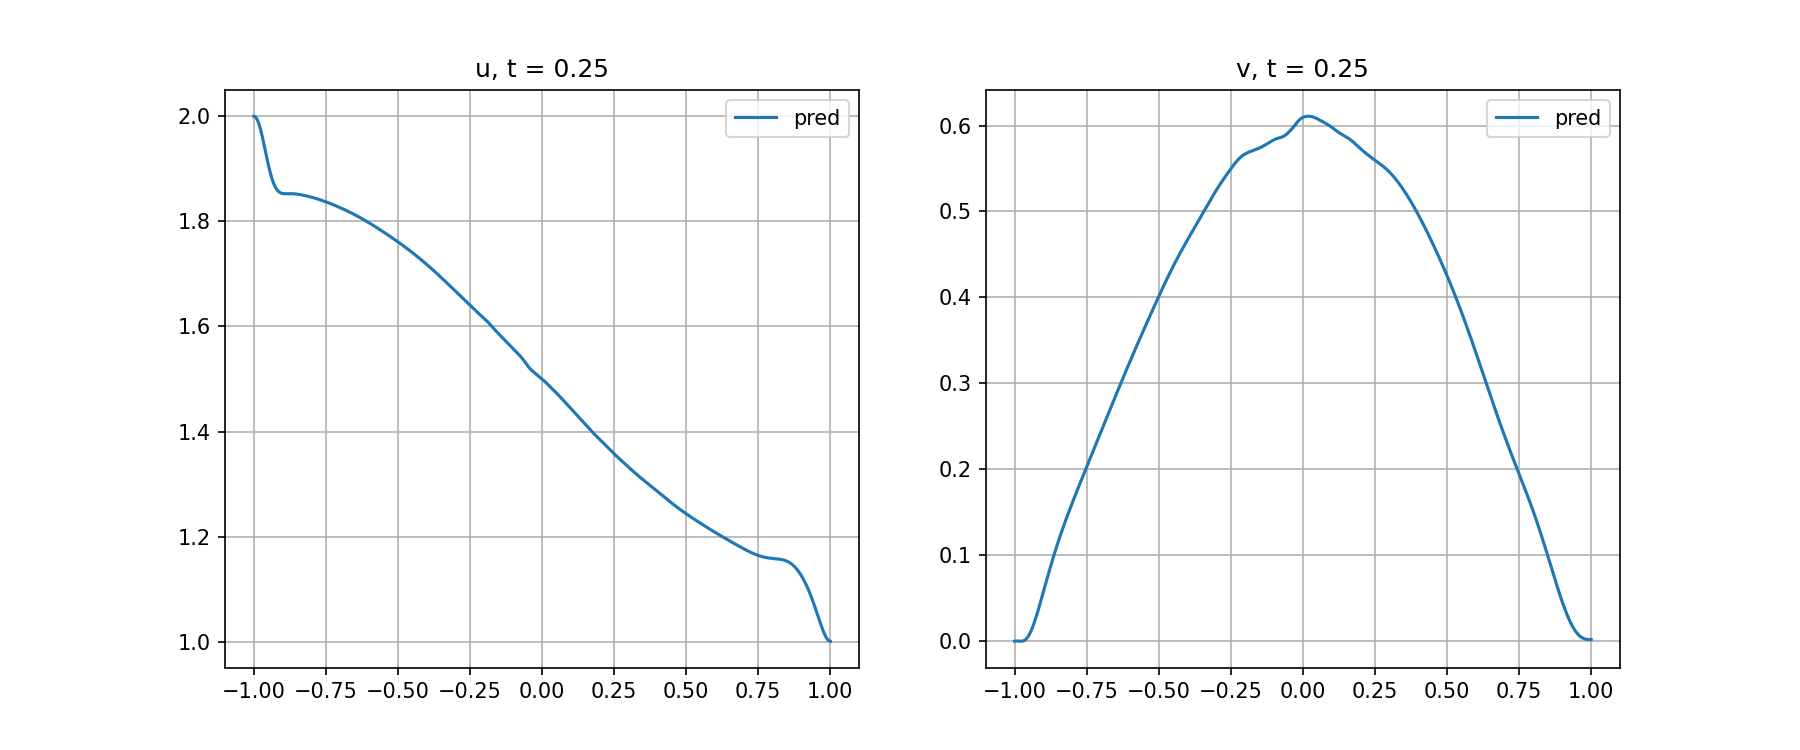

In [9]:
f, ax = plt.subplots(1, 2, figsize = (12, 5))
ax[0].plot(x_test, u_preds[-1], label = "pred")
ax[0].set_title("u, t = {}".format(t_test[-1]))
ax[1].plot(x_test, v_preds[-1], label = "pred")
ax[1].set_title("v, t = {}".format(t_test[-1]))
for i in range(2):
	ax[i].legend()
	ax[i].grid()
plt.show()

In [ ]:
# x = jnp.linspace(*domain[:, 0], 10000).reshape((-1, 1))
# t = jnp.zeros_like(x)
# xt = jnp.hstack([x, t])


# # direct_params_ = direct_params
# direct_params_ = get_params(opt_state)
# duv_dxt = jacobian(direct_params_, xt)
# du_dt, dv_dt = duv_dxt[:, 0:1, 1], duv_dxt[:, 1:2, 1]
# du_dx, dv_dx = duv_dxt[:, 0:1, 0], duv_dxt[:, 1:2, 0]
# duv_dxxtt = hessian(direct_params_, xt)
# du_dxx, dv_dxx = duv_dxxtt[:, 0:1, 0, 0], duv_dxxtt[:, 1:2, 0, 0] 
# uv = model(direct_params_, xt)
# u, v = uv[:, 0:1], uv[:, 1:2]
# loss_c1 = epsilon*du_dt + 0.5*epsilon**2*dv_dxx - V*v
# loss_c2 = epsilon*dv_dt - 0.5*epsilon**2*du_dxx + V*u

# du0_dx, dv0_dx = du0_dx_fn(xt), dv0_dx_fn(xt)
# du0_dxx, dv0_dxx = du0_dxx_fn(xt), dv0_dxx_fn(xt)
# u0, v0 = u0_fn(xt[:, 0:1], xt[:, 1:2]), v0_fn(xt[:, 0:1], xt[:, 1:2])
# du0_dt = 1.0/epsilon*(V*v0 - epsilon**2/2*dv0_dxx)
# dv0_dt = 1.0/epsilon*(epsilon**2/2*du0_dxx - V*u0)
# loss_c10 = epsilon*du0_dt + 0.5*epsilon**2*dv0_dxx - V*v0
# loss_c20 = epsilon*dv0_dt - 0.5*epsilon**2*du0_dxx + V*u0

# %matplotlib inline
# plt.rcParams.update(plt.rcParamsDefault)
# plt.rcParams["text.usetex"] = True

# f, ax = plt.subplots(2, 5, figsize = (20, 10))
# i, j = 0, 0
# ax[i][j].plot(x, du_dt, label = "pred")
# ax[i][j].plot(x, du0_dt, label = "true")
# ax[i][j].set_title(r"$\frac{\partial u}{\partial t}$")
# i = 1
# ax[i][j].plot(x, dv_dt, label = "pred")
# ax[i][j].plot(x, dv0_dt, label = "true")
# ax[i][j].set_title(r"$\frac{\partial v}{\partial t}$")
# i, j = 0, j+1
# ax[i][j].plot(x, du_dx, label = "pred")
# ax[i][j].plot(x, du0_dx, label = "true")
# ax[i][j].set_title(r"$\frac{\partial u}{\partial x}$")
# i = 1
# ax[i][j].plot(x, dv_dx, label = "pred")
# ax[i][j].plot(x, dv0_dx, label = "true")
# ax[i][j].set_title(r"$\frac{\partial v}{\partial x}$")
# i, j = 0, j+1
# ax[i][j].plot(x, du_dxx, label = "pred")
# ax[i][j].plot(x, du0_dxx, label = "true")
# ax[i][j].set_title(r"$\frac{\partial^2 u}{\partial x^2}$")
# i = 1
# ax[i][j].plot(x, dv_dxx, label = "pred")
# ax[i][j].plot(x, dv0_dxx, label = "true")
# ax[i][j].set_title(r"$\frac{\partial^2 v}{\partial x^2}$")
# i, j = 0, j+1
# ax[i][j].plot(x, u, label = "pred")
# ax[i][j].plot(x, u0, label = "true")
# ax[i][j].set_title(r"$u$")
# i = 1
# ax[i][j].plot(x, v, label = "pred")
# ax[i][j].plot(x, v0, label = "true")
# ax[i][j].set_title(r"$v$")
# i, j = 0, j+1
# ax[i][j].plot(x, loss_c1, label = "pred")
# ax[i][j].plot(x, loss_c10, label = "true")
# ax[i][j].set_title(r"loss c1")
# i = 1
# ax[i][j].plot(x, loss_c2, label = "pred")
# ax[i][j].plot(x, loss_c20, label = "true")
# ax[i][j].set_title(r"loss c2")

# for i in range(2):
# 	for j in range(5):
# 		ax[i][j].legend()
# 		ax[i][j].grid()
# plt.show()

In [ ]:
get_params(opt_state)

In [ ]:
du_dxx

In [ ]:
du0_dx_fn(jnp.array([[-0.25, 0.0], [0.25, 0.0]]))